(Heading + description) -> Index If possible, jump to certain section

In [331]:
import sys, platform
import pyomo
import numpy as np
import pandas as pd

print("Python:", sys.version.split()[0])
print("OS:", platform.platform())
print("Pyomo:", pyomo.__version__)
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)


Python: 3.12.3
OS: Windows-11-10.0.26100-SP0
Pyomo: 6.9.2
NumPy: 1.26.4
Pandas: 2.2.2


In [332]:
from pyomo.environ import SolverFactory

# Replace 'highs' with the solver you actually use: 'gurobi', 'cplex', 'glpk', 'cbc', 'appsi_highs', etc.
solver = SolverFactory('gurobi')  
print("Solver available?", solver.available())

# Try to get a version (works for some solvers via the executable)
try:
    v = solver.version()  # may return None for some drivers
    print("Solver version:", v)
except Exception as e:
    print("Solver version not reported by driver:", e)

# A robust fallback: run a dummy solve with tee=True once to capture the banner/version in the logs
# results = solver.solve(instance, tee=True)


Solver available? True
Solver version: (12, 0, 3)


## Section 1: Set up Abstract optimisation model

In [333]:
#Set up model for Funding Gap Optimisation
#import important libraries
import sys
import numpy as np
#Install Pyomo if not already installed
#!pip install pyomo

from pyomo import environ as pe
from pyomo.environ import value


model = pe.AbstractModel()

# Sets
model.Plants = pe.Set()
model.Sectors = pe.Set()

# Parameters (to be loaded from data)
model.Carbon_Intensity = pe.Param(model.Plants)
model.Actual_Production = pe.Param(model.Plants)
model.Emission_Cap = pe.Param(model.Plants)
model.Jurisdiction_GHG = pe.Param(model.Plants)
model.Abatement_Cost = pe.Param(model.Plants)
model.CO2_Capture = pe.Param(model.Plants)
model.Country = pe.Param(model.Plants, within=pe.Any)
model.Sector = pe.Param(model.Plants, within=pe.Any)

# Decision Variables
model.ETS_Price = pe.Var(bounds=(0, 71)) 
model.Carbon_Tax = pe.Var(model.Sectors, bounds=(0, 71))  # Now Carbon_Tax is sector-specific

""" # Set a regularization weight (you can tune this value for fairness vs. efficiency)
lambda_weight = 0.1

def penalty_objective_rule(model):
    funding_gap = sum(
        model.ETS_Price * (model.Carbon_Intensity[p] * model.Actual_Production[p]) * (1 - model.Emission_Cap[p])
        + model.Carbon_Tax[model.Sector[p]] * (model.Carbon_Intensity[p] * model.Actual_Production[p]) * model.Jurisdiction_GHG[p]
        - model.Abatement_Cost[p] * (model.Carbon_Intensity[p] * model.Actual_Production[p] * model.CO2_Capture[p])
        for p in model.Plants
    )
    # Add the penalty term to the funding gap
    penalty = lambda_weight * sum(model.Carbon_Tax[s]**2 for s in model.Sectors)
    return funding_gap + penalty

model.PenaltyObjective = pe.Objective(rule=penalty_objective_rule, sense=pe.minimize)
 """

# Objective function #Previous objective function is commented out since the penalty was added
def funding_gap_rule(model):
    return sum(
        model.ETS_Price * (model.Carbon_Intensity[p] * model.Actual_Production[p]) * (1 - model.Emission_Cap[p])
        + model.Carbon_Tax[model.Sector[p]] * (model.Carbon_Intensity[p] * model.Actual_Production[p]) * model.Jurisdiction_GHG[p]
        - model.Abatement_Cost[p] * (model.Carbon_Intensity[p] * model.Actual_Production[p] * model.CO2_Capture[p])
        for p in model.Plants
    )
model.FundingGap = pe.Objective(rule=funding_gap_rule, sense=pe.minimize) 



# Constraint: FundingGap must equal 0
def funding_gap_zero_rule(model):
    return sum(
        model.ETS_Price * (model.Carbon_Intensity[p] * model.Actual_Production[p]) * (1 - model.Emission_Cap[p])
        + model.Carbon_Tax[model.Sector[p]] * (model.Carbon_Intensity[p] * model.Actual_Production[p]) * model.Jurisdiction_GHG[p]
        - model.Abatement_Cost[p] * (model.Carbon_Intensity[p] * model.Actual_Production[p] * model.CO2_Capture[p])
        for p in model.Plants
    ) == 0
model.FundingGapZero = pe.Constraint(rule=funding_gap_zero_rule)




## Section 2: Load dataset in Excel (xlsx) and check for N/A and duplicate

In [334]:
import pandas as pd

# Load your Excel file
df = pd.read_excel('ClimateTrace_Original Data.xlsx')

# ---- Add country cleaning step ----
df['COUNTRY'] = df['COUNTRY'].astype(str).str.strip()

# Check for missing values and show their locations
missing = df.isnull()
if missing.values.any():
    print("Missing values found in the following locations:")
    for col in df.columns:
        if missing[col].any():
            print(f"Column: {col}")
            print(df.loc[missing[col], ['Plant', col]])
else:
    print("No missing values detected!")

# Check for duplicate plant names and show them
duplicates = df['Plant'][df['Plant'].duplicated(keep=False)]
if not duplicates.empty:
    print("Duplicate plant names found:")
    print(df[df['Plant'].isin(duplicates)][['Plant']])
else:
    print("No duplicate plant names detected!")



Missing values found in the following locations:
Column: Type
                      Plant Type
9   VNM-Báº¯c Giang_ammonia  NaN
10  VNM-TÃ¢n ThÃ nh_ammonia  NaN
11       VNM-U Minh_ammonia  NaN
12  VNM-YÃªn KhÃ¡nh_ammonia  NaN
No duplicate plant names detected!


## Section 3: Clean the dataset and create .dat file

In [335]:
# Clean plant names to ASCII only
import re

def clean_name(name):
    # Remove non-ASCII, replace spaces with underscores, remove special characters
    name = name.encode('ascii', 'ignore').decode('ascii')
    name = re.sub(r'[&\'\"]', '', name)  # Remove &, ', "
    name = re.sub(r'\s+', '_', name)     # Replace spaces with underscores
    name = re.sub(r'[^A-Za-z0-9_]', '', name)  # Remove any other non-alphanumeric
    return name

df['Plant'] = df['Plant'].astype(str).apply(clean_name)
df['Sector'] = df['Sector'].astype(str).str.strip().str.replace(' ', '_')

# Export Data to a Pyomo .dat File
with open('pyomo_data.dat', 'w') as f:
    # Write set Plants
    f.write('set Plants := ' + ' '.join(df['Plant'].astype(str)) + ';\n')
    
    # Write set Sectors (add this line)
    f.write('set Sectors := ' + ' '.join(df['Sector'].unique()) + ';\n')
    
    # Write parameters used in calculation
    for col, param in [
        ("Grey' Carbon Intensity (TonneCO2/TonneUnit)", 'Carbon_Intensity'),
        ('ACTUAL PRODUCTION (TONNES/YEAR)', 'Actual_Production'),
        ('Percentage cap on emissions (%)', 'Emission_Cap'),
        ("Share of Jurisdiction’s Greenhouse Gas Emissions Covered (%) for carbon tax", 'Jurisdiction_GHG'),
        ('TOTAL ABATEMENT COST ($/PER TONNE CO2 REDUCED)', 'Abatement_Cost'),
        ('%CO2 CAPTURED', 'CO2_Capture')
    ]:
        f.write(f'param {param} :=\n')
        for plant, value in zip(df['Plant'], df[col]):
            f.write(f'  {plant} {value}\n')
        f.write(';\n')
    
    # Write additional parameters for filtering/grouping (your existing code)
    for col, param in [
        ('COUNTRY', 'Country'),
        ('Sector', 'Sector')
    ]:
        f.write(f'param {param} :=\n')
        for plant, value in zip(df['Plant'], df['Sector']):
            f.write(f'  {plant} {value}\n')
        f.write(';\n')

import pandas as pd

# Preview main parameters in tabular format
params = [
    ("Grey' Carbon Intensity (TonneCO2/TonneUnit)", 'Carbon_Intensity'),
    ('ACTUAL PRODUCTION (TONNES/YEAR)', 'Actual_Production'),
    ('Percentage cap on emissions (%)', 'Emission_Cap'),
    ('%CO2 CAPTURED', 'CO2_Capture'),
    ("Share of Jurisdiction’s Greenhouse Gas Emissions Covered (%) for carbon tax", 'Jurisdiction_GHG'),
    ('TOTAL ABATEMENT COST ($/PER TONNE CO2 REDUCED)', 'Abatement_Cost'),
    ('%CO2 CAPTURED', 'CO2_Capture'),
    ('COUNTRY', 'Country'),
    ('Sector', 'Sector')
]

# Build a preview DataFrame
preview_dict = {'Plant': df['Plant']}
for col, param in params:
    preview_dict[param] = df[col]

preview_df = pd.DataFrame(preview_dict)
print(preview_df.head(10))  # Show first 10 rows

                                     Plant  Carbon_Intensity  \
0  CNR_Mandan_Steel_South_Kalimantan_plant             2.434   
1               Dexin_Steel_Morowali_plant             2.434   
2             KS_Posco_Cilegon_steel_plant             2.434   
3             Alliance_Steel_Kuantan_plant             2.434   
4              Eastern_Steel_Kemaman_plant             2.434   
5              Formosa_Ha_Tinh_Steel_plant             2.434   
6           Hoa_Phat_Dung_Quat_steel_plant             2.434   
7           Hoa_Phat_Hai_Duong_Steel_plant             2.434   
8        Lao_Cai_Cast_Iron_and_Steel_Plant             2.434   
9                      VNMBc_Giang_ammonia             2.764   

   Actual_Production  Emission_Cap  CO2_Capture  Jurisdiction_GHG  \
0       7.617449e+05           0.4        0.700                 1   
1       4.853979e+06           0.4        0.700                 1   
2       2.408398e+06           0.4        0.700                 1   
3       2.835014e+0

## Section 4 Gurobi and Pyomo Solver Check & Setup

In [336]:
# Check Gurobi install, license, and Pyomo integration
try:
    import gurobipy
    print("Gurobi Python version:", gurobipy.gurobi.version())
    m = gurobipy.Model()
    print("Gurobi license: OK")
except Exception as e:
    print("Gurobi install/license problem:", e)

try:
    from pyomo.environ import SolverFactory
    solver = SolverFactory('gurobi')
    print("Pyomo sees Gurobi:", solver.available())
except Exception as e:
    print("Pyomo-Gurobi check failed:", e)



Gurobi Python version: (12, 0, 3)
Gurobi license: OK
Pyomo sees Gurobi: True


## Section 5 Scenario Analysis: Run Model Across Multiple Policy Scenarios

In [337]:
from pyomo.environ import value, TerminationCondition

def run_scenario(instance, fix_vars=None, scenario_name=""):
    fixed_vars = []
    if fix_vars:
        for var, val in fix_vars:
            # For sector-wise variable, set for all sectors and track keys for unfixing
            if hasattr(var, 'keys'):
                for k in var.keys():
                    var[k].fix(val)
                    fixed_vars.append((var[k],))
            else:
                var.fix(val)
                fixed_vars.append((var,))
    result = solver.solve(instance, tee=True)
    tc = result.solver.termination_condition

    # Gather output regardless of feasibility
    try:
        funding_gap = value(instance.FundingGap)
    except Exception:
        funding_gap = None

    try:
        ets_val = instance.ETS_Price.value
    except Exception:
        ets_val = None

    try:
        tax_vals = {s: instance.Carbon_Tax[s].value for s in instance.Sectors}
    except Exception:
        tax_vals = {s: None for s in instance.Sectors}

    if tc == TerminationCondition.optimal:
        status = "optimal"
    elif tc == TerminationCondition.infeasible:
        status = "infeasible"
    else:
        status = str(tc)

    # Unfix variables after solving
    for v_tuple in fixed_vars:
        for v in v_tuple:
            v.unfix()

    return {
        'Status': status,
        'Funding Gap': funding_gap,
        'Carbon Tax': tax_vals,
        'ETS Price': ets_val
    }

def infeasible_report(instance, policy_bounds):
    # policy_bounds: list of (var, value) tuples, e.g. [(instance.ETS_Price, 100), (instance.Carbon_Tax, 100)]
    fixed_vars = []
    for var, bound in policy_bounds:
        if hasattr(var, 'keys'):
            for k in var.keys():
                var[k].fix(bound)
                fixed_vars.append((var[k],))
        else:
            var.fix(bound)
            fixed_vars.append((var,))
    result = solver.solve(instance, tee=False)
    try:
        gap = value(instance.FundingGap)
    except Exception:
        gap = None
    # Unfix after reporting
    for v_tuple in fixed_vars:
        for v in v_tuple:
            v.unfix()
    return gap

# Main scenario analysis
if 'solver' in locals() and solver.available():
    scenario_results = []

    # --- Scenario 1: No Policy ---
    funding_gap = (preview_df['Abatement_Cost'] * preview_df['Actual_Production'] * preview_df['CO2_Capture']).sum()
    scenario_results.append({
        'Scenario': 'No Policy',
        'Status': 'calculated',
        'Funding Gap': funding_gap,
        'Carbon Tax': 0,
        'ETS Price': 0,
    })

    # --- Scenario 2: Carbon Tax Only ---
    instance2 = model.create_instance('pyomo_data.dat')
    result2 = run_scenario(instance2, fix_vars=[(instance2.ETS_Price, 0)], scenario_name='Carbon Tax Only')
    result2['Scenario'] = 'Carbon Tax Only'
    scenario_results.append(result2)

    if result2['Status'] == 'infeasible':
        max_gap = infeasible_report(instance2, [(instance2.ETS_Price, 0), (instance2.Carbon_Tax, 70)])
        result2['Funding Gap at max'] = max_gap
        result2['Carbon Tax at max'] = {s: 70 for s in instance2.Sectors}
        result2['ETS Price at max'] = 0

    # --- Scenario 3: ETS Only ---
    instance3 = model.create_instance('pyomo_data.dat')
    result3 = run_scenario(instance3, fix_vars=[(instance3.Carbon_Tax, 0)], scenario_name='ETS Only')
    result3['Scenario'] = 'ETS Only'
    scenario_results.append(result3)

    if result3['Status'] == 'infeasible':
        max_gap = infeasible_report(instance3, [(instance3.ETS_Price, 70), (instance3.Carbon_Tax, 0)])
        result3['Funding Gap at max'] = max_gap
        result3['Carbon Tax at max'] = {s: 0 for s in instance3.Sectors}
        result3['ETS Price at max'] = 70

    # --- Scenario 4: Carbon Tax + ETS ---
    instance4 = model.create_instance('pyomo_data.dat')
    result4 = run_scenario(instance4, scenario_name='Carbon Tax + ETS')
    result4['Scenario'] = 'Carbon Tax + ETS'
    scenario_results.append(result4)

    if result4['Status'] == 'infeasible':
        max_gap = infeasible_report(instance4, [(instance4.ETS_Price, 70), (instance4.Carbon_Tax, 70)])
        result4['Funding Gap at max'] = max_gap
        result4['Carbon Tax at max'] = {s: 70 for s in instance4.Sectors}
        result4['ETS Price at max'] = 70

    # --- Results Table ---
    results_df = pd.DataFrame(scenario_results)
    display(results_df)

    # Print details for each scenario
    for result in scenario_results:
        print(f"\nScenario: {result['Scenario']}")
        print(f"  Status: {result['Status']}")
        print(f"  Funding Gap: {result['Funding Gap']}")
        print(f"  ETS Price: {result['ETS Price']}")
        print(f"  Carbon Tax by Sector:")
        for sector, tax in (result['Carbon Tax'].items() if isinstance(result['Carbon Tax'], dict) else []):
            print(f"    {sector}: {tax}")

else:
    print("Solver not available, optimization not run.")


Read LP format model from file C:\Users\Keerati\AppData\Local\Temp\tmp1fevy398.pyomo.lp
Reading time = 0.01 seconds
x1: 1 rows, 5 columns, 4 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 7 7735HS with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 1 rows, 5 columns and 4 nonzeros
Model fingerprint: 0x026a8aca
Coefficient statistics:
  Matrix range     [3e+06, 9e+07]
  Objective range  [3e+06, 9e+09]
  Bounds range     [1e+00, 7e+01]
  RHS range        [9e+09, 9e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 1 rows and 5 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations a

Scenario      Status   Funding Gap  \
0         No Policy  calculated  8.180546e+10   
1   Carbon Tax Only     optimal -5.688053e-06   
2          ETS Only  infeasible           NaN   
3  Carbon Tax + ETS     optimal -5.688053e-06   

                                          Carbon Tax  ETS Price  \
0                                                  0        0.0   
1  {'Iron_and_steel': 71.0, 'Ammonia': 71.0, 'Cem...        0.0   
2  {'Iron_and_steel': 0, 'Ammonia': 0, 'Cement': ...        NaN   
3  {'Iron_and_steel': 71.0, 'Ammonia': 71.0, 'Cem...        0.0   

   Funding Gap at max                                  Carbon Tax at max  \
0                 NaN                                                NaN   
1                 NaN                                                NaN   
2       -1.096706e+09  {'Iron_and_steel': 0, 'Ammonia': 0, 'Cement': ...   
3                 NaN                                                NaN   

   ETS Price at max  
0               NaN  
1               NaN  
2              70.0  
3               NaN


Scenario: No Policy
  Status: calculated
  Funding Gap: 81805460899.24428
  ETS Price: 0
  Carbon Tax by Sector:

Scenario: Carbon Tax Only
  Status: optimal
  Funding Gap: -5.688052624464035e-06
  ETS Price: 0
  Carbon Tax by Sector:
    Iron_and_steel: 71.0
    Ammonia: 71.0
    Cement: 19.988134656859252
    Refinery: 71.0

Scenario: ETS Only
  Status: infeasible
  Funding Gap: None
  ETS Price: None
  Carbon Tax by Sector:
    Iron_and_steel: 0
    Ammonia: 0
    Cement: 0
    Refinery: 0

Scenario: Carbon Tax + ETS
  Status: optimal
  Funding Gap: -5.688052624464035e-06
  ETS Price: 0.0
  Carbon Tax by Sector:
    Iron_and_steel: 71.0
    Ammonia: 71.0
    Cement: 19.988134656859252
    Refinery: 71.0


## Policy Limit Sensitivity Analysis (ETS/Carbon Tax Cap)
### Assumptions: Emission Cap = 0.4, Abatement Cost = 90 USD/TonneCO2, Jurisdiction GHG = 1, %CO2 Capture : Iron&Steel = 0.7, Ammonia, 0.944, Cement = 0.36, Refinery = 0.62

In [338]:
# --- Sensitivity Sweep: Vary ETS Cap, Fixed Carbon Tax Cap, with Infeasibility Reporting ---

ets_caps = list(range(0, 121, 10))  # ETS cap from 0 to 120 in steps of 10
tax_cap = 100  # Fixed Carbon Tax cap for all sectors

results = []

for ets_cap in ets_caps:
    # Create a fresh instance for each scenario
    instance = model.create_instance('pyomo_data.dat')
    
    # Set the ETS upper bound on the instance
    instance.ETS_Price.setub(ets_cap)
    # Set the Carbon Tax cap for all sectors on the instance
    for s in instance.Sectors:
        instance.Carbon_Tax[s].setub(tax_cap)

    # Run the scenario (both instruments are allowed)
    res = run_scenario(instance)

    # If infeasible, report the gap and rates at the max policy cap
    if res['Status'] == 'infeasible':
        # Fix all to their upper bounds for "max policy effort" scenario
        max_gap = infeasible_report(instance, [
            (instance.ETS_Price, ets_cap),
            (instance.Carbon_Tax, tax_cap)
        ])
        # Fill in policy rates for maxed-out scenario
        max_ets = ets_cap
        max_taxes = {s: tax_cap for s in instance.Sectors}
    else:
        max_gap = None
        max_ets = res['ETS Price']
        max_taxes = res['Carbon Tax']

    # Compose result dictionary, always filling both "actual" and "maxed" info
    results.append({
        'ETS_Cap': ets_cap,
        'Tax_Cap': tax_cap,
        'Status': res['Status'],
        'Funding Gap': res['Funding Gap'],
        'ETS Price': res['ETS Price'],
        **{f"Carbon Tax [{s}]": res['Carbon Tax'][s] for s in res['Carbon Tax']},
        # For infeasibility inspection:
        'Gap at cap': max_gap,
        'ETS at cap': max_ets,
        **{f"Tax at cap [{s}]": max_taxes[s] for s in max_taxes}
    })

import pandas as pd
results_df = pd.DataFrame(results)
display(results_df)

# Print out the “breakpoint” where it first becomes feasible
first_feasible = results_df[results_df['Status'] == 'optimal'].head(1)
if not first_feasible.empty:
    print("\nFirst feasible solution found at:")
    display(first_feasible)
else:
    print("\nNo feasible solution found for any ETS cap in the range.")


Read LP format model from file C:\Users\Keerati\AppData\Local\Temp\tmp99i9guy1.pyomo.lp
Reading time = 0.01 seconds
x1: 1 rows, 6 columns, 5 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 7 7735HS with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 1 rows, 6 columns and 5 nonzeros
Model fingerprint: 0x7494d9f7
Coefficient statistics:
  Matrix range     [3e+06, 1e+08]
  Objective range  [3e+06, 9e+09]
  Bounds range     [1e+00, 1e+02]
  RHS range        [9e+09, 9e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 1 rows and 6 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations a

ETS_Cap  Tax_Cap      Status  Funding Gap  ETS Price  \
0         0      100     optimal    -0.000005   0.000000   
1        10      100     optimal    -0.000005   0.000000   
2        20      100     optimal    -0.000005   0.000000   
3        30      100     optimal    -0.000005   0.000000   
4        40      100     optimal    -0.000005   0.000000   
5        50      100     optimal    -0.000005   0.000000   
6        60      100     optimal    -0.000005   0.000000   
7        70      100  infeasible          NaN        NaN   
8        80      100     optimal    -0.000005  79.593055   
9        90      100     optimal    -0.000005  79.593055   
10      100      100     optimal    -0.000005  79.593055   
11      110      100     optimal    -0.000005  79.593055   
12      120      100     optimal    -0.000005  79.593055   

    Carbon Tax [Iron_and_steel]  Carbon Tax [Ammonia]  Carbon Tax [Cement]  \
0                     77.068499                 100.0                  0.0   
1                     77.068499                 100.0                  0.0   
2                     77.068499                 100.0                  0.0   
3                     77.068499                 100.0                  0.0   
4                     77.068499                 100.0                  0.0   
5                     77.068499                 100.0                  0.0   
6                     77.068499                 100.0                  0.0   
7                           NaN                   NaN                  NaN   
8                      0.000000                   0.0                  0.0   
9                      0.000000                   0.0                  0.0   
10                     0.000000                   0.0                  0.0   
11                     0.000000                   0.0                  0.0   
12                     0.000000                   0.0                  0.0   

    Carbon Tax [Refinery]    Gap at cap  ETS at cap  \
0                   100.0           NaN    0.000000   
1                   100.0           NaN    0.000000   
2                   100.0           NaN    0.000000   
3                   100.0           NaN    0.000000   
4                   100.0           NaN    0.000000   
5                   100.0           NaN    0.000000   
6                   100.0           NaN    0.000000   
7                     NaN  1.795711e+10   70.000000   
8                     0.0           NaN   79.593055   
9                     0.0           NaN   79.593055   
10                    0.0           NaN   79.593055   
11                    0.0           NaN   79.593055   
12                    0.0           NaN   79.593055   

    Tax at cap [Iron_and_steel]  Tax at cap [Ammonia]  Tax at cap [Cement]  \
0                     77.068499                 100.0                  0.0   
1                     77.068499                 100.0                  0.0   
2                     77.068499                 100.0                  0.0   
3                     77.068499                 100.0                  0.0   
4                     77.068499                 100.0                  0.0   
5                     77.068499                 100.0                  0.0   
6                     77.068499                 100.0                  0.0   
7                    100.000000                 100.0                100.0   
8                      0.000000                   0.0                  0.0   
9                      0.000000                   0.0                  0.0   
10                     0.000000                   0.0                  0.0   
11                     0.000000                   0.0                  0.0   
12                     0.000000                   0.0                  0.0   

    Tax at cap [Refinery]  
0                   100.0  
1                   100.0  
2                   100.0  
3                   100.0  
4                   100.0  
5                   100.0  
6         


First feasible solution found at:


ETS_Cap  Tax_Cap   Status  Funding Gap  ETS Price  \
0        0      100  optimal    -0.000005        0.0   

   Carbon Tax [Iron_and_steel]  Carbon Tax [Ammonia]  Carbon Tax [Cement]  \
0                    77.068499                 100.0                  0.0   

   Carbon Tax [Refinery]  Gap at cap  ETS at cap  Tax at cap [Iron_and_steel]  \
0                  100.0         NaN         0.0                    77.068499   

   Tax at cap [Ammonia]  Tax at cap [Cement]  Tax at cap [Refinery]  
0                 100.0                  0.0                  100.0

## 2D Policy Cap Sensitivity: ETS Cap vs Carbon Tax Cap

Solving: ETS cap = 0, Tax cap = 0
  ETS_Price upper bound: 0
  Carbon_Tax upper bounds: [0, 0, 0, 0]
Read LP format model from file C:\Users\Keerati\AppData\Local\Temp\tmpz33k8i6f.pyomo.lp
Reading time = 0.00 seconds
x1: 1 rows, 6 columns, 5 nonzeros
Set parameter NumericFocus to value 3
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 7 7735HS with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
NumericFocus  3

Optimize a model with 1 rows, 6 columns and 5 nonzeros
Model fingerprint: 0x7cbecc97
Coefficient statistics:
  Matrix range     [3e+06, 1e+08]
  Objective range  [3e+06, 9e+09]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e+09, 9e+09]
Presolve removed 0 rows and 6 columns
Presolve time: 0.01s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Infeasible model
model.name="unknown";
    - termination cond

ETS_Cap  Tax_Cap      Status  Funding Gap  ETS Price  \
0          0        0  infeasible          NaN        NaN   
1          0       10  infeasible          NaN        NaN   
2          0       20  infeasible          NaN        NaN   
3          0       30  infeasible          NaN        NaN   
4          0       40  infeasible          NaN        NaN   
..       ...      ...         ...          ...        ...   
116      100       60     optimal    -0.000005  79.593055   
117      100       70     optimal    -0.000005  79.593055   
118      100       80     optimal    -0.000005  79.593055   
119      100       90     optimal    -0.000005  79.593055   
120      100      100     optimal    -0.000005  79.593055   

     Carbon Tax [Iron_and_steel]  Carbon Tax [Ammonia]  Carbon Tax [Cement]  \
0                            NaN                   NaN                  NaN   
1                            NaN                   NaN                  NaN   
2                            NaN                   NaN                  NaN   
3                            NaN                   NaN                  NaN   
4                            NaN                   NaN                  NaN   
..                           ...                   ...                  ...   
116                          0.0                   0.0                  0.0   
117                          0.0                   0.0                  0.0   
118                          0.0                   0.0                  0.0   
119                          0.0                   0.0                  0.0   
120                          0.0                   0.0                  0.0   

     Carbon Tax [Refinery]    Gap at cap  ETS at cap  \
0                      NaN -9.099310e+09    0.000000   
1                      NaN -7.193928e+09    0.000000   
2                      NaN -5.288546e+09    0.000000   
3                      NaN -3.383164e+09    0.000000   
4                      NaN -1.477782e+09    0.000000   
..                     ...           ...         ...   
116                    0.0           NaN   79.593055   
117                    0.0           NaN   79.593055   
118                    0.0           NaN   79.593055   
119                    0.0           NaN   79.593055   
120                    0.0           NaN   79.593055   

     Tax at cap [Iron_and_steel]  Tax at cap [Ammonia]  Tax at cap [Cement]  \
0                            0.0                   0.0                  0.0   
1                           10.0                  10.0                 10.0   
2                           20.0                  20.0                 20.0   
3                           30.0                  30.0                 30.0   
4                           40.0                  40.0                 40.0   
..                           ...                   ...                  ...   
116                          0.0                   0.0                  0.0   
117                          0.0                   0.0                  0.0   
118                          0.0                   0.0                  0.0   
119                          0.0                   0.0                  0.0   
120                          0.0                   0.0                  0.0   

     Tax at cap [Refinery]  
0                      0.0  
1                     10.0  
2                     20.0  
3                     30.0  
4                     40.0  
..                     ...  
116                    0.0  
117                    0.0  
118                    0.0  
119                    0.0  
120                    0.0  

[121 rows x 15 columns]

Results exported to policy_feasibility_surface.csv


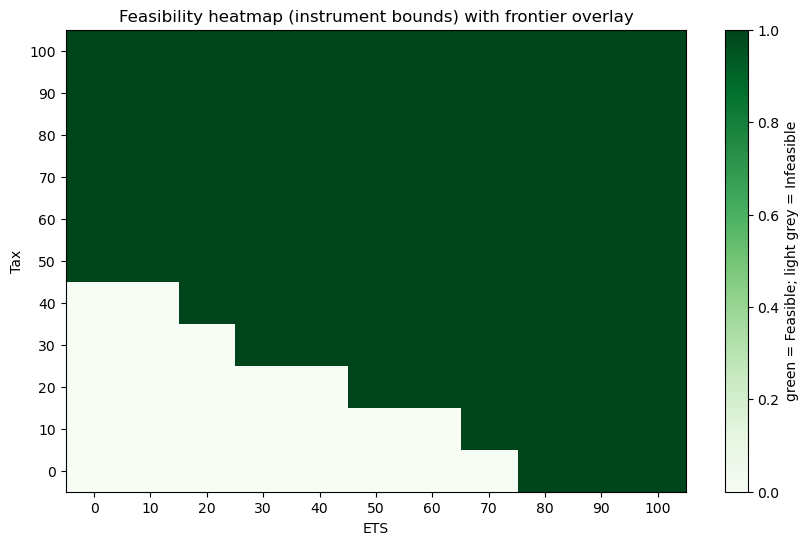

In [339]:
from pyomo.environ import value, TerminationCondition

# Optional: make solver more robust to numerical issues
solver.options['NumericFocus'] = 3

ets_caps = list(range(0, 101, 10))   # 0, 10, ..., 100
tax_caps = list(range(0, 101, 10))   # 0, 10, ..., 100

results = []

for ets_cap in ets_caps:
    for tax_cap in tax_caps:
        # Create a fresh model instance
        instance = model.create_instance('pyomo_data.dat')
        
        # Set bounds on the instance
        instance.ETS_Price.setub(ets_cap)
        for s in instance.Sectors:
            instance.Carbon_Tax[s].setub(tax_cap)
        
        # Print for debugging
        print(f"Solving: ETS cap = {ets_cap}, Tax cap = {tax_cap}")
        print("  ETS_Price upper bound:", instance.ETS_Price.ub)
        print("  Carbon_Tax upper bounds:", [instance.Carbon_Tax[s].ub for s in instance.Sectors])
        
        # Run scenario
        res = run_scenario(instance)
        
        # Infeasibility reporting at max caps
        if res['Status'] == 'infeasible':
            max_gap = infeasible_report(instance, [
                (instance.ETS_Price, ets_cap),
                (instance.Carbon_Tax, tax_cap)
            ])
            max_ets = ets_cap
            max_taxes = {s: tax_cap for s in instance.Sectors}
        else:
            max_gap = None
            max_ets = res['ETS Price']
            max_taxes = res['Carbon Tax']

        # Compose result dictionary
        results.append({
            'ETS_Cap': ets_cap,
            'Tax_Cap': tax_cap,
            'Status': res['Status'],
            'Funding Gap': res['Funding Gap'],
            'ETS Price': res['ETS Price'],
            **{f"Carbon Tax [{s}]": res['Carbon Tax'][s] for s in res['Carbon Tax']},
            'Gap at cap': max_gap,
            'ETS at cap': max_ets,
            **{f"Tax at cap [{s}]": max_taxes[s] for s in max_taxes}
        })

import pandas as pd
results_df = pd.DataFrame(results)
display(results_df)

# Export to CSV
results_df.to_csv('policy_feasibility_surface.csv', index=False)
print("Results exported to policy_feasibility_surface.csv")

# Quick feasibility heatmap
feas_pivot = results_df.pivot(index='Tax_Cap', columns='ETS_Cap', values='Status')
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.title("Feasibility heatmap (instrument bounds) with frontier overlay")
plt.imshow(feas_pivot == 'optimal', origin='lower', aspect='auto', cmap='Greens')
plt.xlabel("ETS")
plt.ylabel("Tax")
plt.xticks(ticks=range(len(ets_caps)), labels=ets_caps)
plt.yticks(ticks=range(len(tax_caps)), labels=tax_caps)
plt.colorbar(label='green = Feasible; light grey = Infeasible')
plt.show()


## Visualize the Minimum Required Policy Cap for Feasibility

### A. Feasibility Boundary Curve ("Policy Frontier")
Plot the minimum ETS cap required for each Carbon Tax cap to make the model feasible (and vice versa).

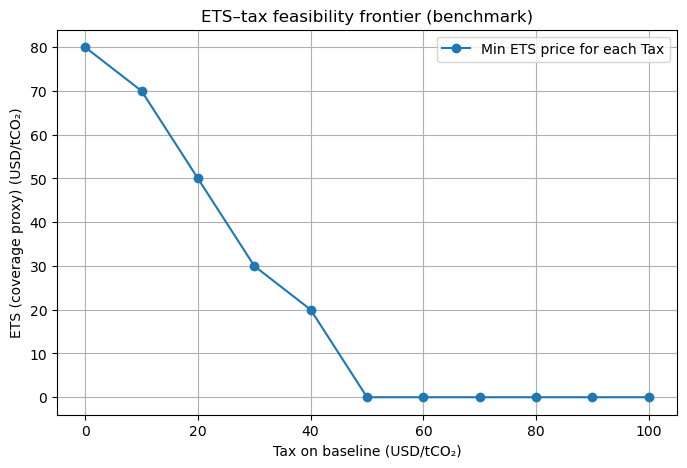

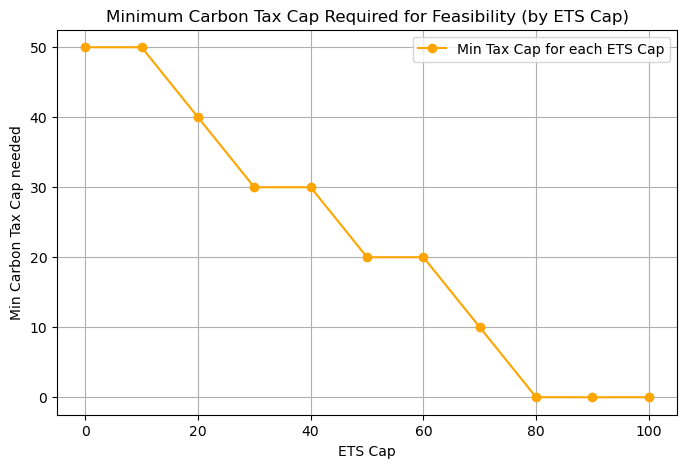

In [340]:
# Find the minimum ETS cap required for feasibility at each Carbon Tax cap
feasible_points = results_df[results_df['Status'] == 'optimal']

frontier_ets = feasible_points.groupby('Tax_Cap')['ETS_Cap'].min().reset_index()
frontier_tax = feasible_points.groupby('ETS_Cap')['Tax_Cap'].min().reset_index()

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(frontier_ets['Tax_Cap'], frontier_ets['ETS_Cap'], marker='o', label='Min ETS price for each Tax')
plt.xlabel('Tax on baseline (USD/tCO₂)')
plt.ylabel('ETS (coverage proxy) (USD/tCO₂)')
plt.title('ETS–tax feasibility frontier (benchmark)')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(frontier_tax['ETS_Cap'], frontier_tax['Tax_Cap'], marker='o', color='orange', label='Min Tax Cap for each ETS Cap')
plt.xlabel('ETS Cap')
plt.ylabel('Min Carbon Tax Cap needed')
plt.title('Minimum Carbon Tax Cap Required for Feasibility (by ETS Cap)')
plt.grid(True)
plt.legend()
plt.show()


In [341]:
# === Fig. 1 — Feasibility frontier (annotated) =================================
# Requirements:
# - results_df with columns: ['Status','Tax_Cap','ETS_Cap'] where Status == 'optimal' indicates feasible points
# - Excel file with IQR stats at: /mnt/data/d4bae3b8-5fad-43cf-bb3e-b990d3184f47.xlsx (sheets: 'Tax', 'ETS')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from pathlib import Path

# ----------------------- Helper: read global IQRs & medians --------------------
def _iqr_from_sheet(xlsx_path: str, sheet: str):
    """
    Extract 25th/50th/75th percentiles from the given sheet.
    Expects a 'Notes' column in 'Unnamed: 9' and values in the numeric column 'Unnamed: 8'.
    """
    df = pd.read_excel(xlsx_path, sheet_name=sheet)
    # Locate the stats block where Notes has 'Percentile' etc.; 'Unnamed: 8' holds numeric results.
    notes_col = 'Unnamed: 9'
    val_col   = 'Unnamed: 8'
    if notes_col not in df.columns or val_col not in df.columns:
        raise ValueError(f"Unexpected sheet structure in '{sheet}'. Found columns: {df.columns.tolist()}")
    grab = df[df[notes_col].astype(str).isin(['25th Percentile','50th Percentile','75th Percentile'])]
    q1 = float(grab.loc[grab[notes_col]=='25th Percentile', val_col].iloc[0])
    q2 = float(grab.loc[grab[notes_col]=='50th Percentile', val_col].iloc[0])  # median
    q3 = float(grab.loc[grab[notes_col]=='75th Percentile', val_col].iloc[0])
    return q1, q2, q3

# ----------------------- Main plotting function --------------------------------
def plot_feasibility_frontier(results_df: pd.DataFrame,
                              xlsx_path: str = "/mnt/data/d4bae3b8-5fad-43cf-bb3e-b990d3184f47.xlsx",
                              tax_sheet: str = "Tax",
                              ets_sheet: str = "ETS",
                              x_max: int = 100,
                              y_max: int = 100):
    # 1) Frontier: minimum ETS required at each Tax (among feasible points)
    feasible = results_df[results_df['Status'].astype(str).str.lower() == 'optimal'].copy()
    if feasible.empty:
        raise ValueError("No feasible points found (Status == 'optimal').")

    # Ensure numeric
    feasible['Tax_Cap'] = pd.to_numeric(feasible['Tax_Cap'], errors='coerce')
    feasible['ETS_Cap'] = pd.to_numeric(feasible['ETS_Cap'], errors='coerce')
    feasible = feasible.dropna(subset=['Tax_Cap','ETS_Cap'])

    # Group and take min ETS for each Tax
    frontier = (feasible.groupby('Tax_Cap', as_index=False)['ETS_Cap']
                        .min()
                        .sort_values('Tax_Cap'))

    # Keep within plotting window
    frontier = frontier[(frontier['Tax_Cap']>=0) & (frontier['Tax_Cap']<=x_max)]
    # If multiple gaps in x, optionally densify by interpolation to get smooth fill_between
    # Create a dense x-grid every 1 (or 0.5) between 0..x_max, but only interpolate where we have data bounds
    x_min_data, x_max_data = frontier['Tax_Cap'].min(), frontier['Tax_Cap'].max()
    x_dense = np.arange(max(0, np.floor(x_min_data)), min(x_max, np.ceil(x_max_data))+1, 1.0)
    y_dense = np.interp(x_dense, frontier['Tax_Cap'].values, frontier['ETS_Cap'].values)

    # 2) Global IQRs & medians from attached file (vertical for Tax; horizontal for ETS)
    if not Path(xlsx_path).exists():
        raise FileNotFoundError(f"Global price Excel not found at: {xlsx_path}")
    tax_q1, tax_med, tax_q3 = _iqr_from_sheet(xlsx_path, tax_sheet)
    ets_q1, ets_med, ets_q3 = _iqr_from_sheet(xlsx_path, ets_sheet)

    # 3) Plot
    fig, ax = plt.subplots(figsize=(8, 6))

    # Frontier curve
    ax.plot(x_dense, y_dense, linewidth=2, label='Feasibility frontier')

    # Shaded regions: infeasible below (light grey); feasible above (soft fill)
    # Infeasible (below frontier)
    ax.fill_between(x_dense, 0, y_dense, color='lightgrey', alpha=0.3, label='Infeasible')
    # Feasible (above frontier) — use default color with low alpha
    ax.fill_between(x_dense, y_dense, y_max, alpha=0.08, label='Feasible')

    # Global price IQR bands (semi-transparent) + medians (dashed)
    vband = ax.axvspan(max(0, tax_q1), min(x_max, tax_q3), alpha=0.12)
    hband = ax.axhspan(max(0, ets_q1), min(y_max, ets_q3), alpha=0.12)
    vmed  = ax.axvline(tax_med, linestyle='--', linewidth=1)
    hmed  = ax.axhline(ets_med, linestyle='--', linewidth=1)

    # Anchors (approximate)
    anchors = [
        (50, 0, "Tax-only ≈ 50"),
        (0, 80, "ETS-only ≈ 80"),
        (30, 30, "Balanced ≈ 30/30"),
    ]
    for (x, y, label) in anchors:
        ax.scatter([x], [y], s=40, zorder=3)
        ax.annotate(label, xy=(x, y), xytext=(5, 8), textcoords='offset points')

    # Axes, ticks, limits, labels
    ax.set_xlim(0, x_max)
    ax.set_ylim(0, y_max)
    ticks = np.arange(0, 101, 10)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xlabel("Tax on baseline (USD/tCO$_2$)")
    ax.set_ylabel("ETS (coverage proxy) (USD/tCO$_2$)")
    ax.set_title("Feasibility frontier")

    # Legend (clean, single entries)
    legend_elems = [
        Line2D([0],[0], color=ax.lines[0].get_color(), lw=2, label='Feasibility frontier'),
        Patch(facecolor='lightgrey', alpha=0.3, label='Infeasible'),
        Patch(facecolor=vband.get_facecolor()[0], alpha=vband.get_alpha(), label='Global tax IQR'),
        Patch(facecolor=hband.get_facecolor()[0], alpha=hband.get_alpha(), label='Global ETS IQR'),
        Line2D([0],[0], linestyle='--', color=vmed.get_color(), label='Global medians'),
    ]
    ax.legend(handles=legend_elems, loc='lower right', frameon=False)

    # Caption
    cap = ("Shaded region above the frontier is Feasible (below is Infeasible). "
           "Global price bands/medians computed from attached 2025 dataset (Tax & ETS sheets); "
           "values in constant 2024 USD/tCO$_2$.")
    # small caption under plot area
    fig.text(0.01, 0.01, cap, ha='left', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()

# ===================== Usage =====================
# plot_feasibility_frontier(results_df)


## Statistical Summary for Policy Ranges
### A. Describe the Range of Policy Values Used in Feasible Scenarios

In [342]:
# What are the actual ETS and Carbon Tax values chosen in feasible scenarios?
feasible = results_df[results_df['Status'] == 'optimal']

print("\nStatistical summary for ETS price in feasible scenarios:")
print(feasible['ETS Price'].describe())

print("\nStatistical summary for each sector's Carbon Tax in feasible scenarios:")
for col in feasible.columns:
    if col.startswith('Carbon Tax ['):
        print(f"\n{col}:")
        print(feasible[col].describe())



Statistical summary for ETS price in feasible scenarios:
count    96.000000
mean     31.810416
std      36.659896
min       0.000000
25%       0.000000
50%       6.463194
75%      79.593055
max      79.593055
Name: ETS Price, dtype: float64

Statistical summary for each sector's Carbon Tax in feasible scenarios:

Carbon Tax [Iron_and_steel]:
count    96.000000
mean     40.027420
std      33.583319
min       0.000000
25%       0.000000
50%      45.000000
75%      71.767125
max      85.760538
Name: Carbon Tax [Iron_and_steel], dtype: float64

Carbon Tax [Ammonia]:
count     96.000000
mean      42.291667
std       36.662879
min        0.000000
25%        0.000000
50%       45.000000
75%       72.500000
max      100.000000
Name: Carbon Tax [Ammonia], dtype: float64

Carbon Tax [Cement]:
count    96.000000
mean     13.843597
std      16.641233
min       0.000000
25%       0.000000
50%       0.000000
75%      30.000000
max      45.074930
Name: Carbon Tax [Cement], dtype: float64

Carbon Tax

### B. 3D Surface Plot (Optional, for advanced visualization)

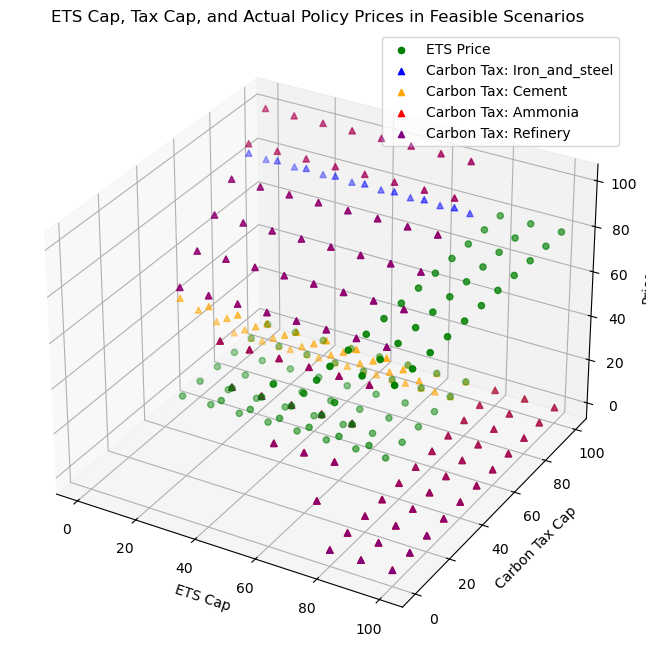

In [343]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# ETS Price (green)
ax.scatter(
    feasible['ETS_Cap'], feasible['Tax_Cap'], feasible['ETS Price'],
    c='g', marker='o', label='ETS Price'
)

# Loop over all sector carbon tax columns
color_map = {
    'Iron_and_steel': 'b',
    'Cement': 'orange',
    'Ammonia': 'r',
    'Refinery': 'purple'
}
for sector, color in color_map.items():
    colname = f'Carbon Tax [{sector}]'
    if colname in feasible.columns:
        ax.scatter(
            feasible['ETS_Cap'], feasible['Tax_Cap'], feasible[colname],
            c=color, marker='^', label=f'Carbon Tax: {sector}'
        )

ax.set_xlabel('ETS Cap')
ax.set_ylabel('Carbon Tax Cap')
ax.set_zlabel('Price')
ax.set_title('ETS Cap, Tax Cap, and Actual Policy Prices in Feasible Scenarios')
ax.legend()
plt.show()


## 3. Simple Policy Recommendation Table

### B. Visualizations
1. Box Plot (Range and Spread)
Boxplots make the range, quartiles, and outliers visually clear.

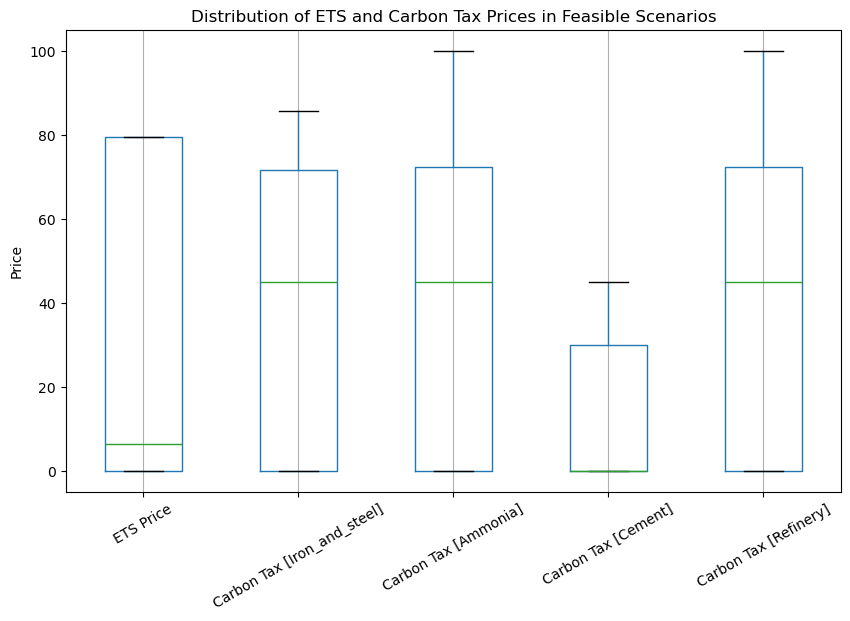

In [344]:
import matplotlib.pyplot as plt

# Collect all columns to plot
policy_cols = ['ETS Price'] + [col for col in feasible.columns if col.startswith('Carbon Tax [')]

plt.figure(figsize=(10, 6))
feasible[policy_cols].boxplot()
plt.title('Distribution of ETS and Carbon Tax Prices in Feasible Scenarios')
plt.ylabel('Price')
plt.xticks(rotation=30)
plt.grid(axis='y')
plt.show()


### 2. Violin Plot (Optional, More Info)
If you want to show the distribution “shape,” violin plots are great.

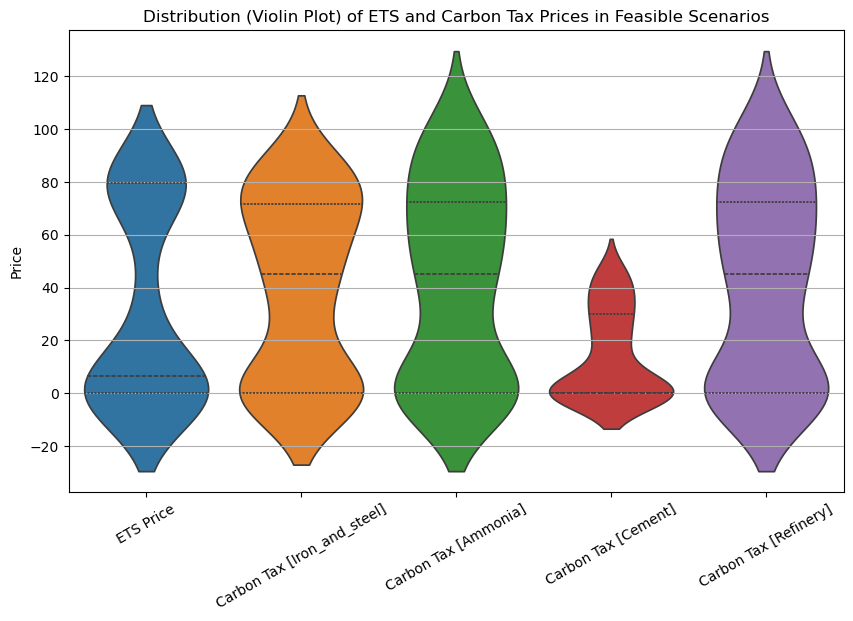

In [345]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.violinplot(data=feasible[policy_cols], inner='quartile')
plt.title('Distribution (Violin Plot) of ETS and Carbon Tax Prices in Feasible Scenarios')
plt.ylabel('Price')
plt.xticks(rotation=30)
plt.grid(axis='y')
plt.show()


### 3. Strip Plot (Optional, Individual Data Points)
For smaller datasets, strip plots show each scenario result:

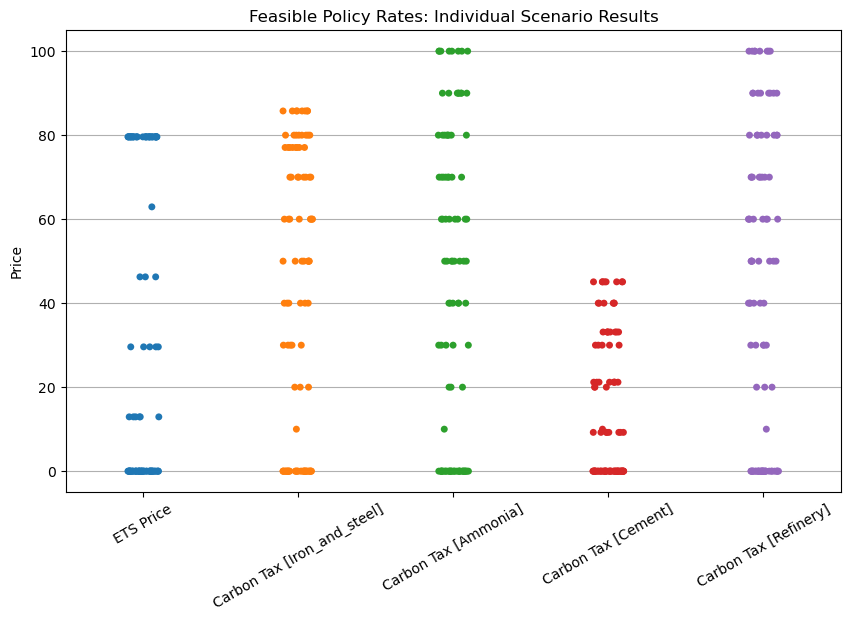

In [346]:
plt.figure(figsize=(10, 6))
sns.stripplot(data=feasible[policy_cols], jitter=True)
plt.title('Feasible Policy Rates: Individual Scenario Results')
plt.ylabel('Price')
plt.xticks(rotation=30)
plt.grid(axis='y')
plt.show()


## sensitivity analysis of emission cap, CO₂ capture rate, and abatement cost.

### 1. Import Libraries and Set Up Parameter Grids

In [347]:
import numpy as np
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

# Sensitivity parameter ranges
emission_caps = np.round(np.arange(0.0, 1.01, 0.1), 2)  # e.g. 0.0 to 1.0 step 0.1
capture_rates = np.round(np.arange(0.0, 1.01, 0.1), 2)   # e.g. 0.0 to 1.0 step 0.1
abatement_costs = list(range(0, 121, 10))  # e.g. 60, 70, ..., 120

print(f"Total runs: {len(emission_caps) * len(capture_rates) * len(abatement_costs)}")


Total runs: 1573


### 2. Helper Function to Write .dat File for Each Parameter Set

In [348]:
def write_dat_file_custom(emission_cap_val, capture_val, abatement_cost_val, output_path="pyomo_data.dat"):
    """
    Writes a Pyomo .dat file with modified emission cap, CO2 capture rate, and abatement cost.
    Applies string cleaning for Pyomo compatibility.
    """
    import re

    def clean_text(text):
        text = str(text)
        text = text.encode('ascii', 'ignore').decode('ascii')
        text = re.sub(r"[&\'\"]", '', text)
        text = re.sub(r"\s+", '_', text.strip())
        text = re.sub(r'[^A-Za-z0-9_]', '', text)
        return text

    # Copy DataFrame and update
    df_modified = df.copy()
    df_modified['Percentage cap on emissions (%)'] = emission_cap_val
    df_modified['%CO2 CAPTURED'] = capture_val
    df_modified['TOTAL ABATEMENT COST ($/PER TONNE CO2 REDUCED)'] = abatement_cost_val

    df_modified['Plant'] = df_modified['Plant'].astype(str).apply(clean_text)
    df_modified['Sector'] = df_modified['Sector'].astype(str).apply(clean_text)
    df_modified['COUNTRY'] = df_modified['COUNTRY'].astype(str).apply(clean_text)

    with open(output_path, 'w') as f:
        f.write('set Plants := ' + ' '.join(df_modified['Plant'].astype(str)) + ';\n')
        f.write('set Sectors := ' + ' '.join(df_modified['Sector'].unique()) + ';\n')

        for col, param in [
            ("Grey' Carbon Intensity (TonneCO2/TonneUnit)", 'Carbon_Intensity'),
            ('ACTUAL PRODUCTION (TONNES/YEAR)', 'Actual_Production'),
            ('Percentage cap on emissions (%)', 'Emission_Cap'),
            ("Share of Jurisdiction’s Greenhouse Gas Emissions Covered (%) for carbon tax", 'Jurisdiction_GHG'),
            ('TOTAL ABATEMENT COST ($/PER TONNE CO2 REDUCED)', 'Abatement_Cost'),
            ('%CO2 CAPTURED', 'CO2_Capture')
        ]:
            f.write(f'param {param} :=\n')
            for plant, value in zip(df_modified['Plant'], df_modified[col]):
                f.write(f'  {plant} {value}\n')
            f.write(';\n')

        for col, param in [('COUNTRY', 'Country'), ('Sector', 'Sector')]:
            f.write(f'param {param} :=\n')
            for plant, value in zip(df_modified['Plant'], df_modified[col]):
                f.write(f'  {plant} {value}\n')
            f.write(';\n')


### 3. Helper Function to Solve Model and Extract Results

In [349]:
from pyomo.opt import SolverStatus, TerminationCondition

def solve_model_from_notebook(model, data_path="pyomo_data.dat", solver_name="gurobi"):
    """
    Solves the Pyomo model with the given .dat file.
    Returns feasibility, ETS price, and sector carbon taxes (if feasible).
    """
    instance = model.create_instance(data_path)
    solver = pe.SolverFactory(solver_name)
    results = solver.solve(instance, tee=False)

    feasible = (results.solver.status == SolverStatus.ok and
                results.solver.termination_condition == TerminationCondition.optimal)

    if feasible:
        ets_price = instance.ETS_Price.value
        carbon_taxes = {s: instance.Carbon_Tax[s].value for s in instance.Sectors}
    else:
        ets_price = None
        carbon_taxes = {}

    return feasible, ets_price, carbon_taxes


### 4. Main Sensitivity Sweep Loop

In [350]:
def compute_policy_fund_gap(preview_df, ets_price, carbon_tax_dict, abatement_cost_scalar):
    # Handle missing or None-type values gracefully
    ets_price = float(ets_price) if ets_price is not None else 0.0
    abatement_cost_scalar = float(abatement_cost_scalar) if abatement_cost_scalar is not None else 0.0

    # ETS income
    ets_income = ets_price * (
        (preview_df['Carbon_Intensity'].astype(float) *
         preview_df['Actual_Production'].astype(float) *
         (1 - preview_df['Emission_Cap'].astype(float))).sum()
    )
    # Carbon tax income
    tax_income = 0
    for s in preview_df['Sector'].unique():
        sector_df = preview_df[preview_df['Sector'] == s]
        tax_val = carbon_tax_dict.get(s, 0)
        tax_val = float(tax_val) if tax_val is not None else 0.0
        tax_income += (
            tax_val *
            (sector_df['Carbon_Intensity'].astype(float) *
             sector_df['Actual_Production'].astype(float) *
             sector_df['Jurisdiction_GHG'].astype(float)).sum()
        )
    # Abatement cost (ensure capture is in [0,1])
    abate_cost = abatement_cost_scalar * (
        (preview_df['Carbon_Intensity'].astype(float) *
         preview_df['Actual_Production'].astype(float) *
         preview_df['CO2_Capture'].clip(upper=1.0).astype(float)).sum()
    )
    gap = ets_income + tax_income - abate_cost
    return ets_income, tax_income, abate_cost, gap


In [351]:
results_log = []
run_number = 0
total_runs = len(emission_caps) * len(capture_rates) * len(abatement_costs)

for e_cap, c_rate, ab_cost in product(emission_caps, capture_rates, abatement_costs):
    run_number += 1
    print(f"Running {run_number} / {total_runs} → Emission Cap={e_cap}, Capture={c_rate}, Abatement Cost={ab_cost}")

    write_dat_file_custom(emission_cap_val=e_cap, capture_val=c_rate, abatement_cost_val=ab_cost)
    feasible, ets_price, carbon_taxes = solve_model_from_notebook(model)

    has_policy_vals = feasible and ets_price is not None and all(v is not None for v in carbon_taxes.values())
    if has_policy_vals:
        ets_income, tax_income, abate_cost, gap = compute_policy_fund_gap(
            preview_df, ets_price, carbon_taxes, ab_cost
        )
    else:
        ets_income = tax_income = abate_cost = gap = None

    result = {
        "EmissionCap": e_cap,
        "CaptureRate": c_rate,
        "AbatementCost": ab_cost,
        "Feasible": feasible,
        "ETS_Price": ets_price,
        "ETS_Income": ets_income,
        "Tax_Income": tax_income,
        "Total_Abate_Cost": abate_cost,
        "Funding_Gap": gap
    }
    for sector, tax in carbon_taxes.items():
        result[f"CarbonTax_{sector}"] = tax

    results_log.append(result)

results_csv = pd.DataFrame(results_log)
results_csv.to_csv("EmissionCap+CO2Capture+AbatementCost_sensitivity_results_wfunding.csv", index=False)
print("All runs complete. Results saved to 'EmissionCap+CO2Capture+AbatementCost_sensitivity_results_wfunding.csv'")


Running 1 / 1573 → Emission Cap=0.0, Capture=0.0, Abatement Cost=0
Running 2 / 1573 → Emission Cap=0.0, Capture=0.0, Abatement Cost=10
Running 3 / 1573 → Emission Cap=0.0, Capture=0.0, Abatement Cost=20
Running 4 / 1573 → Emission Cap=0.0, Capture=0.0, Abatement Cost=30
Running 5 / 1573 → Emission Cap=0.0, Capture=0.0, Abatement Cost=40
Running 6 / 1573 → Emission Cap=0.0, Capture=0.0, Abatement Cost=50
Running 7 / 1573 → Emission Cap=0.0, Capture=0.0, Abatement Cost=60
Running 8 / 1573 → Emission Cap=0.0, Capture=0.0, Abatement Cost=70
Running 9 / 1573 → Emission Cap=0.0, Capture=0.0, Abatement Cost=80
Running 10 / 1573 → Emission Cap=0.0, Capture=0.0, Abatement Cost=90
Running 11 / 1573 → Emission Cap=0.0, Capture=0.0, Abatement Cost=100
Running 12 / 1573 → Emission Cap=0.0, Capture=0.0, Abatement Cost=110
Running 13 / 1573 → Emission Cap=0.0, Capture=0.0, Abatement Cost=120
Running 14 / 1573 → Emission Cap=0.0, Capture=0.1, Abatement Cost=0
Running 15 / 1573 → Emission Cap=0.0, Capt

In [352]:
import pandas as pd

def posthoc_policy_gap_diagnostic_to_csv(
    results_csv, preview_df, max_ets=70, max_tax=70
):
    """
    For all infeasible scenarios in the CSV, calculate policy income,
    abatement cost, and funding gap if all policies are set to their max boundary values.
    Adds these as new columns and saves the updated CSV.
    """
    # Load your results file
    df = pd.read_csv(results_csv)
    sectors = preview_df['Sector'].unique()
    max_tax_dict = {s: max_tax for s in sectors}

    def compute_policy_fund_gap(ets_price, abatement_cost_scalar):
        ets_income = (
            ets_price *
            (preview_df['Carbon_Intensity'] * preview_df['Actual_Production'] * (1 - preview_df['Emission_Cap'])).sum()
        )
        tax_income = 0
        for s in sectors:
            sector_df = preview_df[preview_df['Sector'] == s]
            tax_income += (
                max_tax_dict.get(s, 0) *
                (sector_df['Carbon_Intensity'] * sector_df['Actual_Production'] * sector_df['Jurisdiction_GHG']).sum()
            )
        abate_cost = (
            abatement_cost_scalar *
            (preview_df['Carbon_Intensity'] * preview_df['Actual_Production'] * preview_df['CO2_Capture']).sum()
        )
        gap = (ets_income + tax_income) - abate_cost
        return ets_income, tax_income, abate_cost, gap

    # Add new columns if not already present
    for col in [
        'ETS_Income', 'Tax_Income',
        'Abate_Cost', 'Funding_Gap'
    ]:
        if col not in df.columns:
            df[col] = None

    for idx, row in df.iterrows():
        if not row['Feasible']:
            abate_cost_param = row['AbatementCost']
            ets_income, tax_income, abate_cost, gap = compute_policy_fund_gap(max_ets, abate_cost_param)
            df.at[idx, 'ETS_Income'] = ets_income
            df.at[idx, 'Tax_Income'] = tax_income
            df.at[idx, 'Abate_Cost'] = abate_cost
            df.at[idx, 'Funding_Gap'] = gap

    # Save directly to the same file, overwrite
    df.to_csv(results_csv, index=False)
    print(f"Diagnostics written to {results_csv}!")

    return df

# USAGE:
# Replace with your actual results file and preview_df from earlier
posthoc_policy_gap_diagnostic_to_csv(
    "EmissionCap+CO2Capture+AbatementCost_sensitivity_results_wfunding.csv",
    preview_df,   # <-- make sure preview_df is the correct cleaned DataFrame!
    max_ets=70,
    max_tax=70
)


Diagnostics written to EmissionCap+CO2Capture+AbatementCost_sensitivity_results_wfunding.csv!


EmissionCap  CaptureRate  AbatementCost  Feasible  ETS_Price  \
0             0.0          0.0              0      True        0.0   
1             0.0          0.0             10      True        0.0   
2             0.0          0.0             20      True        0.0   
3             0.0          0.0             30      True        0.0   
4             0.0          0.0             40      True        0.0   
...           ...          ...            ...       ...        ...   
1568          1.0          1.0             80     False        NaN   
1569          1.0          1.0             90     False        NaN   
1570          1.0          1.0            100     False        NaN   
1571          1.0          1.0            110     False        NaN   
1572          1.0          1.0            120     False        NaN   

        ETS_Income    Tax_Income  Total_Abate_Cost   Funding_Gap  \
0     0.000000e+00  0.000000e+00      0.000000e+00  0.000000e+00   
1     0.000000e+00  0.000000e+00      1.011034e+09 -1.011034e+09   
2     0.000000e+00  0.000000e+00      2.022069e+09 -2.022069e+09   
3     0.000000e+00  0.000000e+00      3.033103e+09 -3.033103e+09   
4     0.000000e+00  0.000000e+00      4.044138e+09 -4.044138e+09   
...            ...           ...               ...           ...   
1568  8.002604e+09  1.333767e+10               NaN  1.325200e+10   
1569  8.002604e+09  1.333767e+10               NaN  1.224097e+10   
1570  8.002604e+09  1.333767e+10               NaN  1.122993e+10   
1571  8.002604e+09  1.333767e+10               NaN  1.021890e+10   
1572  8.002604e+09  1.333767e+10               NaN  9.207864e+09   

      CarbonTax_Iron_and_steel  CarbonTax_Ammonia  CarbonTax_Cement  \
0                          0.0                0.0               0.0   
1                          0.0                0.0               0.0   
2                          0.0                0.0               0.0   
3                          0.0                0.0               0.0   
4                          0.0                0.0               0.0   
...                        ...                ...               ...   
1568                       NaN                NaN               NaN   
1569                       NaN                NaN               NaN   
1570                       NaN                NaN               NaN   
1571                       NaN                NaN               NaN   
1572                       NaN                NaN               NaN   

      CarbonTax_Refinery          Abate_Cost  
0                    0.0                None  
1                    0.0                None  
2                    0.0                None  
3                    0.0                None  
4                    0.0                None  
...                  ...                 ...  
1568                 NaN   8088275513.152212  
1569                 NaN   9099309952.296238  
1570                 NaN  10110344391.440266  
1571                 NaN  11121378830.584291  
1572                 NaN  12132413269.728317  

[1573 rows x 14 columns]

### 5. Load Results and Visualize Feasibility as Heatmaps

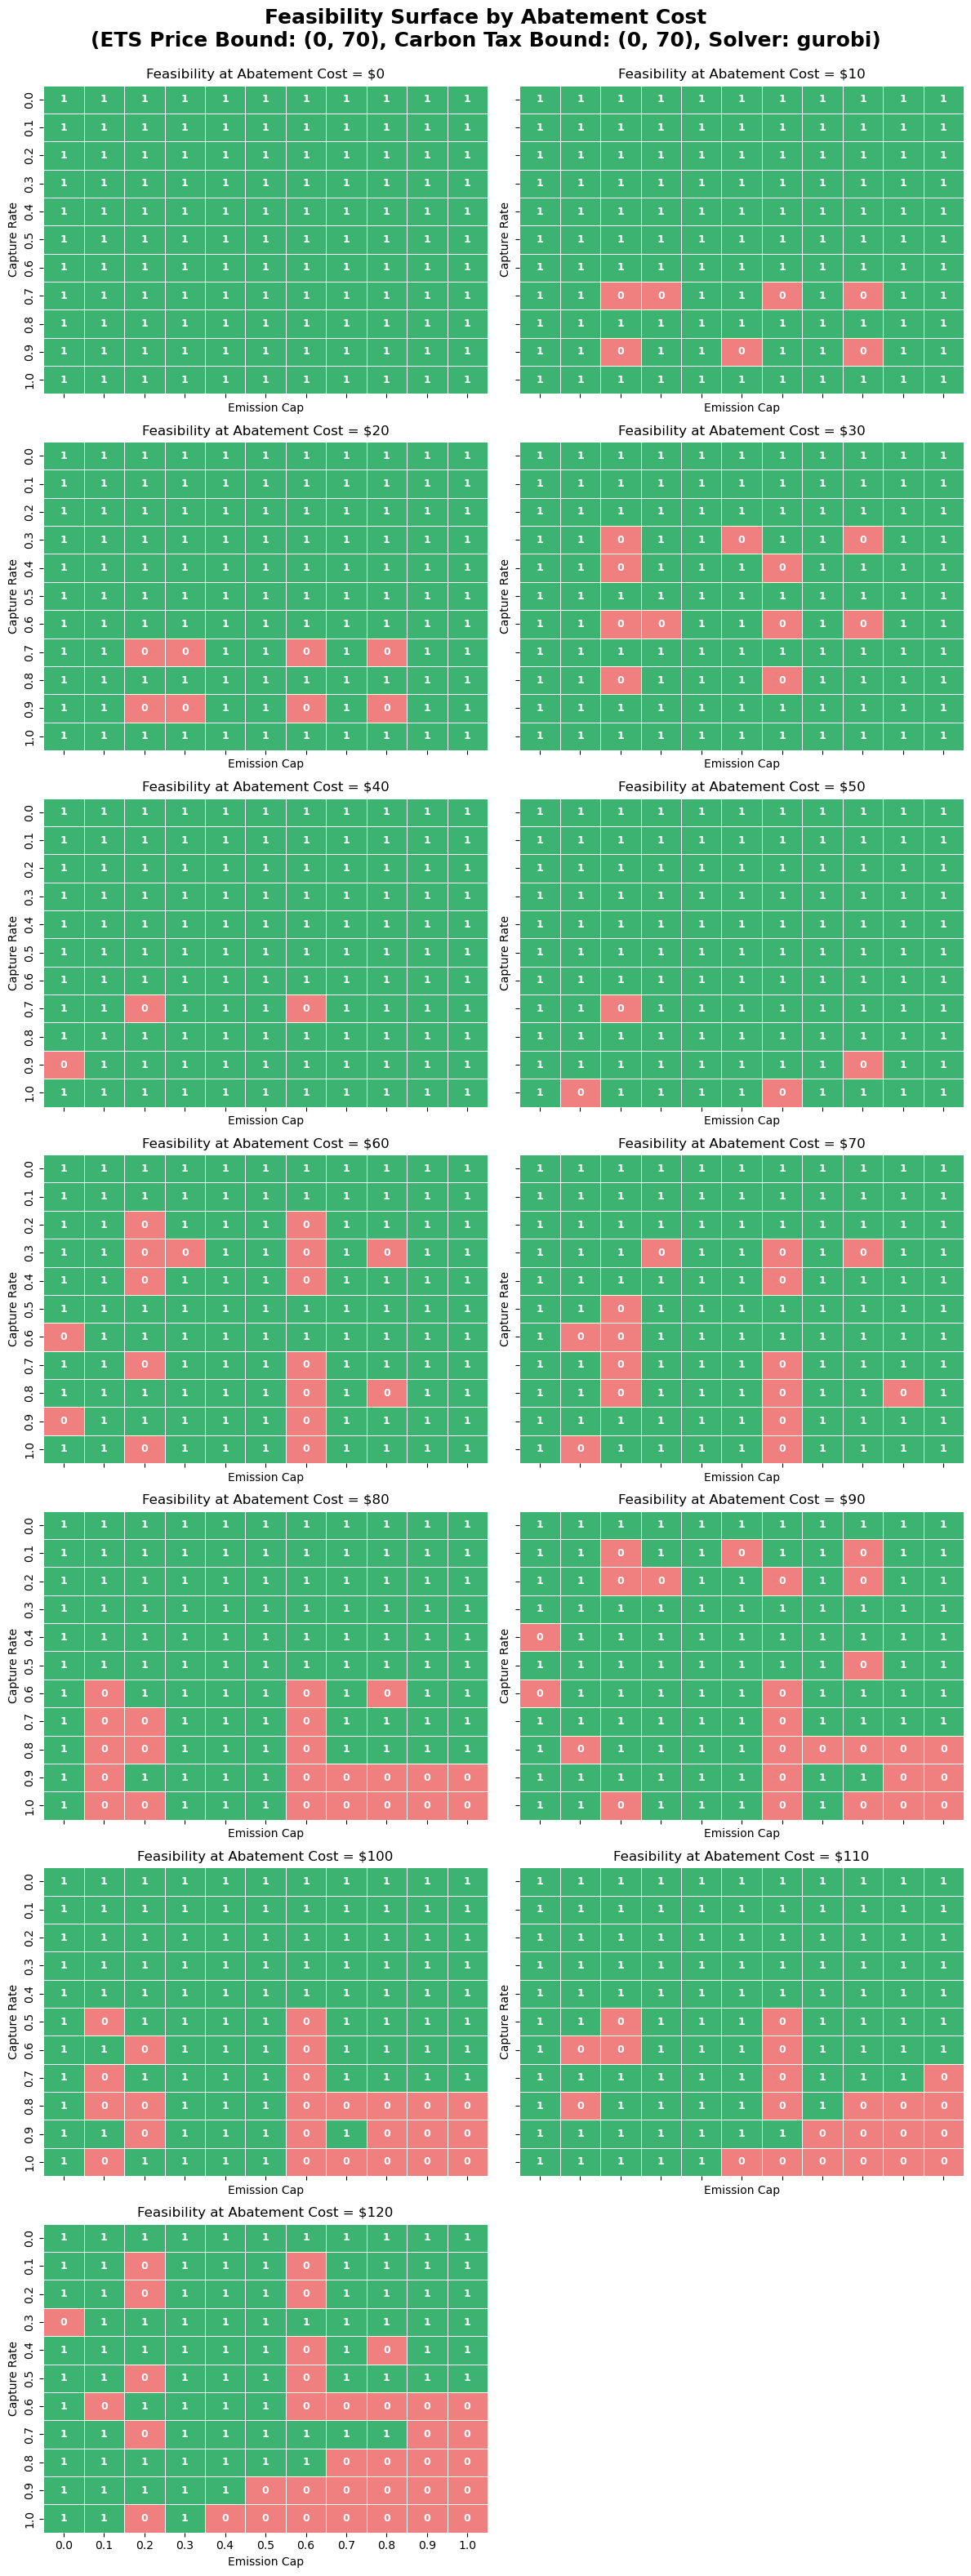

In [353]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

# Set these to your real abatement cost values:
abatement_cost_values = list(range(0, 121, 10))  # Or use your real range

ncols = 2
nrows = (len(abatement_cost_values) + ncols - 1) // ncols

# YOUR BOUNDARY SETTINGS
ets_price_bound = (0, 70)      # <--- SET THESE TO MATCH YOUR RUN!
carbon_tax_bound = (0, 70)     # <--- SET THESE TO MATCH YOUR RUN!
solver_used = "gurobi"          # Or "glpk" or whatever you used

# (rest of your plotting code...)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 4.5 * nrows), sharex=True, sharey=True)
axes = axes.flatten()

cmap = mcolors.ListedColormap(["lightcoral", "mediumseagreen"])
norm = mcolors.BoundaryNorm(boundaries=[-0.5, 0.5, 1.5], ncolors=2)

for i, fixed_cost in enumerate(abatement_cost_values):
    ax = axes[i]
    subset = results_csv[results_csv['AbatementCost'] == fixed_cost]
    pivot = subset.pivot(index='CaptureRate', columns='EmissionCap', values='Feasible')
    sns.heatmap(
        pivot, ax=ax, annot=True, fmt=".0f",
        cmap=cmap, norm=norm,
        cbar=False, linewidths=0.5, linecolor='white',
        annot_kws={"size": 9, "weight": "bold"}
    )
    ax.set_title(f"Feasibility at Abatement Cost = ${fixed_cost}")
    ax.set_xlabel("Emission Cap")
    ax.set_ylabel("Capture Rate")

# Hide any extra/empty subplot spaces
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()

# ---- ADD ANNOTATION ----
fig.suptitle(
    f"Feasibility Surface by Abatement Cost\n"
    f"(ETS Price Bound: {ets_price_bound}, Carbon Tax Bound: {carbon_tax_bound}, Solver: {solver_used})",
    fontsize=18, fontweight='bold', y=1.00
)
plt.subplots_adjust(top=0.97)  # Make space for supertitle

plt.show()


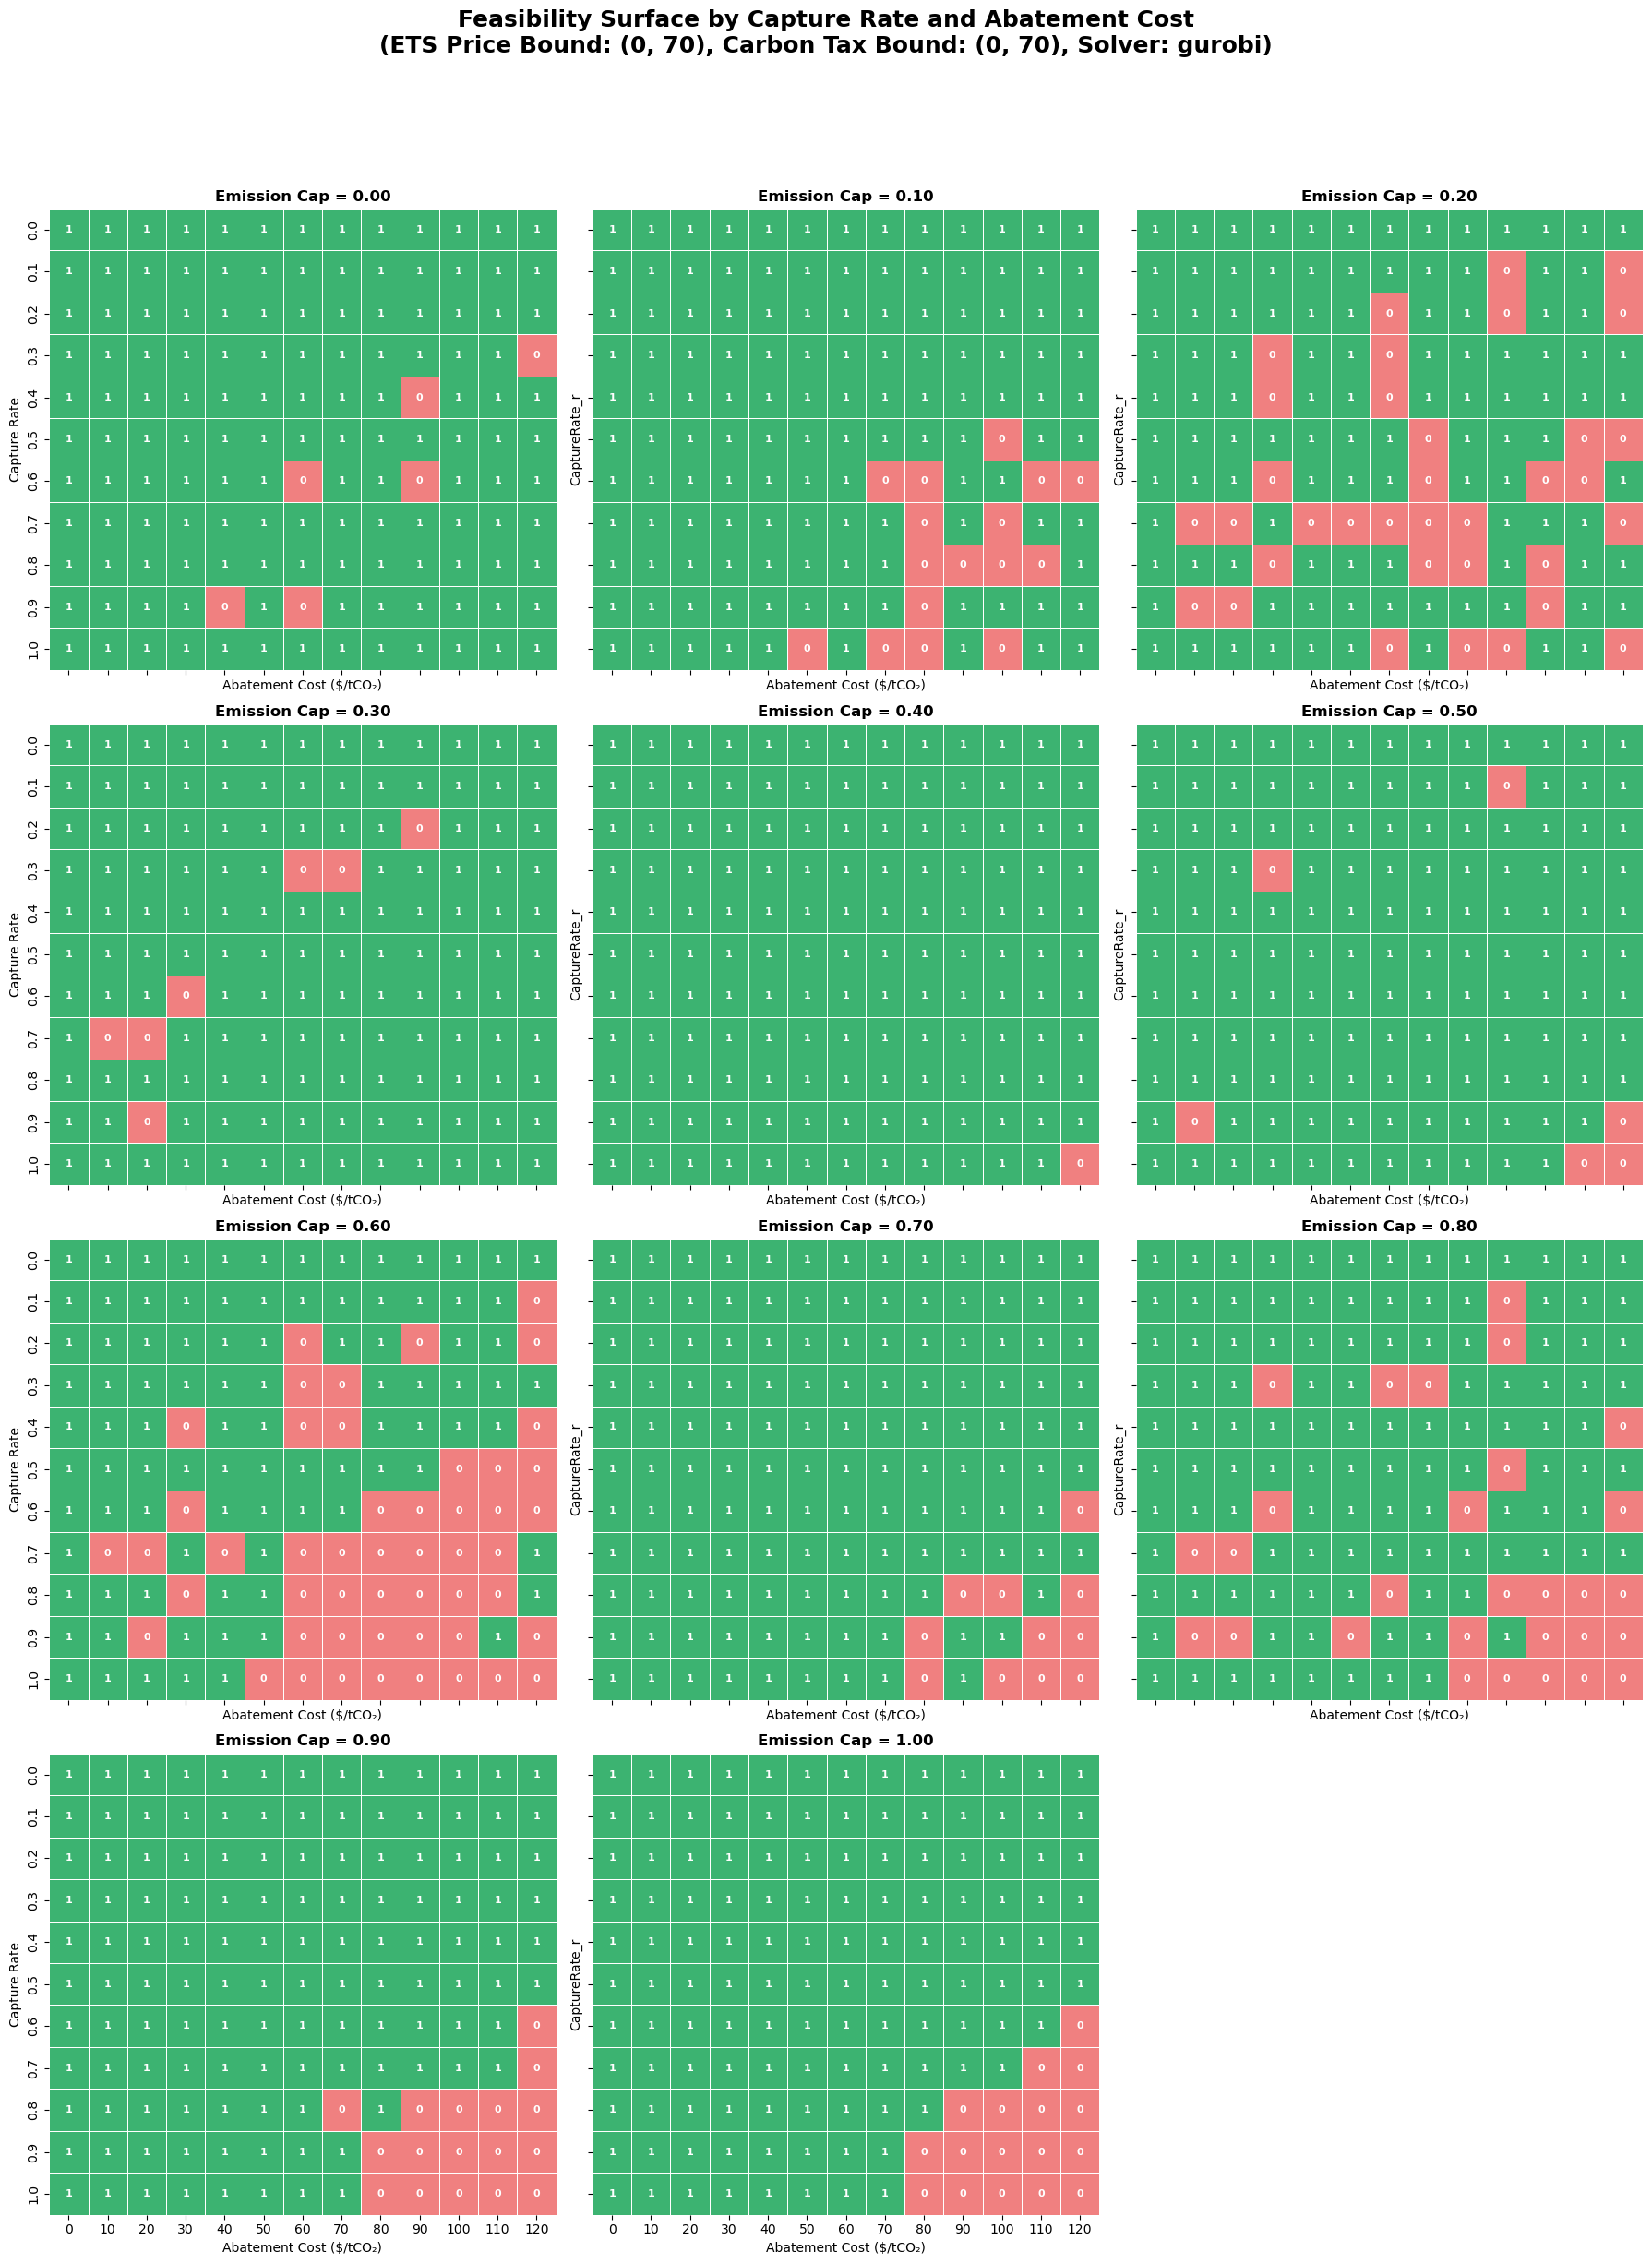

In [354]:
# === CaptureRate vs AbatementCost heatmaps for ALL fixed EmissionCap values ===

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from pathlib import Path
import math

# ---------- 0) Load data if needed ----------
if 'results_csv' not in globals():
    csv_path = Path('EmissionCap+CO2Capture+AbatementCost_sensitivity_results_wfunding.csv')
    results_csv = pd.read_csv(csv_path)

# ---------- 1) Clean & prepare ----------
# Ensure numeric types & round to avoid pivot gaps
for col in ['EmissionCap', 'CaptureRate', 'AbatementCost', 'Feasible']:
    results_csv[col] = pd.to_numeric(results_csv[col], errors='coerce')

results_csv['EmissionCap_r']   = results_csv['EmissionCap'].round(2)
results_csv['CaptureRate_r']   = results_csv['CaptureRate'].round(2)
results_csv['AbatementCost_r'] = results_csv['AbatementCost'].round(0)

# Get all unique emission caps sorted
caps_unique_sorted = np.sort(results_csv['EmissionCap_r'].dropna().unique())

# For reproducible axes across panels
cr_levels   = np.sort(results_csv['CaptureRate_r'].dropna().unique())
cost_levels = np.sort(results_csv['AbatementCost_r'].dropna().unique())

# ---------- 2) Plot ----------
nplots = len(caps_unique_sorted)
ncols = 3  # you can change this to adjust how many columns of plots
nrows = math.ceil(nplots / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 6*nrows), sharey=True, sharex=True)
axes = axes.flatten()

cmap = mcolors.ListedColormap(["lightcoral", "mediumseagreen"])
norm = mcolors.BoundaryNorm(boundaries=[-0.5, 0.5, 1.5], ncolors=2)

for i, cap in enumerate(caps_unique_sorted):
    ax = axes[i]
    sub = results_csv[results_csv['EmissionCap_r'] == cap].copy()

    # Build full grid
    grid = pd.MultiIndex.from_product([cr_levels, cost_levels], names=['CaptureRate_r', 'AbatementCost_r']).to_frame(index=False)
    sub_grid = grid.merge(sub[['CaptureRate_r','AbatementCost_r','Feasible']], 
                          on=['CaptureRate_r','AbatementCost_r'], how='left')

    piv = sub_grid.pivot(index='CaptureRate_r', columns='AbatementCost_r', values='Feasible')

    sns.heatmap(piv, ax=ax, annot=True, fmt='.0f', cmap=cmap, norm=norm, cbar=False,
                linewidths=0.5, linecolor='white',
                annot_kws={"size": 8, "weight": "bold"},
                xticklabels=True, yticklabels=True)

    ax.set_title(f"Emission Cap = {cap:.2f}", fontsize=12, fontweight='bold')
    if i % ncols == 0:
        ax.set_ylabel("Capture Rate")
    ax.set_xlabel("Abatement Cost ($/tCO₂)")

# Remove empty subplots
for j in range(nplots, len(axes)):
    fig.delaxes(axes[j])

# Overall title
ets_price_bound = (0, 70)
carbon_tax_bound = (0, 70)
solver_used = "gurobi"

fig.suptitle(
    f"Feasibility Surface by Capture Rate and Abatement Cost\n"
    f"(ETS Price Bound: {ets_price_bound}, Carbon Tax Bound: {carbon_tax_bound}, Solver: {solver_used})",
    fontsize=18, fontweight='bold', y=1.02
)

plt.tight_layout()
plt.subplots_adjust(top=0.93)

plt.show()


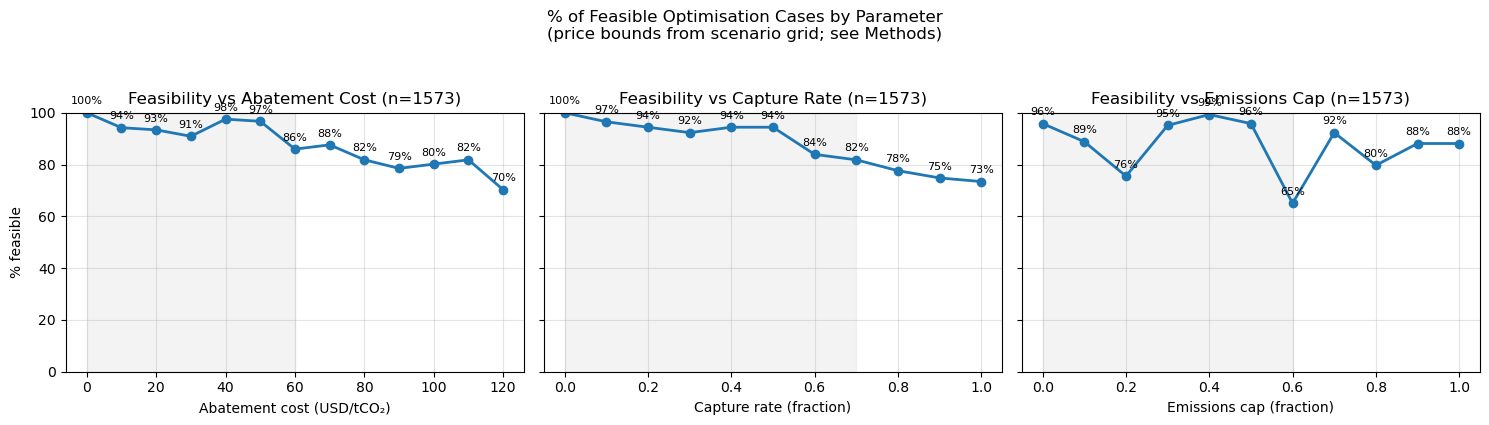

In [355]:
# === COMPACT 3-PANEL FIGURE: % FEASIBLE vs KEY PARAMETERS ====================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Expect `results_csv` to be present from earlier cells (heatmaps, etc.)
if 'results_csv' not in globals():
    raise RuntimeError("`results_csv` not found. Load or create it before running this cell.")

# --- Light prep --------------------------------------------------------------
# Coerce types and (if needed) infer Feasible from Status
for col in ['EmissionCap','CaptureRate','AbatementCost','Feasible']:
    if col in results_csv.columns:
        results_csv[col] = pd.to_numeric(results_csv[col], errors='coerce')
if 'Feasible' not in results_csv.columns and 'Status' in results_csv.columns:
    results_csv['Feasible'] = (results_csv['Status'].astype(str).str.lower()=='optimal').astype(int)
results_csv['Feasible'] = results_csv['Feasible'].fillna(0).astype(int)

# Rounded bins (consistent with your heatmap code)
if 'EmissionCap_r' not in results_csv.columns:
    results_csv['EmissionCap_r'] = results_csv['EmissionCap'].round(2)
if 'CaptureRate_r' not in results_csv.columns:
    results_csv['CaptureRate_r'] = results_csv['CaptureRate'].round(2)
if 'AbatementCost_r' not in results_csv.columns:
    results_csv['AbatementCost_r'] = results_csv['AbatementCost'].round(0)

def feasible_share_by(df, by_col):
    out = (df.groupby(by_col, dropna=False)['Feasible']
             .agg(feasible_share=lambda s: 100.0*s.mean(),
                  n_cases='count')
             .reset_index()
             .sort_values(by_col))
    return out

fs_cost = feasible_share_by(results_csv, 'AbatementCost_r')
fs_capt = feasible_share_by(results_csv, 'CaptureRate_r')
fs_cap  = feasible_share_by(results_csv, 'EmissionCap_r')

# --- Plot --------------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
panels = [
    (fs_cost, 'AbatementCost_r', 'Abatement cost (USD/tCO₂)',
     dict(safe=(0,60))),            # shade cost ≤ 60
    (fs_capt, 'CaptureRate_r', 'Capture rate (fraction)',
     dict(safe=(0,0.7))),           # shade capture ≤ 0.7
    (fs_cap,  'EmissionCap_r', 'Emissions cap (fraction)',
     dict(safe=(0,0.6)))            # shade cap ≤ 0.6
]

total_n = int(len(results_csv))

for ax, (tbl, xcol, xlabel, bands) in zip(axes, panels):
    # line
    ax.plot(tbl[xcol], tbl['feasible_share'], marker='o', linewidth=2)
    ax.set_ylim(0, 100)
    ax.grid(True, alpha=0.35)
    ax.set_xlabel(xlabel)
    # annotate each point with % value
    for x, y in zip(tbl[xcol], tbl['feasible_share']):
        ax.annotate(f"{y:.0f}%", (x, y), textcoords="offset points",
                    xytext=(0,6), ha='center', fontsize=8)
    # safe band shading (optional visual cue)
    if 'safe' in bands and bands['safe'] is not None:
        x0, x1 = bands['safe']
        ax.axvspan(x0, x1, color='lightgrey', alpha=0.25, zorder=0)

# Titles on each panel show total n=
axes[0].set_title(f"Feasibility vs Abatement Cost (n={total_n})")
axes[1].set_title(f"Feasibility vs Capture Rate (n={total_n})")
axes[2].set_title(f"Feasibility vs Emissions Cap (n={total_n})")

axes[0].set_ylabel('% feasible')

fig.suptitle('% of Feasible Optimisation Cases by Parameter\n'
             '(price bounds from scenario grid; see Methods)',
             y=1.05, fontsize=12)
plt.tight_layout()
plt.show()


## Infeasible scenario visualisation

In [356]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load your data
df = pd.read_csv("EmissionCap+CO2Capture+AbatementCost_sensitivity_results_wfunding.csv")

# Filter for infeasible cases only
infeasible_df = df[df["Feasible"] == False].copy()  # or (df["Feasible"] == 0) if int

# For plotting, fill NaN with 0 for stacking
infeasible_df["ETS_Income"] = infeasible_df["ETS_Income"].fillna(0)
infeasible_df["Tax_Income"] = infeasible_df["Tax_Income"].fillna(0)
infeasible_df["Funding_Gap"] = infeasible_df["Funding_Gap"].fillna(0)

# (Optional) Use an index of emission cap, capture rate, abatement cost for readability
infeasible_df["label"] = (
    "Ecap=" + infeasible_df["EmissionCap"].astype(str) +
    ", CR=" + infeasible_df["CaptureRate"].astype(str) +
    ", AC=" + infeasible_df["AbatementCost"].astype(str)
)

""" # If there are NO infeasible cases, handle gracefully
if infeasible_df.shape[0] == 0:
    print("No infeasible cases found. Nothing to plot.")
else:
    # Plot all infeasible cases
    fig, ax = plt.subplots(figsize=(16, max(6, len(infeasible_df) // 2)))
    bar_width = 0.7

    # Stacked bars: ETS, Carbon Tax, Gap
    p1 = ax.bar(infeasible_df["label"], infeasible_df["ETS_Income"], bar_width, label="ETS Income")
    p2 = ax.bar(infeasible_df["label"], infeasible_df["Tax_Income"], bar_width,
                bottom=infeasible_df["ETS_Income"], label="Carbon Tax Income")
    p3 = ax.bar(infeasible_df["label"],
                infeasible_df["Funding_Gap"], bar_width,
                bottom=infeasible_df["ETS_Income"] + infeasible_df["Tax_Income"],
                label="Funding Gap")

    ax.set_ylabel("USD ($)")
    ax.set_title("Funding Structure in Infeasible Scenarios (ALL)")
    ax.legend()
    plt.xticks(rotation=90, fontsize=8)
    plt.tight_layout()
    plt.show()

    # Plot top 20 by absolute funding gap
    top20 = infeasible_df.reindex(
        infeasible_df["Funding_Gap"].abs().sort_values(ascending=False).index[:20]
    )

    fig, ax = plt.subplots(figsize=(16, 6))
    p1 = ax.bar(top20["label"], top20["ETS_Income"], bar_width, label="ETS Income")
    p2 = ax.bar(top20["label"], top20["Tax_Income"], bar_width,
                bottom=top20["ETS_Income"], label="Carbon Tax Income")
    p3 = ax.bar(top20["label"],
                top20["Funding_Gap"], bar_width,
                bottom=top20["ETS_Income"] + top20["Tax_Income"],
                label="Funding Gap")

    ax.set_ylabel("USD ($)")
    ax.set_title("Funding Structure in Infeasible Scenarios (Top 20 by |Gap|)")
    ax.legend()
    plt.xticks(rotation=90, fontsize=8)
    plt.tight_layout()
    plt.show() """


' # If there are NO infeasible cases, handle gracefully\nif infeasible_df.shape[0] == 0:\n    print("No infeasible cases found. Nothing to plot.")\nelse:\n    # Plot all infeasible cases\n    fig, ax = plt.subplots(figsize=(16, max(6, len(infeasible_df) // 2)))\n    bar_width = 0.7\n\n    # Stacked bars: ETS, Carbon Tax, Gap\n    p1 = ax.bar(infeasible_df["label"], infeasible_df["ETS_Income"], bar_width, label="ETS Income")\n    p2 = ax.bar(infeasible_df["label"], infeasible_df["Tax_Income"], bar_width,\n                bottom=infeasible_df["ETS_Income"], label="Carbon Tax Income")\n    p3 = ax.bar(infeasible_df["label"],\n                infeasible_df["Funding_Gap"], bar_width,\n                bottom=infeasible_df["ETS_Income"] + infeasible_df["Tax_Income"],\n                label="Funding Gap")\n\n    ax.set_ylabel("USD ($)")\n    ax.set_title("Funding Structure in Infeasible Scenarios (ALL)")\n    ax.legend()\n    plt.xticks(rotation=90, fontsize=8)\n    plt.tight_layout()\n    plt

### Funding Gap Distribution (Histogram/Boxplot)

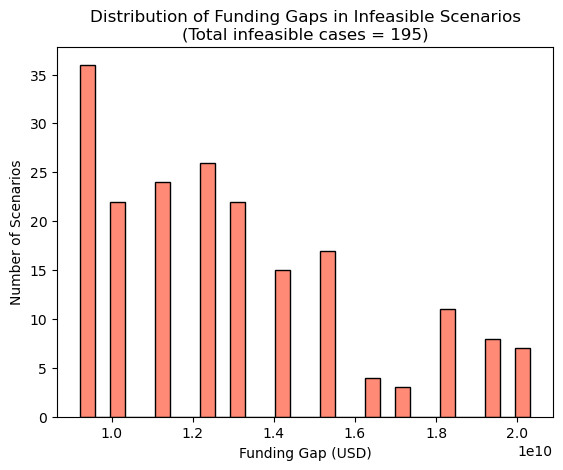

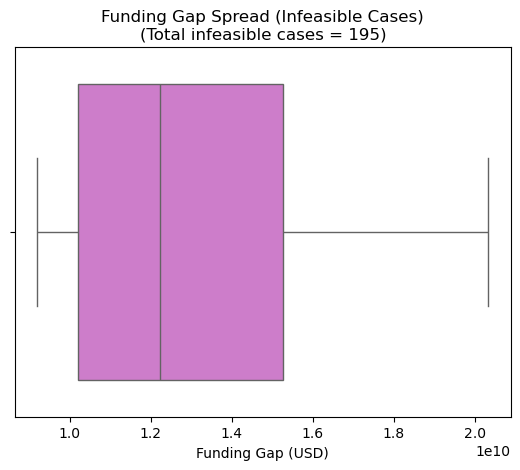

In [357]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate total infeasible cases with funding gap available
n_cases = infeasible_df["Funding_Gap"].dropna().shape[0]

# Funding gap distribution for infeasible
sns.histplot(infeasible_df["Funding_Gap"].dropna(), bins=30, color="tomato")
plt.title(f"Distribution of Funding Gaps in Infeasible Scenarios\n(Total infeasible cases = {n_cases})")
plt.xlabel("Funding Gap (USD)")
plt.ylabel("Number of Scenarios")
plt.show()

# Or, a boxplot for more compact summary:
sns.boxplot(x=infeasible_df["Funding_Gap"].dropna(), color="orchid")
plt.title(f"Funding Gap Spread (Infeasible Cases)\n(Total infeasible cases = {n_cases})")
plt.xlabel("Funding Gap (USD)")
plt.show()


### Heatmap of Parameter Sensitivity

### Scatter Plots for Outlier Diagnostics

### 1. Logistic Regression (Feasibility vs. Policy Levers)

In [358]:
import statsmodels.api as sm
import numpy as np
import pandas as pd

# Prepare predictors and target
X = results_csv[["EmissionCap", "CaptureRate", "AbatementCost"]]
y = results_csv["Feasible"]
X = sm.add_constant(X)

# Fit logistic regression
logit_model = sm.Logit(y, X).fit(disp=0)  # disp=0 for clean output

print("\n=== Logistic Regression (Feasibility) ===")
print(logit_model.summary())

# Odds ratios for interpretability
odds_ratios = pd.Series(np.exp(logit_model.params), index=logit_model.params.index)
print("\nOdds Ratios (Exp(Coeff)):\n", odds_ratios)

# ---- INTERPRETATION ----
print("""
How to interpret:
- Each coefficient shows how strongly that variable influences the chance of the model being feasible.
- An 'odds ratio' > 1 means that increasing this parameter increases feasibility. 
- An 'odds ratio' < 1 means that increasing this parameter makes feasibility less likely.
- The most statistically significant variables (smallest 'P>|z|' values) are the most important drivers.
""")



=== Logistic Regression (Feasibility) ===
                           Logit Regression Results                           
Dep. Variable:               Feasible   No. Observations:                 1573
Model:                          Logit   Df Residuals:                     1569
Method:                           MLE   Df Model:                            3
Date:                Wed, 03 Sep 2025   Pseudo R-squ.:                  0.1855
Time:                        14:26:05   Log-Likelihood:                -480.16
converged:                       True   LL-Null:                       -589.49
Covariance Type:            nonrobust   LLR p-value:                 3.917e-47
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             5.7935      0.360     16.110      0.000       5.089       6.498
EmissionCap      -0.6820      0.266     -2.566      0.010      -1.203      -0.1

### 2. Linear Regression (Funding Gap, Infeasible Cases)

In [359]:
from sklearn.linear_model import LinearRegression

# Focus on infeasible only, and drop NaNs
inf = infeasible_df.copy()
inf = inf.dropna(subset=['Funding_Gap'])

X_inf = inf[["EmissionCap", "CaptureRate", "AbatementCost"]]
y_inf = inf["Funding_Gap"]

reg = LinearRegression().fit(X_inf, y_inf)
print("\n=== Linear Regression (Boundary Funding Gap, Infeasible Only) ===")
for var, coef in zip(X_inf.columns, reg.coef_):
    print(f"{var}: {coef:.2e}")
print(f"Intercept: {reg.intercept_:.2e}")

# ---- INTERPRETATION ----
print("""
How to interpret:
- Each coefficient shows how a one-unit increase in a parameter (holding others constant) changes the predicted funding gap.
- Positive: Increasing this parameter makes the funding gap worse (i.e., harder to close).
- Negative: Increasing this parameter reduces the gap (i.e., easier to close).
- The largest (absolute) coefficients identify which policy levers most strongly affect the funding gap in infeasible cases.
""")



=== Linear Regression (Boundary Funding Gap, Infeasible Only) ===
EmissionCap: 4.23e-07
CaptureRate: -6.63e-06
AbatementCost: -1.01e+08
Intercept: 2.13e+10

How to interpret:
- Each coefficient shows how a one-unit increase in a parameter (holding others constant) changes the predicted funding gap.
- Positive: Increasing this parameter makes the funding gap worse (i.e., harder to close).
- Negative: Increasing this parameter reduces the gap (i.e., easier to close).
- The largest (absolute) coefficients identify which policy levers most strongly affect the funding gap in infeasible cases.



3. Random Forest Feature Importance (Nonlinear Effects)


=== Random Forest Feature Importances (Feasibility) ===
AbatementCost    0.348478
EmissionCap      0.329070
CaptureRate      0.322452
dtype: float64


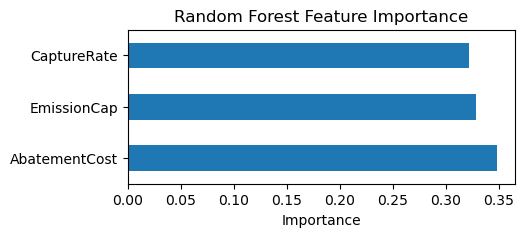


How to interpret:
- The higher the 'importance' score, the more that parameter matters for feasibility (even if the effect is nonlinear or involves interactions).
- The top feature(s) are the most effective levers for achieving feasibility across the scenarios.



In [360]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

X = results_csv[["EmissionCap", "CaptureRate", "AbatementCost"]]
y = results_csv["Feasible"]

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X, y)

importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)

print("\n=== Random Forest Feature Importances (Feasibility) ===")
print(feat_imp)

# Optional: Visualise
plt.figure(figsize=(5,2))
feat_imp.plot(kind="barh")
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance")
plt.show()

# ---- INTERPRETATION ----
print("""
How to interpret:
- The higher the 'importance' score, the more that parameter matters for feasibility (even if the effect is nonlinear or involves interactions).
- The top feature(s) are the most effective levers for achieving feasibility across the scenarios.
""")


### 4. Partial Dependence Plot (Visual Policy Sensitivity)

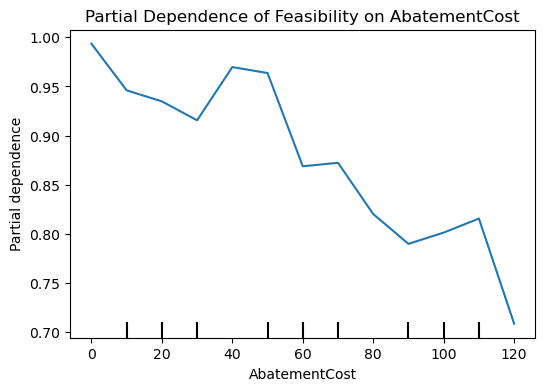


How to interpret:
- This plot shows the predicted probability of feasibility as the 'AbatementCost' variable increases, with all other variables averaged out.
- A sharp rise in the curve: this parameter has a strong positive effect.
- A flat or negative slope: little or negative effect.
- Use this to visually support recommendations about what parameter targets help most.



In [361]:
from sklearn.inspection import PartialDependenceDisplay

# For best clarity, pick the most important feature
most_important = feat_imp.index[0]

fig, ax = plt.subplots(figsize=(6, 4))
PartialDependenceDisplay.from_estimator(
    rf, X, [most_important], ax=ax,
    grid_resolution=30
)
plt.title(f"Partial Dependence of Feasibility on {most_important}")
plt.show()

# ---- INTERPRETATION ----
print(f"""
How to interpret:
- This plot shows the predicted probability of feasibility as the '{most_important}' variable increases, with all other variables averaged out.
- A sharp rise in the curve: this parameter has a strong positive effect.
- A flat or negative slope: little or negative effect.
- Use this to visually support recommendations about what parameter targets help most.
""")


### Optional: Partial Dependence for All Features

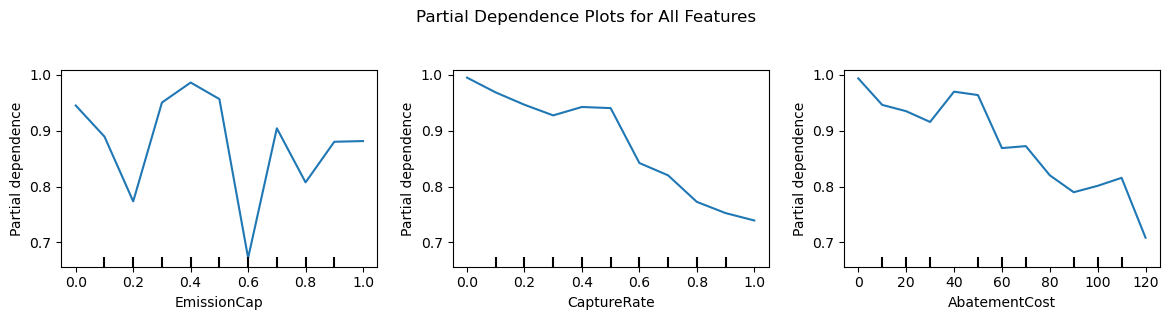


How to interpret:
- Each subplot shows the effect of a single parameter (holding the others constant) on the predicted chance of feasibility.
- Look for steep increases or sharp thresholds: these indicate effective intervention points.



In [362]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))
PartialDependenceDisplay.from_estimator(rf, X, X.columns.tolist(), ax=ax, grid_resolution=30)
plt.suptitle("Partial Dependence Plots for All Features", y=1.05)
plt.tight_layout()
plt.show()

print("""
How to interpret:
- Each subplot shows the effect of a single parameter (holding the others constant) on the predicted chance of feasibility.
- Look for steep increases or sharp thresholds: these indicate effective intervention points.
""")


## Sectoral Analysis - with Scenario Analysis Result

### A. Calculate Policy Payments by Sector for Each Scenario

Total Emissions and Plant Counts per Sector:
Ammonia: 3,408,147 tonnes CO2/year, 4 plants
Cement: 86,821,006 tonnes CO2/year, 125 plants
Iron_and_steel: 55,487,356 tonnes CO2/year, 9 plants
Refinery: 44,821,679 tonnes CO2/year, 30 plants


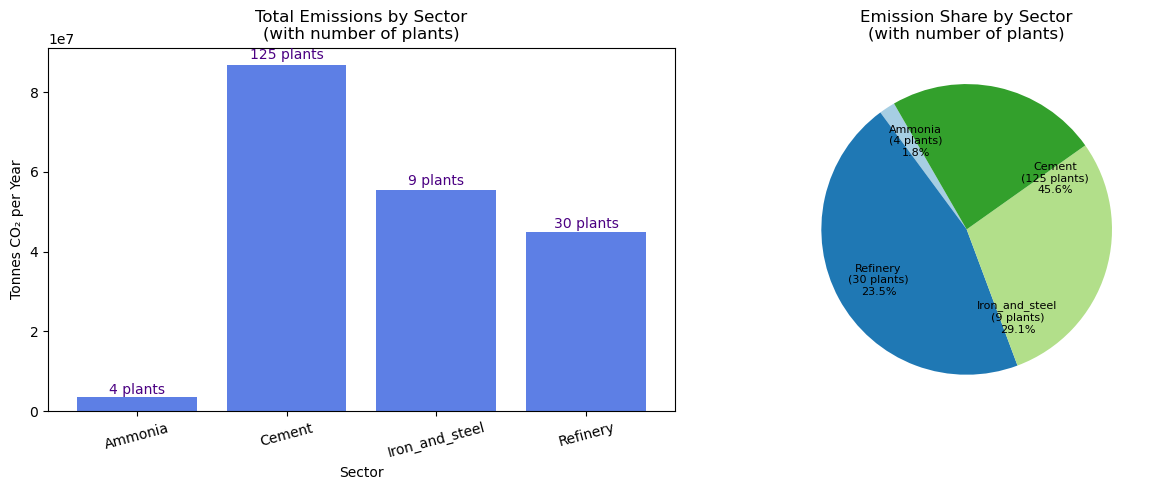

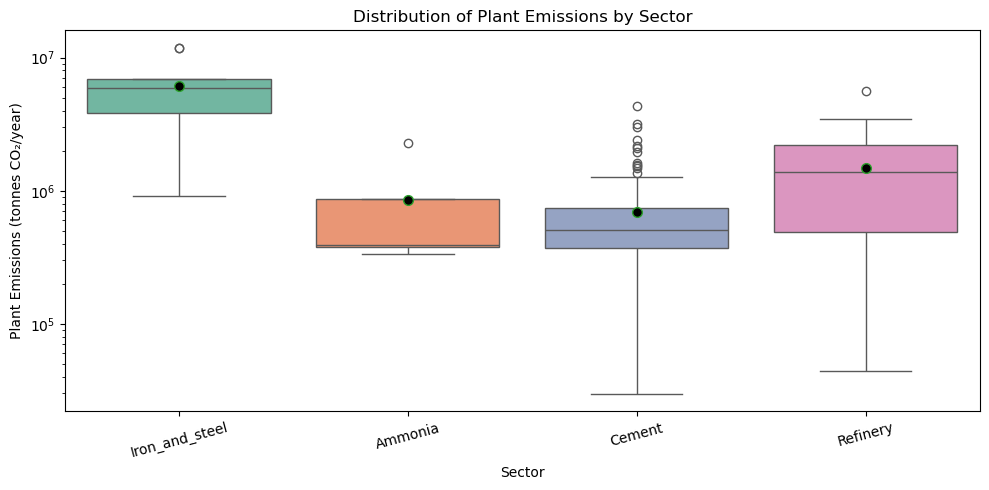

In [363]:
import matplotlib.pyplot as plt

# FIX: Only operate on the needed columns (no grouping columns)
sector_emissions = preview_df.groupby('Sector')[['Carbon_Intensity', 'Actual_Production']].apply(
    lambda df: (df['Carbon_Intensity'] * df['Actual_Production']).sum()
).to_dict()


# Calculate number of plants per sector
sector_plant_counts = preview_df.groupby('Sector')['Plant'].nunique().to_dict()

print("Total Emissions and Plant Counts per Sector:")
for sector in sector_emissions:
    print(f"{sector}: {sector_emissions[sector]:,.0f} tonnes CO2/year, "
          f"{sector_plant_counts[sector]} plants")

# Prepare data
sectors = list(sector_emissions.keys())
emissions = [sector_emissions[s] for s in sectors]
plant_counts = [sector_plant_counts[s] for s in sectors]

# Plot: Bar chart and Pie chart side by side
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# --- Bar Chart with emissions and plant count annotation ---
bars = axes[0].bar(sectors, emissions, color="royalblue", alpha=0.85)
axes[0].set_title("Total Emissions by Sector\n(with number of plants)")
axes[0].set_ylabel("Tonnes CO₂ per Year")
axes[0].set_xlabel("Sector")
axes[0].tick_params(axis='x', rotation=15)

# Annotate with number of plants
for bar, count in zip(bars, plant_counts):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2, height * 1.01,
                 f"{count} plants", ha='center', va='bottom', fontsize=10, color='indigo')

# --- Pie Chart with emissions and plant count annotation ---
def pie_label(sector, pct):
    idx = sectors.index(sector)
    count = plant_counts[idx]
    return f"{sector}\n({count} plants)\n{pct:.1f}%"

axes[1].pie(
    emissions, labels=None, autopct=None,
    startangle=120, colors=plt.cm.Paired.colors
)
# Add custom labels with plant counts and percentages
total = sum(emissions)
for i, (sector, val) in enumerate(zip(sectors, emissions)):
    pct = 100 * val / total
    axes[1].text(
        0.7 * np.cos(np.deg2rad(120 - i * 360 / len(sectors))),
        0.7 * np.sin(np.deg2rad(120 - i * 360 / len(sectors))),
        f"{sector}\n({plant_counts[i]} plants)\n{pct:.1f}%",
        ha='center', va='center', fontsize=8
    )
axes[1].set_title("Emission Share by Sector\n(with number of plants)")

plt.tight_layout()
plt.show()

# Make sure you have a "Plant_Emissions" column in your DataFrame
if "Plant_Emissions" not in preview_df.columns:
    preview_df["Plant_Emissions"] = preview_df["Carbon_Intensity"] * preview_df["Actual_Production"]

plt.figure(figsize=(10, 5))

sns.boxplot(
    x="Sector",
    y="Plant_Emissions",
    data=preview_df,
    hue="Sector",                # Adds color per sector
    palette="Set2",              # Use your preferred color palette
    showmeans=True,
    meanprops={"marker": "o", "markerfacecolor": "black", "markersize": 7}
)
plt.title("Distribution of Plant Emissions by Sector")
plt.ylabel("Plant Emissions (tonnes CO₂/year)")
plt.xlabel("Sector")
plt.yscale('log')  # Log scale for clarity if large spread
plt.xticks(rotation=15)
plt.legend([],[], frameon=False)  # Hides the redundant legend
plt.tight_layout()
plt.show()



## Sectorial Abatement Cost data

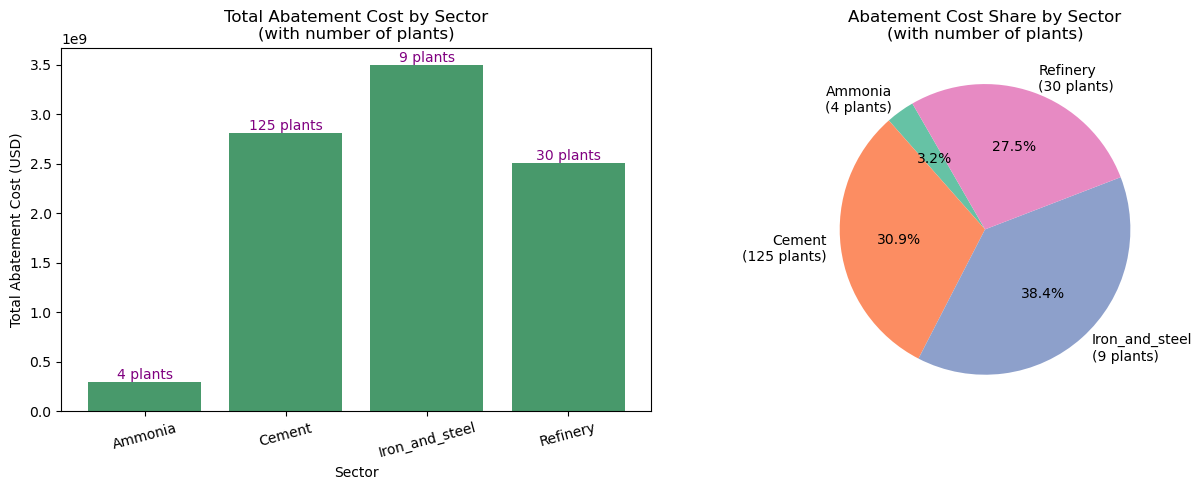

C:\Users\Keerati\AppData\Local\Temp\ipykernel_30108\2891625389.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=preview_df, x='Sector', y='Abate_Cost', palette="Set2")


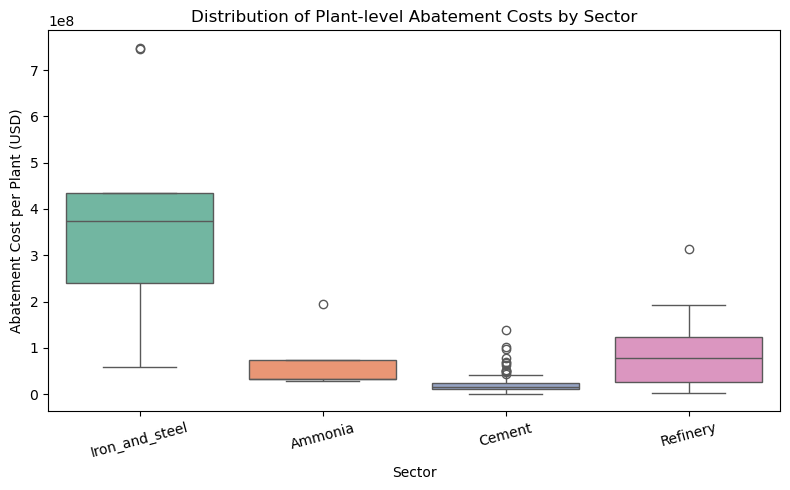

In [364]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Compute plant-level and sector-level abatement cost
preview_df['Abate_Cost'] = (
    preview_df['Abatement_Cost'] *
    preview_df['Carbon_Intensity'] *
    preview_df['Actual_Production'] *
    preview_df['CO2_Capture']
)
sector_abate_cost = preview_df.groupby('Sector')['Abate_Cost'].sum()
plant_counts = preview_df['Sector'].value_counts().reindex(sector_abate_cost.index)

# Labels with plant counts for bar and pie
sectors = sector_abate_cost.index.tolist()
plant_n = [plant_counts[s] for s in sectors]
bar_labels = [f"{s}\n({n} plants)" for s, n in zip(sectors, plant_n)]
pie_labels = [f"{s}\n({n} plants)" for s, n in zip(sectors, plant_n)]

# 2. Plot Bar + Pie
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# --- Bar Chart ---
bars = axes[0].bar(sectors, sector_abate_cost.values, color="seagreen", alpha=0.88)
axes[0].set_title("Total Abatement Cost by Sector\n(with number of plants)")
axes[0].set_ylabel("Total Abatement Cost (USD)")
axes[0].set_xlabel("Sector")
axes[0].tick_params(axis='x', rotation=15)
for i, bar in enumerate(bars):
    axes[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
                 f"{plant_n[i]} plants", ha='center', va='bottom', color='purple', fontsize=10)

# --- Pie Chart ---
axes[1].pie(sector_abate_cost.values, labels=pie_labels, autopct='%1.1f%%', startangle=120, colors=plt.cm.Set2.colors)
axes[1].set_title("Abatement Cost Share by Sector\n(with number of plants)")

plt.tight_layout()
plt.show()

# 3. Boxplot: Plant Abatement Cost per Sector
plt.figure(figsize=(8, 5))
sns.boxplot(data=preview_df, x='Sector', y='Abate_Cost', palette="Set2")
plt.title("Distribution of Plant-level Abatement Costs by Sector")
plt.ylabel("Abatement Cost per Plant (USD)")
plt.xlabel("Sector")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


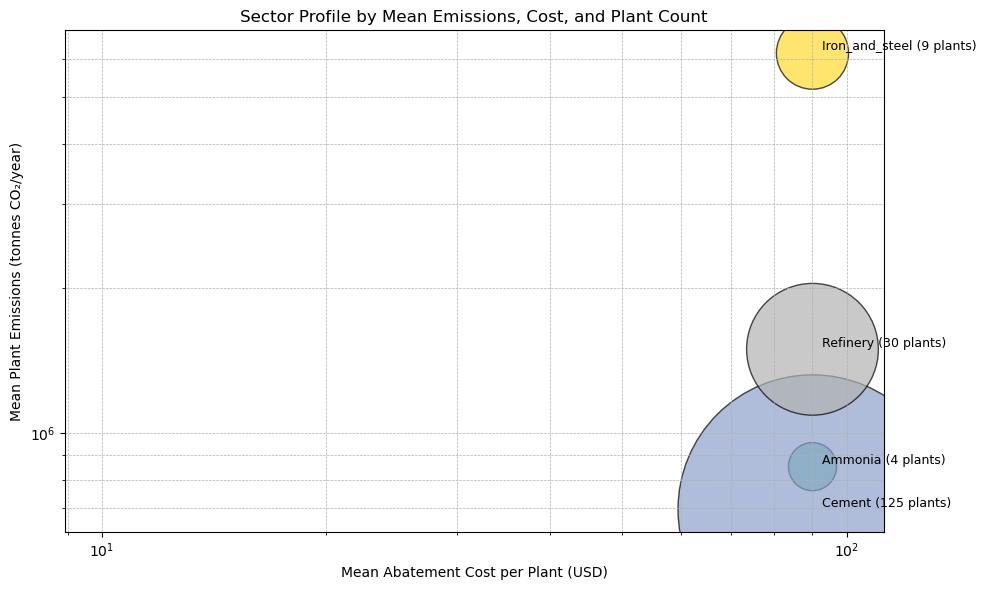

In [365]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Calculate required metrics
sector_stats = preview_df.groupby("Sector").agg({
    "Plant": "nunique",
    "Abatement_Cost": "mean",
    "Plant_Emissions": "mean"
}).rename(columns={
    "Plant": "Plant_Count",
    "Abatement_Cost": "Mean_Abatement_Cost",
    "Plant_Emissions": "Mean_Emissions"
}).reset_index()

# Bubble sizes
bubble_scale = 300  # Adjust if bubbles are too big/small
sizes = sector_stats["Plant_Count"] * bubble_scale

# Color mapping
colors = plt.cm.Set2(np.linspace(0, 1, len(sector_stats)))

# Plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    sector_stats["Mean_Abatement_Cost"],
    sector_stats["Mean_Emissions"],
    s=sizes,
    c=colors,
    alpha=0.7,
    edgecolor="black"
)

# Label each bubble
for i, row in sector_stats.iterrows():
    plt.text(
        row["Mean_Abatement_Cost"] * 1.03,
        row["Mean_Emissions"] * 1.03,
        f"{row['Sector']} ({row['Plant_Count']} plants)",
        fontsize=9,
        ha='left',
        va='center'
    )

# Axis formatting
plt.xlabel("Mean Abatement Cost per Plant (USD)")
plt.ylabel("Mean Plant Emissions (tonnes CO₂/year)")
plt.yscale("log")
plt.xscale("log")
plt.title("Sector Profile by Mean Emissions, Cost, and Plant Count")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()


### Step A.2: For each scenario in results_df, compute tax paid per sector

In [366]:
# For all scenarios, create per-sector tax paid

# Get the unique values of 'Sector' column
unique_values = preview_df['Sector'].unique()

for sector in unique_values:
    colname = f'Carbon Tax [{sector}]'
    results_df[f'TaxPaid_{sector}'] = results_df[colname] * sector_emissions[sector]


results_df.head()

ETS_Cap  Tax_Cap      Status  Funding Gap  ETS Price  \
0        0        0  infeasible          NaN        NaN   
1        0       10  infeasible          NaN        NaN   
2        0       20  infeasible          NaN        NaN   
3        0       30  infeasible          NaN        NaN   
4        0       40  infeasible          NaN        NaN   

   Carbon Tax [Iron_and_steel]  Carbon Tax [Ammonia]  Carbon Tax [Cement]  \
0                          NaN                   NaN                  NaN   
1                          NaN                   NaN                  NaN   
2                          NaN                   NaN                  NaN   
3                          NaN                   NaN                  NaN   
4                          NaN                   NaN                  NaN   

   Carbon Tax [Refinery]    Gap at cap  ETS at cap  \
0                    NaN -9.099310e+09         0.0   
1                    NaN -7.193928e+09         0.0   
2                    NaN -5.288546e+09         0.0   
3                    NaN -3.383164e+09         0.0   
4                    NaN -1.477782e+09         0.0   

   Tax at cap [Iron_and_steel]  Tax at cap [Ammonia]  Tax at cap [Cement]  \
0                          0.0                   0.0                  0.0   
1                         10.0                  10.0                 10.0   
2                         20.0                  20.0                 20.0   
3                         30.0                  30.0                 30.0   
4                         40.0                  40.0                 40.0   

   Tax at cap [Refinery]  TaxPaid_Iron_and_steel  TaxPaid_Ammonia  \
0                    0.0                     NaN              NaN   
1                   10.0                     NaN              NaN   
2                   20.0                     NaN              NaN   
3                   30.0                     NaN              NaN   
4                   40.0                     NaN              NaN   

   TaxPaid_Cement  TaxPaid_Refinery  
0             NaN               NaN  
1             NaN               NaN  
2             NaN               NaN  
3             NaN               NaN  
4             NaN               NaN

### B. Aggregate Across All Scenarios
For example, total tax paid per sector (across all scenarios):

In [367]:
sector_tax_cols = [f'TaxPaid_{sector}' for sector in unique_values]

# Melt the DataFrame to long format for easier plotting/analysis
tax_paid_long = results_df.melt(
    id_vars=['ETS_Cap', 'Tax_Cap', 'Funding Gap'],
    value_vars=sector_tax_cols,
    var_name='Sector',
    value_name='TaxPaid'
)
# Extract the clean sector name
tax_paid_long['Sector'] = tax_paid_long['Sector'].str.replace('TaxPaid_', '')

# Now you can group by Sector and compute statistics
summary = tax_paid_long.groupby('Sector').agg(
    total_tax_paid=('TaxPaid', 'sum'),
    mean_tax_paid=('TaxPaid', 'mean'),
    median_tax_paid=('TaxPaid', 'median'),
    max_tax_paid=('TaxPaid', 'max'),
    min_tax_paid=('TaxPaid', 'min')
).reset_index()

print(summary)


           Sector  total_tax_paid  mean_tax_paid  median_tax_paid  \
0         Ammonia    1.383708e+10   1.441362e+08     1.533666e+08   
1          Cement    1.153838e+11   1.201915e+09     0.000000e+00   
2  Iron_and_steel    2.132175e+11   2.221016e+09     2.496931e+09   
3        Refinery    1.819760e+11   1.895584e+09     2.016976e+09   

   max_tax_paid  min_tax_paid  
0  3.408147e+08           0.0  
1  3.913451e+09           0.0  
2  4.758626e+09           0.0  
3  4.482168e+09           0.0  


### C. Visualization Example (Boxplot of Tax Paid per Sector)

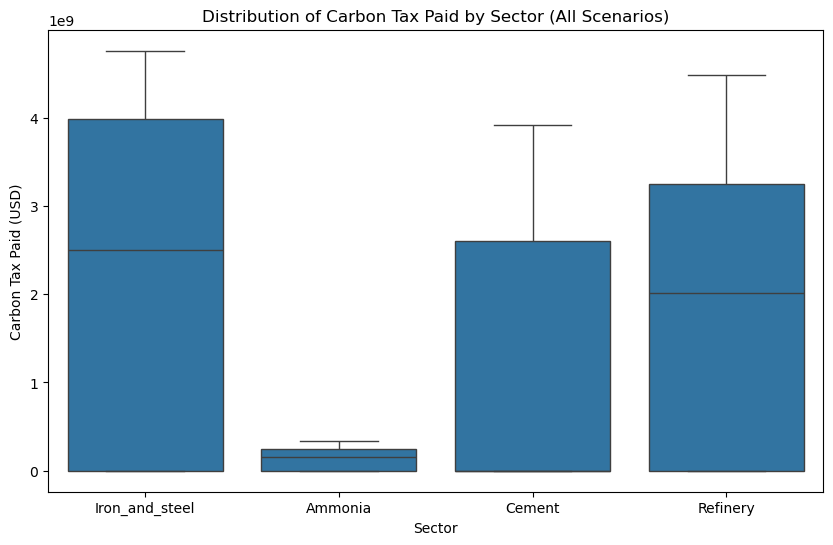

In [368]:
import seaborn as sns
import matplotlib.pyplot as plt

# Boxplot: All scenarios (original)
plt.figure(figsize=(10,6))
sns.boxplot(data=tax_paid_long, x='Sector', y='TaxPaid')
plt.title('Distribution of Carbon Tax Paid by Sector (All Scenarios)')
plt.ylabel('Carbon Tax Paid (USD)')
plt.xlabel('Sector')
plt.show()



## Identify 'The most affordable, feasible' Scenarios

In [369]:
""" import numpy as np

### 1. Filter Feasible Scenarios
# Adjust as needed for your column
feasible_df = results_df[results_df['Status'] == 'optimal'].copy()
print("Scenarios considered feasible:", len(feasible_df))

sector_names = ['Iron_and_steel', 'Ammonia', 'Cement', 'Refinery']

### 2. Compute Total Policy Paid by Each Sector in Each Scenario
def sector_policy_paid(row, sector_name, preview_df):
    # Safely get values or set to 0 if NaN
    ets_price = row.get('ETS Price', 0) if not np.isnan(row.get('ETS Price', np.nan)) else 0
    tax = row.get(f'Carbon Tax [{sector_name}]', 0) if not np.isnan(row.get(f'Carbon Tax [{sector_name}]', np.nan)) else 0

    sector_plants = preview_df[preview_df['Sector'] == sector_name]
    # If sector_plants is empty, skip
    if sector_plants.empty:
        return 0

    # ETS paid
    ets_paid = ets_price * (sector_plants['Carbon_Intensity'] * sector_plants['Actual_Production'] * (1 - sector_plants['Emission_Cap'])).sum()
    # Tax paid
    tax_paid = tax * (sector_plants['Carbon_Intensity'] * sector_plants['Actual_Production'] * sector_plants['Jurisdiction_GHG']).sum()
    return ets_paid + tax_paid

# Calculate for all sectors and cache in feasible_df
for sector in sector_names:
    feasible_df[f'TotalPolicyPaid_{sector}'] = feasible_df.apply(lambda row: sector_policy_paid(row, sector, preview_df), axis=1)

### 3. For Each Sector, Find Scenario with Minimum Cost
print("\n--- Cheapest Feasible Scenario for Each Sector ---")
min_scenarios = {}
for sector in sector_names:
    col = f'TotalPolicyPaid_{sector}'
    sector_valid = feasible_df[feasible_df[col].notnull() & (feasible_df[col] > 0)]
    if not sector_valid.empty:
        idx = sector_valid[col].idxmin()
        min_scenarios[sector] = feasible_df.loc[idx]
        print(f"Sector: {sector}")
        print(min_scenarios[sector][['ETS_Cap', 'Tax_Cap', 'ETS Price', f'Carbon Tax [{sector}]', col]])
        print("-" * 40)
    else:
        print(f"Sector: {sector} - No valid scenarios found.")
        print("-" * 40)

# Diagnostic check: number of scenarios per sector
for col in [f'TotalPolicyPaid_{s}' for s in sector_names]:
    print(f"{col}: not null = {feasible_df[col].notnull().sum()}, > 0 = {(feasible_df[col] > 0).sum()}")

### 4. Minimum Cost for All Sectors
feasible_df['TotalPolicyPaid_All'] = feasible_df[[f'TotalPolicyPaid_{s}' for s in sector_names]].sum(axis=1)
# Only consider if at least one sector pays something
valid_all = feasible_df[feasible_df['TotalPolicyPaid_All'] > 0]
if not valid_all.empty:
    idx_all = valid_all['TotalPolicyPaid_All'].idxmin()
    best_overall = feasible_df.loc[idx_all]
    print("\nBest Overall Scenario (min total policy paid by all sectors):")
    print(best_overall[['ETS_Cap', 'Tax_Cap', 'ETS Price'] +
                       [f'Carbon Tax [{s}]' for s in sector_names] +
                       ['TotalPolicyPaid_All']])
else:
    print("\nNo valid overall scenario found (no total policy payment > 0).")
 """

' import numpy as np\n\n### 1. Filter Feasible Scenarios\n# Adjust as needed for your column\nfeasible_df = results_df[results_df[\'Status\'] == \'optimal\'].copy()\nprint("Scenarios considered feasible:", len(feasible_df))\n\nsector_names = [\'Iron_and_steel\', \'Ammonia\', \'Cement\', \'Refinery\']\n\n### 2. Compute Total Policy Paid by Each Sector in Each Scenario\ndef sector_policy_paid(row, sector_name, preview_df):\n    # Safely get values or set to 0 if NaN\n    ets_price = row.get(\'ETS Price\', 0) if not np.isnan(row.get(\'ETS Price\', np.nan)) else 0\n    tax = row.get(f\'Carbon Tax [{sector_name}]\', 0) if not np.isnan(row.get(f\'Carbon Tax [{sector_name}]\', np.nan)) else 0\n\n    sector_plants = preview_df[preview_df[\'Sector\'] == sector_name]\n    # If sector_plants is empty, skip\n    if sector_plants.empty:\n        return 0\n\n    # ETS paid\n    ets_paid = ets_price * (sector_plants[\'Carbon_Intensity\'] * sector_plants[\'Actual_Production\'] * (1 - sector_plants[\'E

In [370]:
import numpy as np

### 1. Filter Feasible Scenarios
feasible_df = results_df[results_df['Status'] == 'optimal'].copy()
print("Scenarios considered feasible:", len(feasible_df))

sector_names = ['Iron_and_steel', 'Ammonia', 'Cement', 'Refinery']

### 2. Compute Total Policy Paid by Each Sector in Each Scenario
def sector_policy_paid(row, sector_name, preview_df):
    ets_price = row.get('ETS Price', 0) if not np.isnan(row.get('ETS Price', np.nan)) else 0
    tax = row.get(f'Carbon Tax [{sector_name}]', 0) if not np.isnan(row.get(f'Carbon Tax [{sector_name}]', np.nan)) else 0
    sector_plants = preview_df[preview_df['Sector'] == sector_name]
    if sector_plants.empty:
        return 0
    ets_paid = ets_price * (sector_plants['Carbon_Intensity'] * sector_plants['Actual_Production'] * (1 - sector_plants['Emission_Cap'])).sum()
    tax_paid = tax * (sector_plants['Carbon_Intensity'] * sector_plants['Actual_Production'] * sector_plants['Jurisdiction_GHG']).sum()
    return ets_paid + tax_paid

# Calculate total policy paid by sector for each scenario
for sector in sector_names:
    feasible_df[f'TotalPolicyPaid_{sector}'] = feasible_df.apply(lambda row: sector_policy_paid(row, sector, preview_df), axis=1)

### 3. For Each Sector, Find Scenario with Minimum Cost
print("\n--- Cheapest Feasible Scenario for Each Sector ---")
min_scenarios = {}
sector_min_payments = {}
sector_min_idxs = {}
for sector in sector_names:
    col = f'TotalPolicyPaid_{sector}'
    # Only consider scenarios where the payment is positive and not null
    sector_valid = feasible_df[feasible_df[col].notnull() & (feasible_df[col] >= 0)]
    if not sector_valid.empty:
        idx = sector_valid[col].idxmin()
        min_row = sector_valid.loc[idx]
        min_scenarios[sector] = min_row
        sector_min_payments[sector] = min_row[col]
        sector_min_idxs[sector] = idx
        print(f"Sector: {sector}")
        print(min_row[['ETS_Cap', 'Tax_Cap', 'ETS Price', f'Carbon Tax [{sector}]', col]])
        print(f"Scenario index: {idx}")
        print("-" * 40)
    else:
        print(f"Sector: {sector} - No valid scenarios found.")
        print("-" * 40)

# Diagnostic check: number of scenarios per sector
for col in [f'TotalPolicyPaid_{s}' for s in sector_names]:
    print(f"{col}: not null = {feasible_df[col].notnull().sum()}, > 0 = {(feasible_df[col] > 0).sum()}")

### 4. Minimum Cost for All Sectors (Best Overall)
feasible_df['TotalPolicyPaid_All'] = feasible_df[[f'TotalPolicyPaid_{s}' for s in sector_names]].sum(axis=1)
valid_all = feasible_df[feasible_df['TotalPolicyPaid_All'] >= 0]
if not valid_all.empty:
    idx_all = valid_all['TotalPolicyPaid_All'].idxmin()
    best_overall = valid_all.loc[idx_all]
    print("\nBest Overall Scenario (min total policy paid by all sectors):")
    print(best_overall[['ETS_Cap', 'Tax_Cap', 'ETS Price'] +
                       [f'Carbon Tax [{s}]' for s in sector_names] +
                       ['TotalPolicyPaid_All']])
    print(f"Scenario index: {idx_all}")
else:
    print("\nNo valid overall scenario found (no total policy payment > 0).")

### 5. Cross-check: Per-sector minimum should not exceed 'best overall'
print("\n--- Sector Minimum vs. Joint Minimum Check ---")
for sector in sector_names:
    sector_col = f"TotalPolicyPaid_{sector}"
    min_payment = sector_min_payments.get(sector, None)
    joint_payment = best_overall.get(sector_col, None)
    print(f"{sector}: Per-sector minimum = {min_payment:,.2f}, In best overall = {joint_payment:,.2f}, Diff = {min_payment - joint_payment:,.2f}")


Scenarios considered feasible: 96

--- Cheapest Feasible Scenario for Each Sector ---
Sector: Iron_and_steel
ETS_Cap                                          30
Tax_Cap                                          30
ETS Price                                 29.593055
Carbon Tax [Iron_and_steel]                    30.0
TotalPolicyPaid_Iron_and_steel    2649844921.848428
Name: 36, dtype: object
Scenario index: 36
----------------------------------------
Sector: Ammonia
ETS_Cap                                 30
Tax_Cap                                 30
ETS Price                        29.593055
Carbon Tax [Ammonia]                  30.0
TotalPolicyPaid_Ammonia    162758920.03785
Name: 36, dtype: object
Scenario index: 36
----------------------------------------
Sector: Cement
ETS_Cap                     0
Tax_Cap                    90
ETS Price                 0.0
Carbon Tax [Cement]       0.0
TotalPolicyPaid_Cement    0.0
Name: 9, dtype: object
Scenario index: 9
--------------------------

  ## Result Visualisation  

### 1. Bar Chart: Minimum Total Policy Paid per Sector

In [371]:
for sector in sector_names:
    col = f'TotalPolicyPaid_{sector}'
    # Allow zero payment (>= 0, not just > 0)
    sector_valid = feasible_df[feasible_df[col].notnull() & (feasible_df[col] >= 0)]
    if not sector_valid.empty:
        idx = sector_valid[col].idxmin()
        min_row = sector_valid.loc[idx]
        min_scenarios[sector] = min_row
        sector_min_payments[sector] = min_row[col]
        sector_min_idxs[sector] = idx
        print(f"Sector: {sector}")
        print(min_row[['ETS_Cap', 'Tax_Cap', 'ETS Price', f'Carbon Tax [{sector}]', col]])
        print(f"Scenario index: {idx}")
        print("-" * 40)
    else:
        print(f"Sector: {sector} - No valid scenarios found.")
        print("-" * 40)


Sector: Iron_and_steel
ETS_Cap                                          30
Tax_Cap                                          30
ETS Price                                 29.593055
Carbon Tax [Iron_and_steel]                    30.0
TotalPolicyPaid_Iron_and_steel    2649844921.848428
Name: 36, dtype: object
Scenario index: 36
----------------------------------------
Sector: Ammonia
ETS_Cap                                 30
Tax_Cap                                 30
ETS Price                        29.593055
Carbon Tax [Ammonia]                  30.0
TotalPolicyPaid_Ammonia    162758920.03785
Name: 36, dtype: object
Scenario index: 36
----------------------------------------
Sector: Cement
ETS_Cap                     0
Tax_Cap                    90
ETS Price                 0.0
Carbon Tax [Cement]       0.0
TotalPolicyPaid_Cement    0.0
Name: 9, dtype: object
Scenario index: 9
----------------------------------------
Sector: Refinery
ETS_Cap                                    30
Tax_Cap 

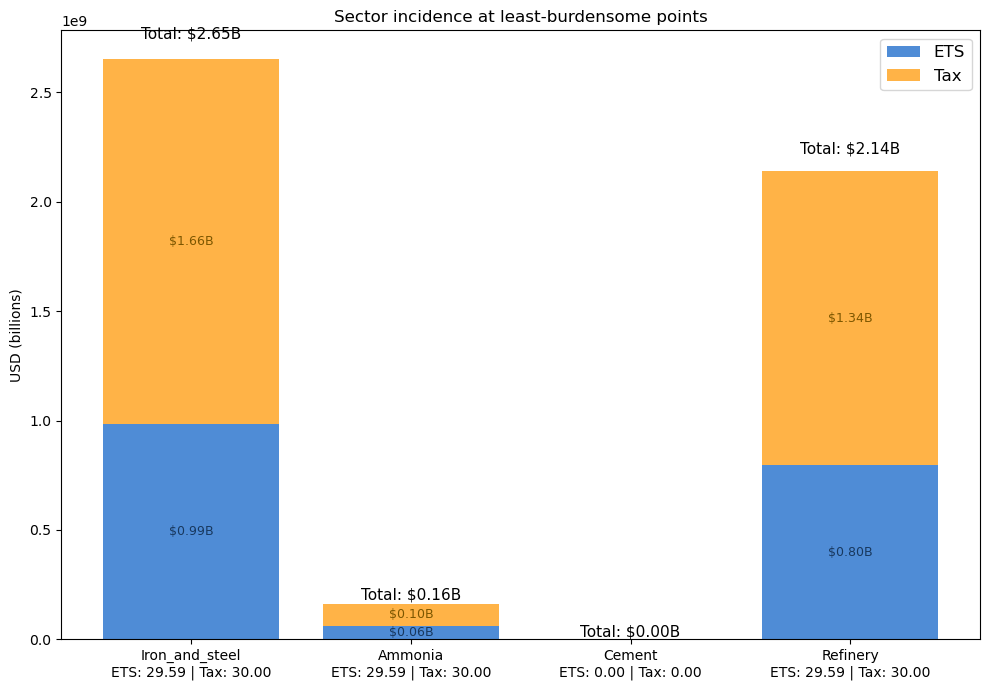

In [372]:
import matplotlib.pyplot as plt

sector_labels = []
ets_paid_list = []
tax_paid_list = []
ets_rate_list = []
tax_rate_list = []

for sector in sector_names:
    if sector in min_scenarios:
        row = min_scenarios[sector]
        plants = preview_df[preview_df['Sector'] == sector]
        ets_price = row['ETS Price']
        tax_rate = row[f'Carbon Tax [{sector}]']
        ets_paid = ets_price * (plants['Carbon_Intensity'] * plants['Actual_Production'] * (1 - plants['Emission_Cap'])).sum()
        tax_paid = tax_rate * (plants['Carbon_Intensity'] * plants['Actual_Production'] * plants['Jurisdiction_GHG']).sum()
        # For xtick label: sector + policy rates
        sector_label = f"{sector}\nETS: {ets_price:.2f} | Tax: {tax_rate:.2f}"
        sector_labels.append(sector_label)
        ets_paid_list.append(ets_paid)
        tax_paid_list.append(tax_paid)
        ets_rate_list.append(ets_price)
        tax_rate_list.append(tax_rate)

plt.figure(figsize=(10, 7))
bars_ets = plt.bar(sector_labels, ets_paid_list, color="#4F8CD6", label="ETS")
bars_tax = plt.bar(sector_labels, tax_paid_list, bottom=ets_paid_list, color="#FFB347", label="Tax")

plt.ylabel("USD (billions)")
plt.title("Sector incidence at least-burdensome points")
plt.legend(fontsize=12)

for i, (bar_ets, bar_tax) in enumerate(zip(bars_ets, bars_tax)):
    total = ets_paid_list[i] + tax_paid_list[i]
    # Show 'Total' just above the stack
    plt.text(
        bar_ets.get_x() + bar_ets.get_width()/2, total * 1.03,
        f"Total: ${total/1e9:.2f}B",
        ha="center", va="bottom", fontsize=11, color="black"
    )
    # Place inside if enough space, else place just above/below
    # ETS paid inside (or above if too small)
    if ets_paid_list[i] > total * 0.12:
        plt.text(
            bar_ets.get_x() + bar_ets.get_width()/2, ets_paid_list[i] * 0.5,
            f"${ets_paid_list[i]/1e9:.2f}B",
            ha="center", va="center", fontsize=9, color="#18385e"
        )
    elif ets_paid_list[i] > 0:
        plt.text(
            bar_ets.get_x() + bar_ets.get_width()/2, ets_paid_list[i] + total * 0.01,
            f"${ets_paid_list[i]/1e9:.2f}B",
            ha="center", va="bottom", fontsize=8, color="#18385e"
        )
    # Tax paid inside (or above if too small)
    if tax_paid_list[i] > total * 0.12:
        plt.text(
            bar_ets.get_x() + bar_ets.get_width()/2, ets_paid_list[i] + tax_paid_list[i] * 0.5,
            f"${tax_paid_list[i]/1e9:.2f}B",
            ha="center", va="center", fontsize=9, color="#7c5600"
        )
    elif tax_paid_list[i] > 0:
        plt.text(
            bar_ets.get_x() + bar_ets.get_width()/2, total * 1.01,
            f"${tax_paid_list[i]/1e9:.2f}B",
            ha="center", va="bottom", fontsize=8, color="#7c5600"
        )

plt.tight_layout()
plt.show()


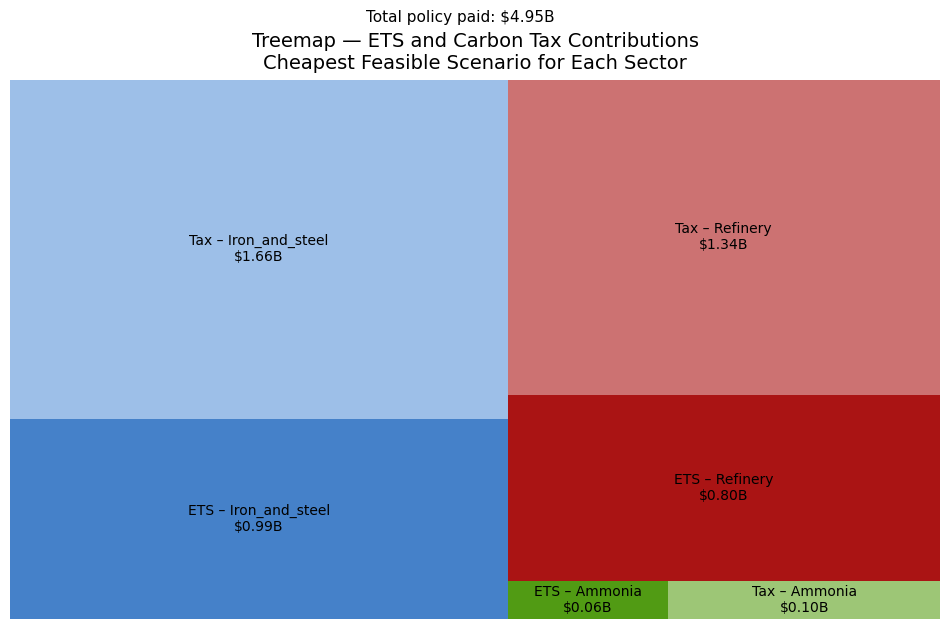

In [373]:
# pip install squarify  # run once if you don't have it
import squarify
import matplotlib.pyplot as plt
import numpy as np

# --- Build treemap tiles from the lists created in the previous cell ---
sectors_used = [lbl.split('\n')[0] for lbl in sector_labels]

# Base palette
base_colors = {
    "Iron_and_steel": (79/255, 140/255, 214/255),  # blue
    "Ammonia":        (78/255, 154/255, 6/255),    # green
    "Cement":         (193/255, 125/255, 17/255),  # orange-brown
    "Refinery":       (164/255, 0/255, 0/255),     # red
}

# Color adjustment functions
def lighten(rgb, factor=0.4):  # pastel side for Tax
    return tuple(1 - (1 - c) * (1 - factor) for c in rgb)

def saturate_and_darken(rgb, sat_factor=1.25, dark_factor=0.85):  # vibrant ETS
    rgb = np.array(rgb)
    mean = rgb.mean()
    # Saturation boost
    rgb = mean + (rgb - mean) * sat_factor
    rgb = np.clip(rgb, 0, 1)
    # Darken slightly for depth
    return tuple(rgb * dark_factor)

tiles = []   # (source, sector, value)
colors = []  # color per tile

for sec, ets_val, tax_val in zip(sectors_used, ets_paid_list, tax_paid_list):
    base = base_colors.get(sec, (0.6, 0.6, 0.6))
    if ets_val > 0:
        tiles.append(("ETS", sec, float(ets_val)))
        colors.append(saturate_and_darken(base, 1.25, 0.85))  # vibrant ETS
    if tax_val > 0:
        tiles.append(("Tax", sec, float(tax_val)))
        colors.append(lighten(base, 0.4))  # pastel Tax

if not tiles:
    print("Nothing to plot (all zeros).")
else:
    labels = [f"{src} – {sec}\n${val/1e9:.2f}B" for (src, sec, val) in tiles]
    sizes  = [val for (_, _, val) in tiles]

    plt.figure(figsize=(12, 7))
    squarify.plot(
        sizes=sizes,
        label=labels,
        color=colors,
        alpha=0.92,
        text_kwargs={"fontsize": 10}
    )
    plt.axis("off")

    total_policy = sum(sizes)
    plt.title("Treemap — ETS and Carbon Tax Contributions\nCheapest Feasible Scenario for Each Sector",
              fontsize=14, pad=8)
    plt.suptitle(f"Total policy paid: ${total_policy/1e9:.2f}B", y=0.98, fontsize=11)
    plt.show()


### 2. Stacked Bar: All-Sector Cheapest Scenario

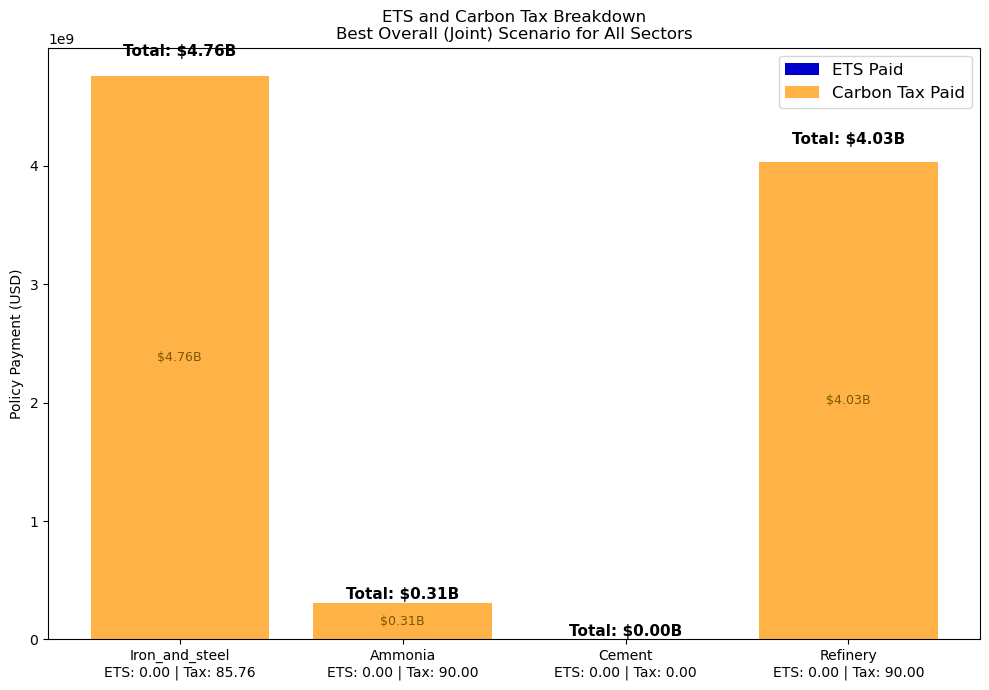

In [374]:
import matplotlib.pyplot as plt

sector_labels = []
ets_paid_list = []
tax_paid_list = []
ets_rate_list = []
tax_rate_list = []

if 'best_overall' in locals() or 'best_overall' in globals():
    for sector in sector_names:
        plants = preview_df[preview_df['Sector'] == sector]
        ets_price = best_overall['ETS Price']
        tax_rate = best_overall[f'Carbon Tax [{sector}]']
        ets_paid = ets_price * (plants['Carbon_Intensity'] * plants['Actual_Production'] * (1 - plants['Emission_Cap'])).sum()
        tax_paid = tax_rate * (plants['Carbon_Intensity'] * plants['Actual_Production'] * plants['Jurisdiction_GHG']).sum()
        # x-tick label with sector and policy rates
        sector_label = f"{sector}\nETS: {ets_price:.2f} | Tax: {tax_rate:.2f}"
        sector_labels.append(sector_label)
        ets_paid_list.append(ets_paid)
        tax_paid_list.append(tax_paid)
        ets_rate_list.append(ets_price)
        tax_rate_list.append(tax_rate)

    plt.figure(figsize=(10, 7))
    bars_ets = plt.bar(sector_labels, ets_paid_list, color="#0000cd", label="ETS Paid")
    bars_tax = plt.bar(sector_labels, tax_paid_list, bottom=ets_paid_list, color="#FFB347", label="Carbon Tax Paid")

    plt.ylabel("Policy Payment (USD)")
    plt.title("ETS and Carbon Tax Breakdown\nBest Overall (Joint) Scenario for All Sectors")
    plt.legend(fontsize=12)

    for i, (bar_ets, bar_tax) in enumerate(zip(bars_ets, bars_tax)):
        total = ets_paid_list[i] + tax_paid_list[i]
        # Total on top
        plt.text(
            bar_ets.get_x() + bar_ets.get_width()/2, total * 1.03,
            f"Total: ${total/1e9:.2f}B",
            ha="center", va="bottom", fontsize=11, color="black", fontweight="bold"
        )
        # ETS paid inside (or above if too small)
        if ets_paid_list[i] > total * 0.12:
            plt.text(
                bar_ets.get_x() + bar_ets.get_width()/2, ets_paid_list[i] * 0.5,
                f"${ets_paid_list[i]/1e9:.2f}B",
                ha="center", va="center", fontsize=9, color="#18385e"
            )
        elif ets_paid_list[i] > 0:
            plt.text(
                bar_ets.get_x() + bar_ets.get_width()/2, ets_paid_list[i] + total * 0.01,
                f"${ets_paid_list[i]/1e9:.2f}B",
                ha="center", va="bottom", fontsize=8, color="#18385e"
            )
        # Tax paid inside (or above if too small)
        if tax_paid_list[i] > total * 0.12:
            plt.text(
                bar_ets.get_x() + bar_ets.get_width()/2, ets_paid_list[i] + tax_paid_list[i] * 0.5,
                f"${tax_paid_list[i]/1e9:.2f}B",
                ha="center", va="center", fontsize=9, color="#7c5600"
            )
        elif tax_paid_list[i] > 0:
            plt.text(
                bar_ets.get_x() + bar_ets.get_width()/2, total * 1.01,
                f"${tax_paid_list[i]/1e9:.2f}B",
                ha="center", va="bottom", fontsize=8, color="#7c5600"
            )

    plt.tight_layout()
    plt.show()
else:
    print("Variable 'best_overall' not found! Run the previous analysis cell first.")


## Diagnostic check

### Print Out the "Best Overall" Scenario Details

In [375]:
print(best_overall[["ETS_Cap", "Tax_Cap", "ETS Price"] + [f"Carbon Tax [{s}]" for s in sector_names]])
for sector in sector_names:
    print(f"{sector}: Paid = {best_overall.get(f'TotalPolicyPaid_{sector}', 0):,.2f}, "
          f"ETS = {best_overall.get('ETS Price', 0):.2f}, "
          f"Tax = {best_overall.get(f'Carbon Tax [{sector}]', 0):.2f}")


ETS_Cap                                0
Tax_Cap                               90
ETS Price                            0.0
Carbon Tax [Iron_and_steel]    85.760538
Carbon Tax [Ammonia]                90.0
Carbon Tax [Cement]                  0.0
Carbon Tax [Refinery]               90.0
Name: 9, dtype: object
Iron_and_steel: Paid = 4,758,625,546.07, ETS = 0.00, Tax = 85.76
Ammonia: Paid = 306,733,269.24, ETS = 0.00, Tax = 90.00
Cement: Paid = 0.00, ETS = 0.00, Tax = 0.00
Refinery: Paid = 4,033,951,136.99, ETS = 0.00, Tax = 90.00


In [376]:
print("--- Policy Paid Consistency Check (per sector) ---")
for sector in sector_names:
    # For the given scenario, recompute component-wise sum:
    # (You can swap in min_scenarios[sector] or best_overall as needed)
    row = best_overall  # or min_scenarios[sector], etc.
    # Get plant data for this sector
    plants = preview_df[preview_df["Sector"] == sector]
    ets_price = row.get("ETS Price", 0)
    tax = row.get(f"Carbon Tax [{sector}]", 0)
    # Calculate ETS paid and Tax paid (same logic as original code)
    ets_paid = ets_price * (plants['Carbon_Intensity'] * plants['Actual_Production'] * (1 - plants['Emission_Cap'])).sum()
    tax_paid = tax * (plants['Carbon_Intensity'] * plants['Actual_Production'] * plants['Jurisdiction_GHG']).sum()
    stacked_sum = ets_paid + tax_paid
    total_policy = row.get(f"TotalPolicyPaid_{sector}", 0)
    print(f"{sector}: stacked sum = {stacked_sum:,.2f}, total policy = {total_policy:,.2f}, diff = {stacked_sum - total_policy:.2e}")


--- Policy Paid Consistency Check (per sector) ---
Iron_and_steel: stacked sum = 4,758,625,546.07, total policy = 4,758,625,546.07, diff = 0.00e+00
Ammonia: stacked sum = 306,733,269.24, total policy = 306,733,269.24, diff = 0.00e+00
Cement: stacked sum = 0.00, total policy = 0.00, diff = 0.00e+00
Refinery: stacked sum = 4,033,951,136.99, total policy = 4,033,951,136.99, diff = 0.00e+00


### 3. Comparison Table: Cheapest Per-Sector vs. Best Overall

In [377]:
import pandas as pd

table = pd.DataFrame({
    "Sector": sector_names,
    "Sector Cheapest (USD)": [min_scenarios[s][f"TotalPolicyPaid_{s}"] for s in sector_names],
    "Best Overall Scenario (USD)": [best_overall[f"TotalPolicyPaid_{s}"] for s in sector_names]
})
table["Difference"] = table["Best Overall Scenario (USD)"] - table["Sector Cheapest (USD)"]
print(table)


           Sector  Sector Cheapest (USD)  Best Overall Scenario (USD)  \
0  Iron_and_steel           2.649845e+09                 4.758626e+09   
1         Ammonia           1.627589e+08                 3.067333e+08   
2          Cement           0.000000e+00                 0.000000e+00   
3        Refinery           2.140497e+09                 4.033951e+09   

     Difference  
0  2.108781e+09  
1  1.439743e+08  
2  0.000000e+00  
3  1.893455e+09  


In [378]:
results_csv.head()

EmissionCap  CaptureRate  AbatementCost  Feasible  ETS_Price  ETS_Income  \
0          0.0          0.0              0         1        0.0         0.0   
1          0.0          0.0             10         1        0.0         0.0   
2          0.0          0.0             20         1        0.0         0.0   
3          0.0          0.0             30         1        0.0         0.0   
4          0.0          0.0             40         1        0.0         0.0   

   Tax_Income  Total_Abate_Cost   Funding_Gap  CarbonTax_Iron_and_steel  \
0         0.0      0.000000e+00  0.000000e+00                       0.0   
1         0.0      1.011034e+09 -1.011034e+09                       0.0   
2         0.0      2.022069e+09 -2.022069e+09                       0.0   
3         0.0      3.033103e+09 -3.033103e+09                       0.0   
4         0.0      4.044138e+09 -4.044138e+09                       0.0   

   CarbonTax_Ammonia  CarbonTax_Cement  CarbonTax_Refinery  EmissionCap_r  \
0                0.0               0.0                 0.0            0.0   
1                0.0               0.0                 0.0            0.0   
2                0.0               0.0                 0.0            0.0   
3                0.0               0.0                 0.0            0.0   
4                0.0               0.0                 0.0            0.0   

   CaptureRate_r  AbatementCost_r  
0            0.0                0  
1            0.0               10  
2            0.0               20  
3            0.0               30  
4            0.0               40

## Sectoral Analysis - with Sensitivity Analysis Result

### Compute All Policy Paid Columns for Feasible Scenarios

In [379]:
import numpy as np

# Make a copy for safety
feasible = results_csv[results_csv['Feasible'].isin([1, True, "True"]) & (results_csv['Funding_Gap'] <= 0)].copy()

sector_names = ['Iron_and_steel', 'Ammonia', 'Cement', 'Refinery']

# Function for policy paid, based on preview_df's sector emissions
if "Plant_Emissions" not in preview_df.columns:
    preview_df["Plant_Emissions"] = preview_df["Carbon_Intensity"] * preview_df["Actual_Production"]

sector_emissions = preview_df.groupby('Sector')['Plant_Emissions'].sum().to_dict()

def sector_policy_paid(row, sector_name):
    ets_price = row.get('ETS_Price', 0) if not np.isnan(row.get('ETS_Price', np.nan)) else 0
    tax = row.get(f'CarbonTax_{sector_name}', 0) if not np.isnan(row.get(f'CarbonTax_{sector_name}', np.nan)) else 0
    emissions = sector_emissions.get(sector_name, 0)
    # Assume both ETS and tax are applied to full emissions
    ets_paid = ets_price * emissions
    tax_paid = tax * emissions
    return ets_paid + tax_paid

# Calculate total policy paid columns
for sector in sector_names:
    feasible[f'TotalPolicyPaid_{sector}'] = feasible.apply(lambda row: sector_policy_paid(row, sector), axis=1)


### Create min_scenarios AFTER columns are created

In [380]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Preprocessing ---

# Ensure feasible scenarios only (as before)
feasible = results_csv[results_csv['Feasible'].isin([1, True, "True"]) & (results_csv['Funding_Gap'] <= 0)].copy()

sector_names = ['Iron_and_steel', 'Ammonia', 'Cement', 'Refinery']

# Calculate sector emissions if not already
if "Plant_Emissions" not in preview_df.columns:
    preview_df["Plant_Emissions"] = preview_df["Carbon_Intensity"] * preview_df["Actual_Production"]
sector_emissions = preview_df.groupby('Sector')['Plant_Emissions'].sum().to_dict()

# --- Calculate total policy paid columns ---

def sector_policy_paid(row, sector_name):
    ets_price = row.get('ETS_Price', 0) if not np.isnan(row.get('ETS_Price', np.nan)) else 0
    tax = row.get(f'CarbonTax_{sector_name}', 0) if not np.isnan(row.get(f'CarbonTax_{sector_name}', np.nan)) else 0
    emissions = sector_emissions.get(sector_name, 0)
    ets_paid = ets_price * emissions
    tax_paid = tax * emissions
    total_paid = ets_paid + tax_paid
    return total_paid

for sector in sector_names:
    feasible[f'TotalPolicyPaid_{sector}'] = feasible.apply(lambda row: sector_policy_paid(row, sector), axis=1)

# --- Find minimum payment scenario per sector (cheapest nonzero policy) ---

min_scenarios = {}
for sector in sector_names:
    # Only consider scenarios where this sector's policy payment is > 0
    filtered = feasible[feasible[f'TotalPolicyPaid_{sector}'] >= 0]
    if not filtered.empty:
        idx = filtered[f'TotalPolicyPaid_{sector}'].idxmin()
        min_scenarios[sector] = feasible.loc[idx]

# --- Find "best overall" scenario: minimum sum of policy payment across all sectors (all > 0) ---
feasible['TotalPolicyPaid_SUM'] = feasible[[f'TotalPolicyPaid_{s}' for s in sector_names]].sum(axis=1)
# Only scenarios where all sector payments are > 0
all_positive = feasible[(feasible[[f'TotalPolicyPaid_{s}' for s in sector_names]] >= 0).all(axis=1)]
if not all_positive.empty:
    idx_best = all_positive['TotalPolicyPaid_SUM'].idxmin()
    best_scenario = all_positive.loc[idx_best]
else:
    best_scenario = None

import pandas as pd

print(f"Scenarios considered feasible: {len(feasible)}\n")

print('--- Cheapest Feasible Scenario for Each Sector ---')
for sector in sector_names:
    print(f"Sector: {sector}")
    if sector in min_scenarios:
        row = min_scenarios[sector]
        # Display only relevant info for brevity (feel free to add more columns as needed)
        print(f"ETS_Cap\t\t\t{row.get('ETS_Cap', row.get('ETS Cap', 'N/A'))}")
        print(f"Tax_Cap\t\t\t{row.get('Tax_Cap', row.get('Tax Cap', 'N/A'))}")
        print(f"ETS Price\t\t{row.get('ETS_Price', row.get('ETS Price', 'N/A')):.6f}")
        print(f"Carbon Tax [{sector}]\t{row.get(f'CarbonTax_{sector}', row.get(f'Carbon Tax [{sector}]', 'N/A'))}")
        print(f"TotalPolicyPaid_{sector}\t{row[f'TotalPolicyPaid_{sector}']}")
        print(row.name)  # row index for reference
    else:
        print("No feasible scenario found for this sector.")
    print('-' * 40)

# Count nulls and > 0 for each sector policy payment column
for sector in sector_names:
    notnull_count = feasible[f'TotalPolicyPaid_{sector}'].notnull().sum()
    gt_zero_count = (feasible[f'TotalPolicyPaid_{sector}'] >= 0).sum()
    print(f"TotalPolicyPaid_{sector}: not null = {notnull_count}, > 0 = {gt_zero_count}")

print("\nBest Overall Scenario (min total policy paid by all sectors):")
if best_scenario is not None:
    # Print relevant values, adjust as needed
    for field in ['ETS_Cap', 'Tax_Cap', 'ETS_Price']:
        print(f"{field}\t{best_scenario.get(field, best_scenario.get(field.replace('_', ' '), 'N/A'))}")
    for sector in sector_names:
        print(f"Carbon Tax [{sector}]\t{best_scenario.get(f'CarbonTax_{sector}', best_scenario.get(f'Carbon Tax [{sector}]', 'N/A'))}")
    print(f"TotalPolicyPaid_All\t{best_scenario['TotalPolicyPaid_SUM']}")
    print(best_scenario.name)
else:
    print("No scenario with all sector policy payments >= 0.")

# --- Build comparison DataFrame as in your sample ---

comp_df = pd.DataFrame({
    'Sector': sector_names,
    'Sector Cheapest (USD)': [
        min_scenarios[sector][f"TotalPolicyPaid_{sector}"] if sector in min_scenarios else None
        for sector in sector_names
    ],
    'Best Overall Scenario (USD)': [
        best_scenario[f"TotalPolicyPaid_{sector}"] if best_scenario is not None else None
        for sector in sector_names
    ]
})
comp_df['Difference'] = comp_df['Best Overall Scenario (USD)'] - comp_df['Sector Cheapest (USD)']
print("\n", comp_df)



Scenarios considered feasible: 797

--- Cheapest Feasible Scenario for Each Sector ---
Sector: Iron_and_steel
ETS_Cap			N/A
Tax_Cap			N/A
ETS Price		0.000000
Carbon Tax [Iron_and_steel]	0.0
TotalPolicyPaid_Iron_and_steel	0.0
0
----------------------------------------
Sector: Ammonia
ETS_Cap			N/A
Tax_Cap			N/A
ETS Price		0.000000
Carbon Tax [Ammonia]	0.0
TotalPolicyPaid_Ammonia	0.0
0
----------------------------------------
Sector: Cement
ETS_Cap			N/A
Tax_Cap			N/A
ETS Price		0.000000
Carbon Tax [Cement]	0.0
TotalPolicyPaid_Cement	0.0
0
----------------------------------------
Sector: Refinery
ETS_Cap			N/A
Tax_Cap			N/A
ETS Price		0.000000
Carbon Tax [Refinery]	0.0
TotalPolicyPaid_Refinery	0.0
0
----------------------------------------
TotalPolicyPaid_Iron_and_steel: not null = 797, > 0 = 797
TotalPolicyPaid_Ammonia: not null = 797, > 0 = 797
TotalPolicyPaid_Cement: not null = 797, > 0 = 797
TotalPolicyPaid_Refinery: not null = 797, > 0 = 797

Best Overall Scenario (min total policy 

### Plot A. Bar Chart: Minimum Policy Payment per Sector (Cheapest Feasible Scenario) and B. Bar Chart: Policy Payment per Sector (Best Overall Feasible Scenario)

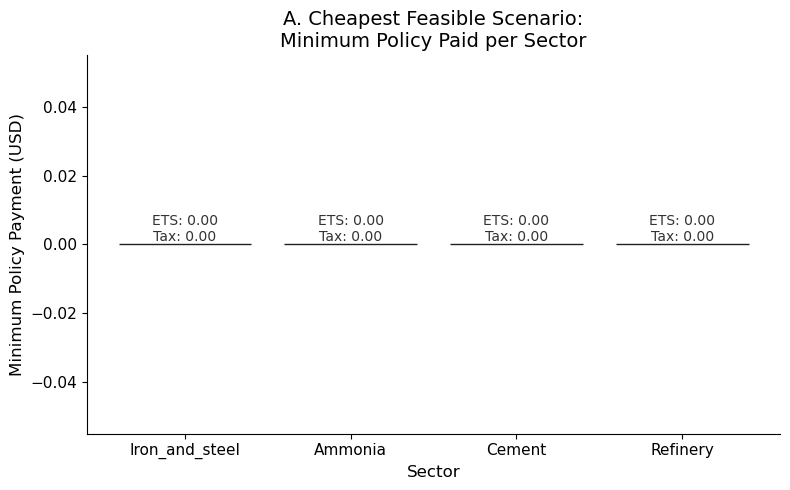

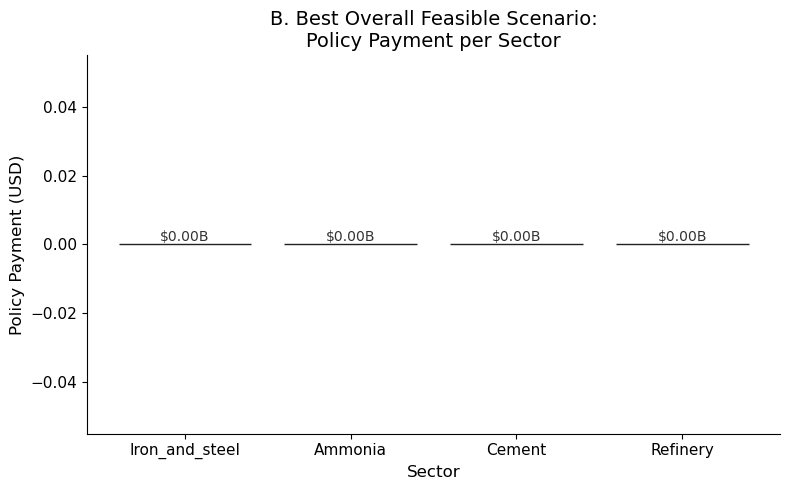

In [381]:
import matplotlib.pyplot as plt

# --- A. Cheapest Feasible Scenario: Minimum Policy Paid per Sector ---

# Extract data from min_scenarios
sector_labels = []
min_paid = []
ets_prices = []
tax_caps = []
for sector in sector_names:
    if sector in min_scenarios:
        row = min_scenarios[sector]
        sector_labels.append(sector)
        min_paid.append(row[f"TotalPolicyPaid_{sector}"])
        # Tolerate alternate naming
        ets_prices.append(row.get("ETS_Price", row.get("ETS Price", 0)))
        tax_caps.append(row.get(f"CarbonTax_{sector}", row.get(f"Carbon Tax [{sector}]", 0)))
    else:
        sector_labels.append(sector)
        min_paid.append(0)
        ets_prices.append(0)
        tax_caps.append(0)

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(
    sector_labels,
    min_paid,
    color="#3465a4",
    alpha=0.87,
    edgecolor="black",
    linewidth=1
)
ax.set_ylabel("Minimum Policy Payment (USD)", fontsize=12)
ax.set_xlabel("Sector", fontsize=12)
ax.set_title("A. Cheapest Feasible Scenario:\nMinimum Policy Paid per Sector", fontsize=14)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(axis='x', labelsize=11)
ax.tick_params(axis='y', labelsize=11)

# Annotate bars: show ETS and Tax used (rounded, consistent style)
for i, bar in enumerate(bars):
    ax.text(
        bar.get_x() + bar.get_width()/2, 
        bar.get_height() + max(min_paid) * 0.01,
        f"ETS: {ets_prices[i]:.2f}\nTax: {tax_caps[i]:.2f}",
        ha="center", va="bottom", fontsize=10, color="#333"
    )

fig.tight_layout()
plt.show()


# --- B. Best Overall Feasible Scenario: Policy Payment per Sector ---

best_overall_paid = [
    best_scenario[f"TotalPolicyPaid_{sector}"] if best_scenario is not None else 0
    for sector in sector_names
]

fig, ax = plt.subplots(figsize=(8, 5))
bar_colors = ["#3465a4", "#4e9a06", "#c17d11", "#a40000"]
bars = ax.bar(
    sector_names,
    best_overall_paid,
    color=bar_colors,
    alpha=0.87,
    edgecolor="black",
    linewidth=1
)
ax.set_ylabel("Policy Payment (USD)", fontsize=12)
ax.set_xlabel("Sector", fontsize=12)
ax.set_title("B. Best Overall Feasible Scenario:\nPolicy Payment per Sector", fontsize=14)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(axis='x', labelsize=11)
ax.tick_params(axis='y', labelsize=11)

# Annotate bars: policy paid in billions (consistent style)
for i, bar in enumerate(bars):
    ax.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + max(best_overall_paid) * 0.01,
        f"${best_overall_paid[i]/1e9:.2f}B",
        ha="center", va="bottom", fontsize=10, color="#333"
    )

fig.tight_layout()
plt.show()


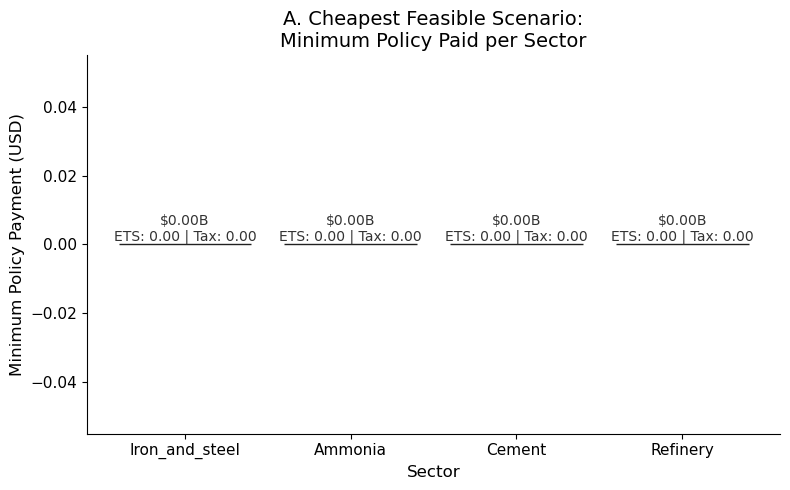

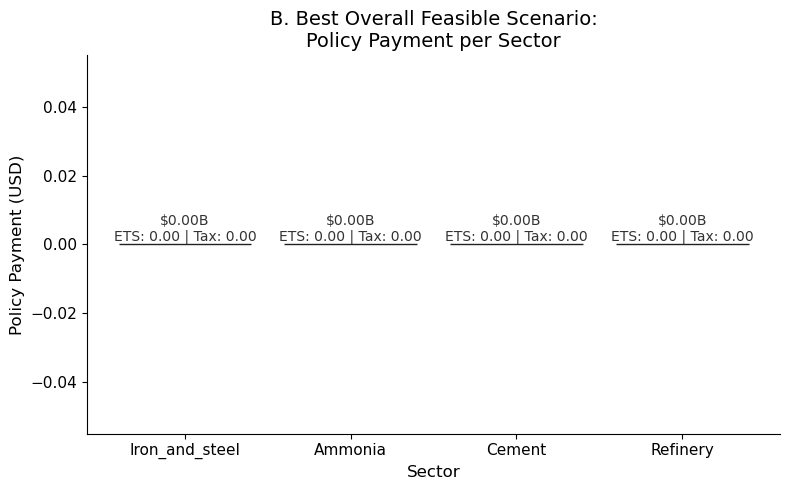

In [382]:
import matplotlib.pyplot as plt

# --- A. Cheapest Feasible Scenario: Minimum Policy Paid per Sector (Color Coded) ---

sector_colors = {
    'Iron_and_steel': '#4F8CD6',  # blue
    'Ammonia': '#4e9a06',         # green
    'Cement': '#c17d11',          # brown/orange
    'Refinery': '#a40000',        # red
}

# Extract data for min_scenarios
sector_labels = []
min_paid = []
ets_prices = []
tax_caps = []
bar_colors = []
for sector in sector_names:
    if sector in min_scenarios:
        row = min_scenarios[sector]
        sector_labels.append(sector)
        min_paid.append(row[f"TotalPolicyPaid_{sector}"])
        ets_prices.append(row.get("ETS_Price", row.get("ETS Price", 0)))
        tax_caps.append(row.get(f"CarbonTax_{sector}", row.get(f"Carbon Tax [{sector}]", 0)))
        bar_colors.append(sector_colors.get(sector, "#3465a4"))
    else:
        sector_labels.append(sector)
        min_paid.append(0)
        ets_prices.append(0)
        tax_caps.append(0)
        bar_colors.append("#cccccc")  # fallback gray

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(
    sector_labels,
    min_paid,
    color=bar_colors,
    alpha=0.87,
    edgecolor="black",
    linewidth=1
)
ax.set_ylabel("Minimum Policy Payment (USD)", fontsize=12)
ax.set_xlabel("Sector", fontsize=12)
ax.set_title("A. Cheapest Feasible Scenario:\nMinimum Policy Paid per Sector", fontsize=14)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(axis='x', labelsize=11)
ax.tick_params(axis='y', labelsize=11)

# Annotate bars: show value in billions and policy rates used
for i, bar in enumerate(bars):
    total_val = min_paid[i]
    ax.text(
        bar.get_x() + bar.get_width()/2, total_val * 1.02,
        f"${total_val/1e9:.2f}B\nETS: {ets_prices[i]:.2f} | Tax: {tax_caps[i]:.2f}",
        ha="center", va="bottom", fontsize=10, color="#333"
    )

fig.tight_layout()
plt.show()


# --- B. Best Overall Feasible Scenario: Policy Payment per Sector (Color Coded) ---

best_overall_paid = [
    best_scenario[f"TotalPolicyPaid_{sector}"] if best_scenario is not None else 0
    for sector in sector_names
]
best_overall_ets = [
    best_scenario.get("ETS_Price", best_scenario.get("ETS Price", 0)) if best_scenario is not None else 0
] * len(sector_names)
best_overall_tax = [
    best_scenario.get(f"CarbonTax_{sector}", best_scenario.get(f"Carbon Tax [{sector}]", 0)) if best_scenario is not None else 0
    for sector in sector_names
]
bar_colors = [sector_colors.get(s, "#3465a4") for s in sector_names]

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(
    sector_names,
    best_overall_paid,
    color=bar_colors,
    alpha=0.87,
    edgecolor="black",
    linewidth=1
)
ax.set_ylabel("Policy Payment (USD)", fontsize=12)
ax.set_xlabel("Sector", fontsize=12)
ax.set_title("B. Best Overall Feasible Scenario:\nPolicy Payment per Sector", fontsize=14)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(axis='x', labelsize=11)
ax.tick_params(axis='y', labelsize=11)

# Annotate bars: value in billions and policy rates used
for i, bar in enumerate(bars):
    total_val = best_overall_paid[i]
    ax.text(
        bar.get_x() + bar.get_width()/2, total_val * 1.02,
        f"${total_val/1e9:.2f}B\nETS: {best_overall_ets[i]:.2f} | Tax: {best_overall_tax[i]:.2f}",
        ha="center", va="bottom", fontsize=10, color="#333"
    )

fig.tight_layout()
plt.show()


## Country Analysis - with Scebario analysis result

### Country-level Emission (Iron and steel, ammonia, cement, refinery)

Total Emissions and Plant Counts per Country:
Brunei Darussalam: 1,965,528 tonnes CO₂/year, 2 plants
Cambodia: 2,643,243 tonnes CO₂/year, 5 plants
Indonesia: 51,538,578 tonnes CO₂/year, 33 plants
Lao People's Democratic Republic: 2,159,743 tonnes CO₂/year, 7 plants
Malaysia: 25,486,168 tonnes CO₂/year, 18 plants
Myanmar: 4,336,737 tonnes CO₂/year, 9 plants
Philippines: 9,427,124 tonnes CO₂/year, 16 plants
Singapore: 10,421,197 tonnes CO₂/year, 3 plants
Thailand: 21,948,926 tonnes CO₂/year, 16 plants
Vietnam: 60,610,944 tonnes CO₂/year, 59 plants


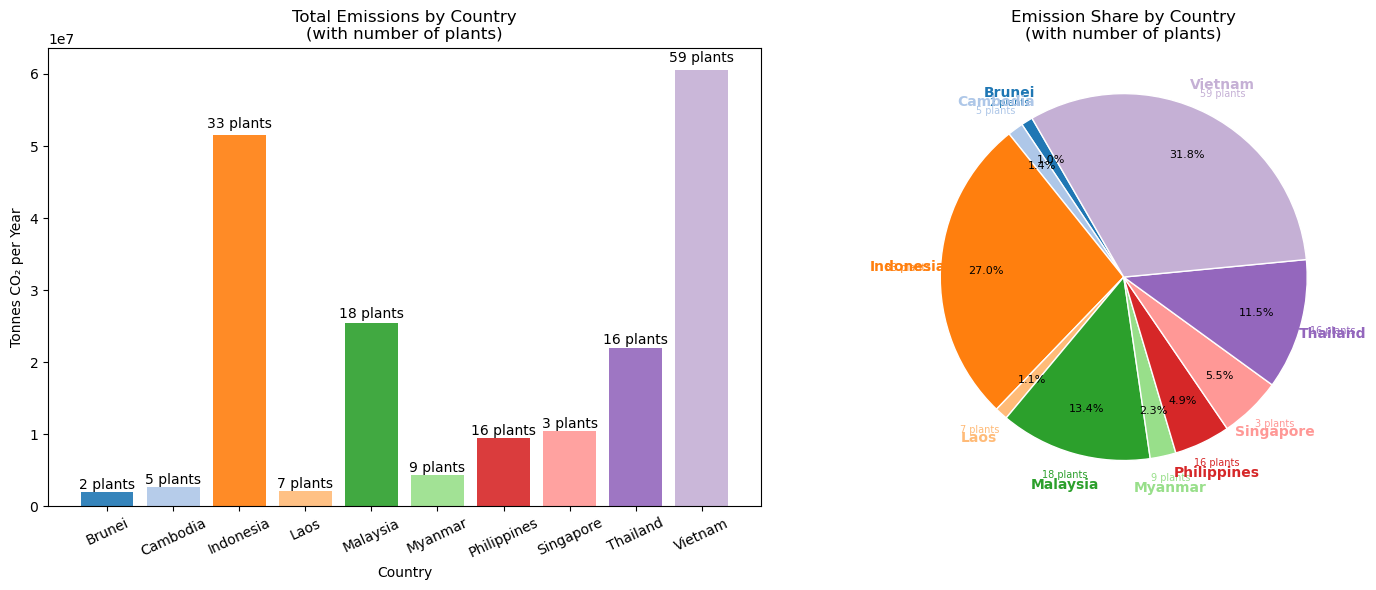

C:\Users\Keerati\AppData\Local\Temp\ipykernel_30108\3187307150.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


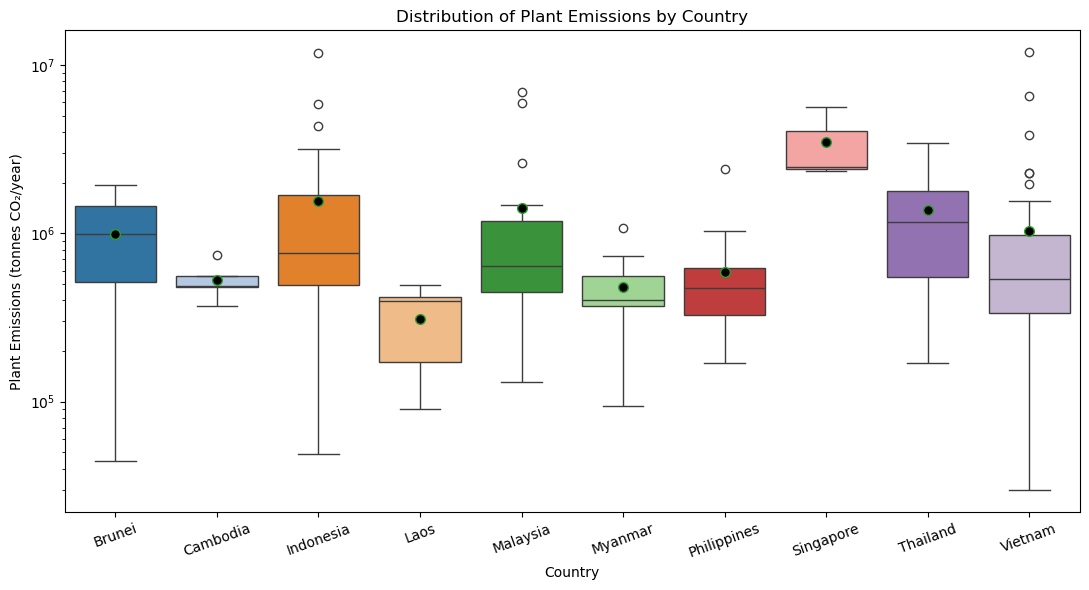

In [383]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# 1. Aggregate total emissions and plant counts per country
country_emissions = preview_df.groupby('Country')[['Carbon_Intensity', 'Actual_Production']].apply(
    lambda df: (df['Carbon_Intensity'] * df['Actual_Production']).sum()
).to_dict()

country_plant_counts = preview_df.groupby('Country')['Plant'].nunique().to_dict()

print("Total Emissions and Plant Counts per Country:")
for country in country_emissions:
    print(f"{country}: {country_emissions[country]:,.0f} tonnes CO₂/year, "
          f"{country_plant_counts[country]} plants")

# Prepare data for plotting
countries = list(country_emissions.keys())
emissions = [country_emissions[c] for c in countries]
plant_counts = [country_plant_counts[c] for c in countries]

# ---- Define short labels for plotting ----
display_names = {
    'Lao People\'s Democratic Republic': 'Laos',
    'Brunei Darussalam': 'Brunei'
}

# Add a column with display country names to preview_df
preview_df['Country_Display'] = preview_df['Country'].replace(display_names)

# Get unique short names in plotting order
plot_countries = [display_names.get(c, c) for c in countries]

# Consistent color mapping for all plots
color_palette = plt.get_cmap('tab20').colors
n_countries = len(plot_countries)
country_colors = {plot_countries[i]: color_palette[i % len(color_palette)] for i in range(n_countries)}
bar_colors = [country_colors[c] for c in plot_countries]
sns_palette = {c: country_colors[c] for c in plot_countries}

# ---- Bar Chart ----
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
bars = axes[0].bar(plot_countries, emissions, color=bar_colors, alpha=0.90)
axes[0].set_title("Total Emissions by Country\n(with number of plants)")
axes[0].set_ylabel("Tonnes CO₂ per Year")
axes[0].set_xlabel("Country")
axes[0].tick_params(axis='x', rotation=25)

for bar, count in zip(bars, plant_counts):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2, height * 1.01,
                 f"{count} plants", ha='center', va='bottom', fontsize=10, color='black')

# ---- Pie Chart ----
wedges, texts = axes[1].pie(
    emissions,
    labels=None,
    autopct=None,
    startangle=120,
    colors=bar_colors,
    wedgeprops=dict(edgecolor='w')
)
for i, (wedge, country, count) in enumerate(zip(wedges, plot_countries, plant_counts)):
    ang = (wedge.theta2 + wedge.theta1) / 2.
    x = np.cos(np.deg2rad(ang))
    y = np.sin(np.deg2rad(ang))
    # Place country name slightly outside the wedge, plant count below it in smaller font
    axes[1].text(1.18*x, 1.18*y, f"{country}", ha='center', va='center',
                 fontsize=10, color=bar_colors[i], fontweight="bold")
    axes[1].text(1.18*x, 1.12*y, f"{count} plants", ha='center', va='center',
                 fontsize=7, color=bar_colors[i])
total = sum(emissions)
for i, (wedge, val) in enumerate(zip(wedges, emissions)):
    ang = (wedge.theta2 + wedge.theta1) / 2.
    x = 0.75 * np.cos(np.deg2rad(ang))
    y = 0.75 * np.sin(np.deg2rad(ang))
    pct = 100 * val / total
    axes[1].text(x, y, f"{pct:.1f}%", ha='center', va='center', fontsize=8, color='black')
axes[1].set_title("Emission Share by Country\n(with number of plants)")
plt.tight_layout()
plt.show()

# ---- Boxplot: Plant emissions by country (using short names) ----
if "Plant_Emissions" not in preview_df.columns:
    preview_df["Plant_Emissions"] = preview_df["Carbon_Intensity"] * preview_df["Actual_Production"]

plt.figure(figsize=(11, 6))
sns.boxplot(
    x="Country_Display",
    y="Plant_Emissions",
    data=preview_df,
    order=plot_countries,            # ensures same order as other plots
    palette=sns_palette,             # uses same color mapping as bar/pie
    showmeans=True,
    meanprops={"marker": "o", "markerfacecolor": "black", "markersize": 7}
)
plt.title("Distribution of Plant Emissions by Country")
plt.ylabel("Plant Emissions (tonnes CO₂/year)")
plt.xlabel("Country")
plt.yscale('log')
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


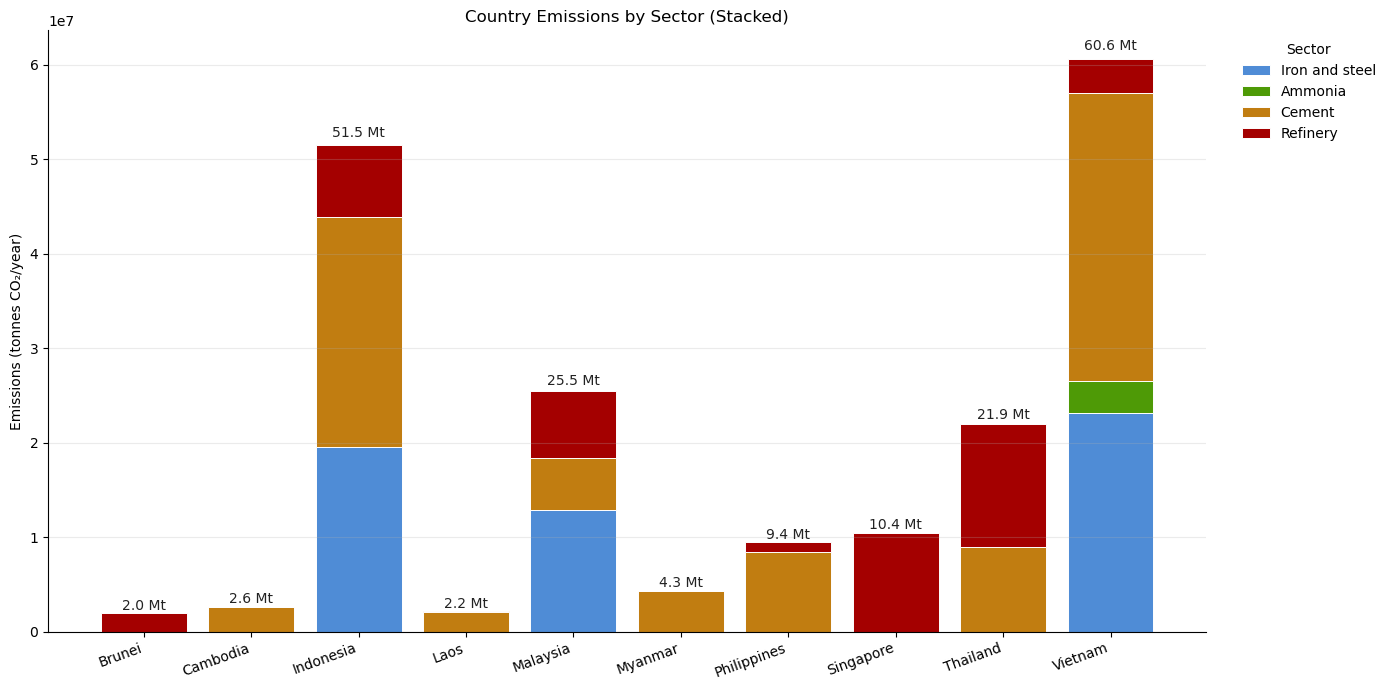

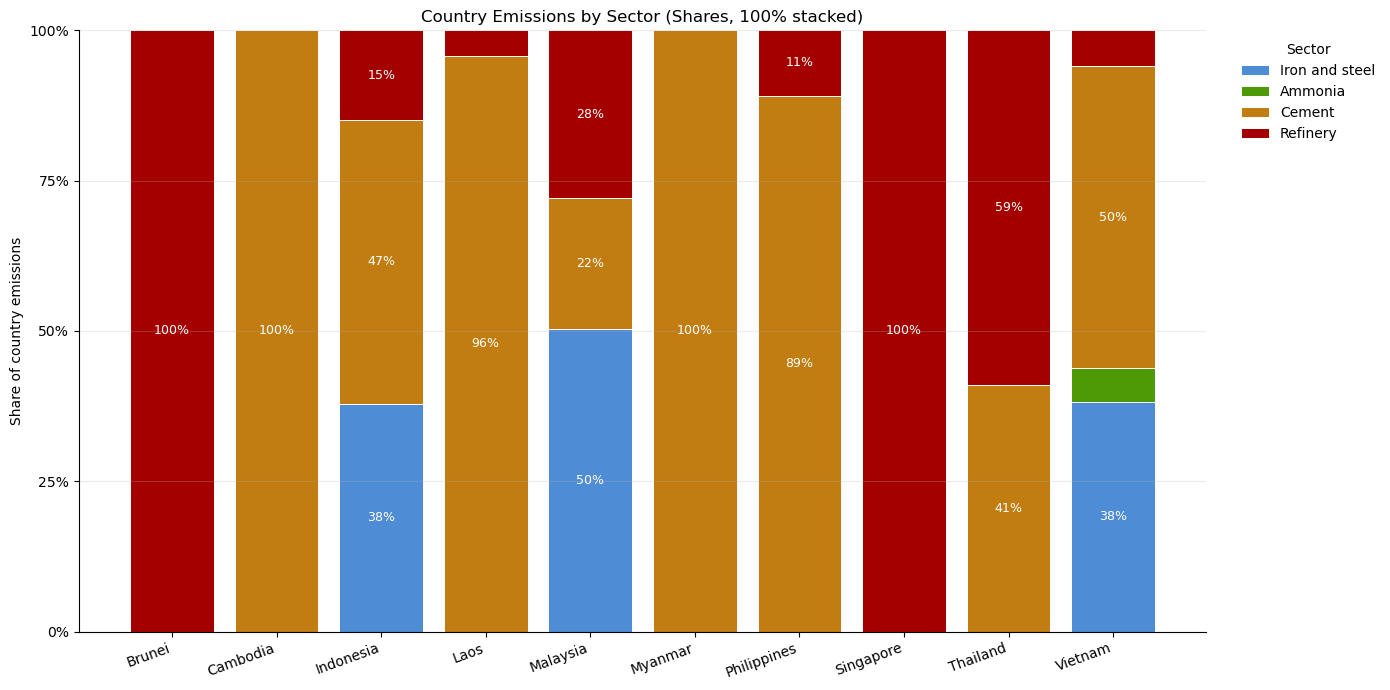

In [384]:
import numpy as np
import matplotlib.pyplot as plt

# =========================================================
# Country × Sector emissions → stacked bars (level & share)
# =========================================================
# This cell adds two new figures:
#   A) Absolute emissions per country, stacked by sector
#   B) Sector shares (100% stacked) within each country
#
# Inputs expected from your previous cell:
#   - preview_df: plant-level dataframe
#   - plot_countries: list of short country display names in desired order
#   - sector_names: ['Iron_and_steel', 'Ammonia', 'Cement', 'Refinery']
#   - display_names: dict mapping long -> short country names
#
# Notes:
#   - We compute plant-level emissions if missing, then aggregate.
#   - We enforce consistent country and sector ordering.
#   - We annotate totals (A) and major shares (B) for readability.

# ---------- 1) Ensure the emissions column exists & is numeric ----------
_df = preview_df.copy()
for col in ["Carbon_Intensity", "Actual_Production"]:
    _df[col] = pd.to_numeric(_df[col], errors="coerce").fillna(0.0)

if "Plant_Emissions" not in _df.columns:
    _df["Plant_Emissions"] = _df["Carbon_Intensity"] * _df["Actual_Production"]
else:
    _df["Plant_Emissions"] = pd.to_numeric(_df["Plant_Emissions"], errors="coerce").fillna(0.0)

# Work with display names (already created above)
if "Country_Display" not in _df.columns:
    _df["Country_Display"] = _df["Country"].replace(display_names)

# ---------- 2) Aggregate to Country × Sector ----------
# sum of plant emissions for each (Country_Display, Sector)
pivot_abs = (
    _df.groupby(["Country_Display", "Sector"], observed=False)["Plant_Emissions"]
       .sum()
       .unstack(fill_value=0.0)
)

# Enforce ordering (rows: countries, cols: sectors)
row_order = [c for c in plot_countries if c in pivot_abs.index]
col_order = [s for s in sector_names if s in pivot_abs.columns]
pivot_abs = pivot_abs.reindex(index=row_order, columns=col_order, fill_value=0.0)

# Totals per country (for sorting/annotation)
row_totals = pivot_abs.sum(axis=1)

# ---------- 3) Consistent sector colors ----------
sector_colors = {
    "Iron_and_steel": (79/255, 140/255, 214/255),  # blue
    "Ammonia":        (78/255, 154/255, 6/255),    # green
    "Cement":         (193/255, 125/255, 17/255),  # orange-brown
    "Refinery":       (164/255, 0/255, 0/255),     # red
}
bar_colors = [sector_colors.get(s, (0.6, 0.6, 0.6)) for s in col_order]

# ---------- 4) A) Absolute stacked bar ----------
countries = pivot_abs.index.tolist()
x = np.arange(len(countries))
width = 0.8

fig, ax = plt.subplots(figsize=(14, 7))
bottom = np.zeros(len(countries), dtype=float)

for s, color in zip(col_order, bar_colors):
    vals = pivot_abs[s].values
    ax.bar(x, vals, width=width, bottom=bottom, color=color, edgecolor="white", linewidth=0.7, label=s.replace("_", " "))
    bottom += vals

# Annotate each total on top
for xi, total in zip(x, row_totals.values):
    if total > 0:
        ax.text(xi, total * 1.01, f"{total/1e6:.1f} Mt", ha="center", va="bottom", fontsize=10, color="#222")

ax.set_xticks(x)
ax.set_xticklabels(countries, rotation=20, ha="right")
ax.set_ylabel("Emissions (tonnes CO₂/year)")
ax.set_title("Country Emissions by Sector (Stacked)")
ax.grid(axis="y", alpha=0.25)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.legend(title="Sector", ncol=1, frameon=False, bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()

# ---------- 5) B) 100% stacked bar (shares) ----------
# Avoid divide-by-zero by replacing zero totals with 1 (then will be all zeros anyway)
den = row_totals.replace(0, 1.0).values.reshape(-1, 1)
pivot_share = pivot_abs.div(den.squeeze(), axis=0)  # share per country

fig, ax = plt.subplots(figsize=(14, 7))
bottom = np.zeros(len(countries), dtype=float)

for s, color in zip(col_order, bar_colors):
    vals = pivot_share[s].values
    ax.bar(x, vals, width=width, bottom=bottom, color=color, edgecolor="white", linewidth=0.7, label=s.replace("_", " "))
    # Annotate only if segment is meaningful (>8%)
    for xi, y0, v in zip(x, bottom, vals):
        if v >= 0.08:  # 8% threshold to reduce clutter
            ax.text(xi, y0 + v/2, f"{v*100:.0f}%", ha="center", va="center", fontsize=9, color="white")
    bottom += vals

ax.set_xticks(x)
ax.set_xticklabels(countries, rotation=20, ha="right")
ax.set_ylim(0, 1)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
ax.set_yticklabels(["0%", "25%", "50%", "75%", "100%"])
ax.set_ylabel("Share of country emissions")
ax.set_title("Country Emissions by Sector (Shares, 100% stacked)")
ax.grid(axis="y", alpha=0.25)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.legend(title="Sector", ncol=1, frameon=False, bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()


### Country-level abatement cost (Iron and steel, ammonia, cement, refinery)

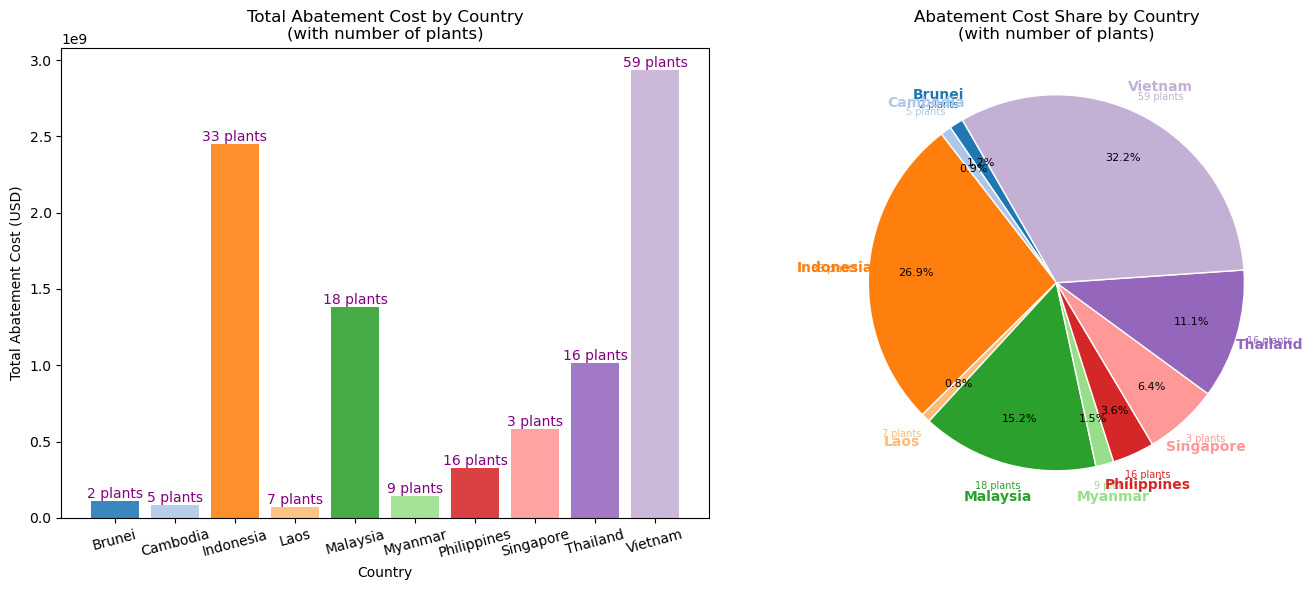

C:\Users\Keerati\AppData\Local\Temp\ipykernel_30108\1790182661.py:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


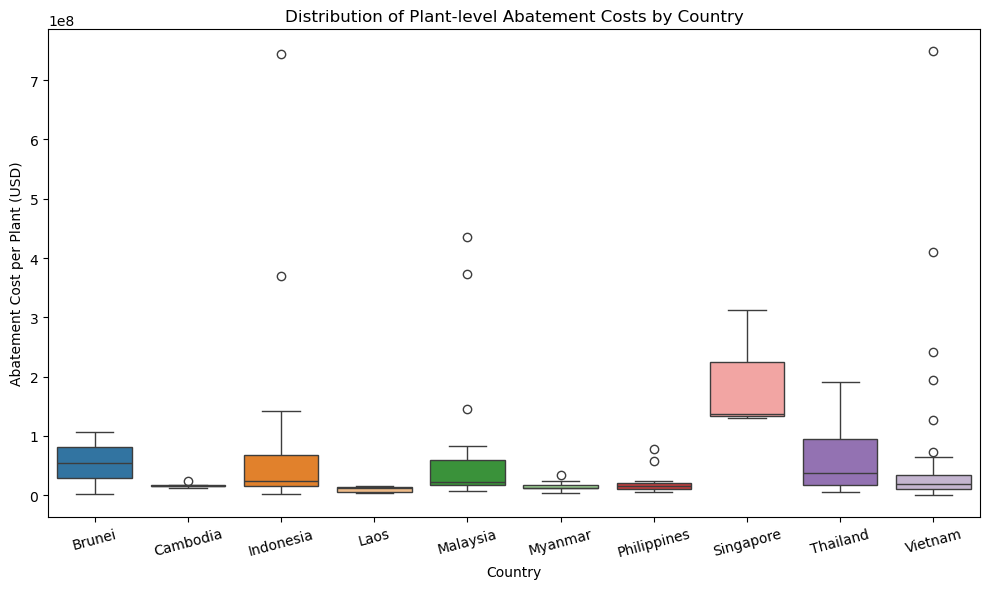

In [385]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Compute plant-level and country-level abatement cost
preview_df['Abate_Cost'] = (
    preview_df['Abatement_Cost'] *
    preview_df['Carbon_Intensity'] *
    preview_df['Actual_Production'] *
    preview_df['CO2_Capture']
)

# Use short names for plotting
display_names = {
    'Lao People\'s Democratic Republic': 'Laos',
    'Brunei Darussalam': 'Brunei'
}
preview_df['Country_Display'] = preview_df['Country'].replace(display_names)

# Aggregate total abatement cost per country
country_abate_cost = preview_df.groupby('Country_Display')['Abate_Cost'].sum().reindex(plot_countries)
plant_counts = preview_df['Country_Display'].value_counts().reindex(plot_countries)

# Labels with plant counts for bar and pie
bar_labels = [f"{c}\n({plant_counts[c]} plants)" for c in plot_countries]
pie_labels = [f"{c}\n({plant_counts[c]} plants)" for c in plot_countries]

# --- Consistent colors ---
bar_colors = [country_colors[c] for c in plot_countries]

# 2. Plot Bar + Pie
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- Bar Chart ---
bars = axes[0].bar(plot_countries, country_abate_cost.values, color=bar_colors, alpha=0.88)
axes[0].set_title("Total Abatement Cost by Country\n(with number of plants)")
axes[0].set_ylabel("Total Abatement Cost (USD)")
axes[0].set_xlabel("Country")
axes[0].tick_params(axis='x', rotation=15)
for i, bar in enumerate(bars):
    axes[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                 f"{plant_counts[plot_countries[i]]} plants", ha='center', va='bottom', color='purple', fontsize=10)

# --- Pie Chart ---
wedges, texts = axes[1].pie(
    country_abate_cost.values,
    labels=None,
    autopct=None,
    startangle=120,
    colors=bar_colors,
    wedgeprops=dict(edgecolor='w')
)
for i, (wedge, country) in enumerate(zip(wedges, plot_countries)):
    ang = (wedge.theta2 + wedge.theta1) / 2.
    x = np.cos(np.deg2rad(ang))
    y = np.sin(np.deg2rad(ang))
    axes[1].text(1.18*x, 1.18*y, f"{country}", ha='center', va='center',
                 fontsize=10, color=bar_colors[i], fontweight="bold")
    axes[1].text(1.18*x, 1.12*y, f"{plant_counts[country]} plants", ha='center', va='center',
                 fontsize=7, color=bar_colors[i])
total_cost = country_abate_cost.sum()
for i, (wedge, val) in enumerate(zip(wedges, country_abate_cost.values)):
    ang = (wedge.theta2 + wedge.theta1) / 2.
    x = 0.75 * np.cos(np.deg2rad(ang))
    y = 0.75 * np.sin(np.deg2rad(ang))
    pct = 100 * val / total_cost
    axes[1].text(x, y, f"{pct:.1f}%", ha='center', va='center', fontsize=8, color='black')
axes[1].set_title("Abatement Cost Share by Country\n(with number of plants)")

plt.tight_layout()
plt.show()

# 3. Boxplot: Plant Abatement Cost per Country
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=preview_df,
    x='Country_Display',
    y='Abate_Cost',
    order=plot_countries,
    palette=[country_colors[c] for c in plot_countries]
)
plt.title("Distribution of Plant-level Abatement Costs by Country")
plt.ylabel("Abatement Cost per Plant (USD)")
plt.xlabel("Country")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


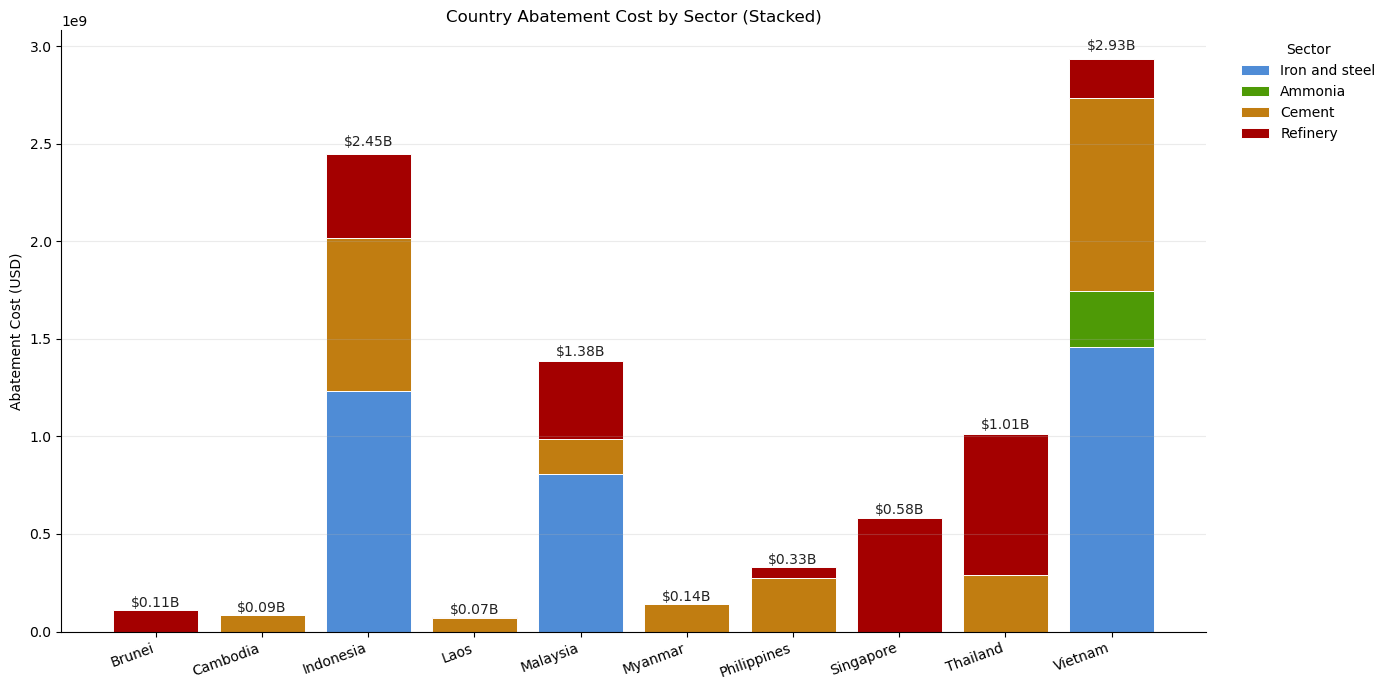

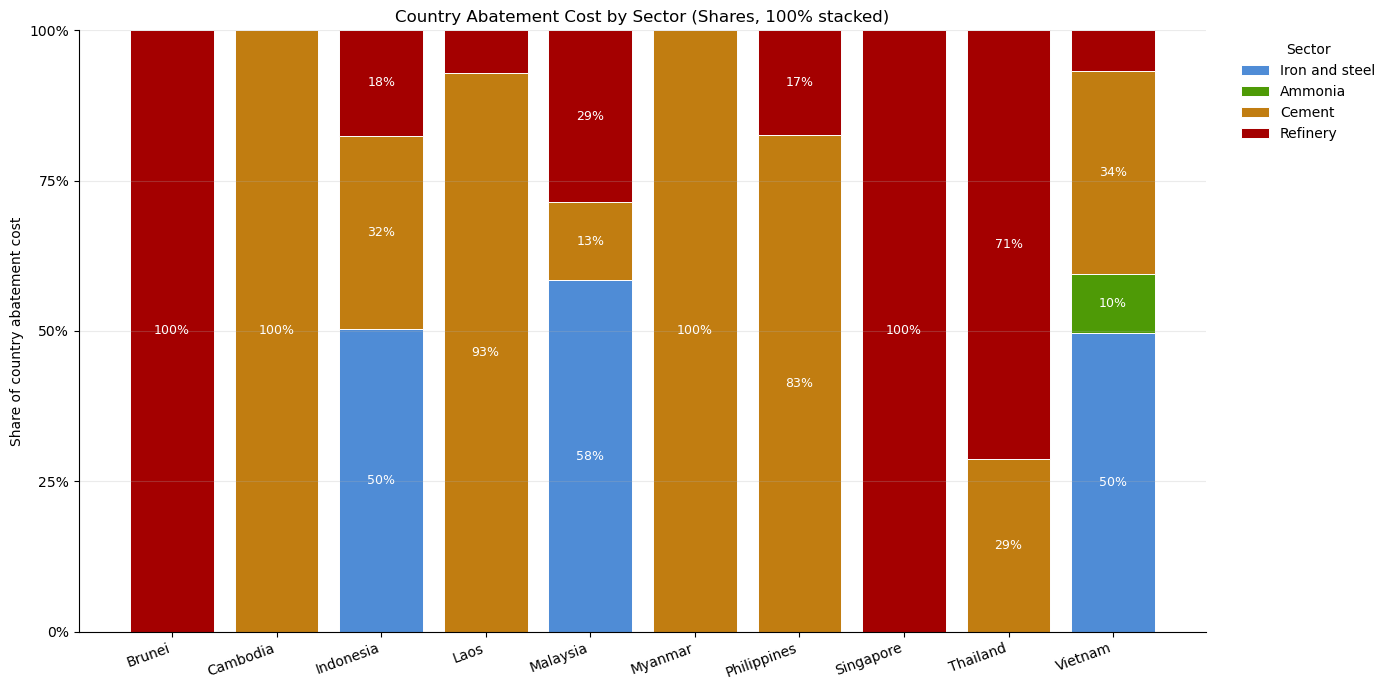

In [386]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd  # just in case

# =========================================================
# Country × Sector Abatement Cost → stacked bars (level & share)
# =========================================================
# Expects from previous cells:
#  - preview_df with 'Abate_Cost' already computed
#  - 'Country_Display' column exists (short names)
#  - plot_countries: desired country order (short names)
#  - sector_names: ['Iron_and_steel', 'Ammonia', 'Cement', 'Refinery']

# 1) Safety: ensure numeric & required cols
_df = preview_df.copy()
for col in ["Abate_Cost", "Carbon_Intensity", "Actual_Production", "CO2_Capture"]:
    if col in _df.columns:
        _df[col] = pd.to_numeric(_df[col], errors="coerce").fillna(0.0)
if "Country_Display" not in _df.columns:
    _df["Country_Display"] = _df["Country"]  # fallback if not already set

# 2) Aggregate Abatement Cost by Country × Sector
pivot_abate_abs = (
    _df.groupby(["Country_Display", "Sector"], observed=False)["Abate_Cost"]
       .sum()
       .unstack(fill_value=0.0)
)

# Enforce consistent ordering
row_order = [c for c in plot_countries if c in pivot_abate_abs.index]
col_order = [s for s in sector_names if s in pivot_abate_abs.columns]
pivot_abate_abs = pivot_abate_abs.reindex(index=row_order, columns=col_order, fill_value=0.0)

# Totals per country (for sorting/annotation)
row_totals = pivot_abate_abs.sum(axis=1)

# 3) Sector color palette (consistent with earlier)
sector_colors = {
    "Iron_and_steel": (79/255, 140/255, 214/255),  # blue
    "Ammonia":        (78/255, 154/255, 6/255),    # green
    "Cement":         (193/255, 125/255, 17/255),  # orange-brown
    "Refinery":       (164/255, 0/255, 0/255),     # red
}
bar_colors = [sector_colors.get(s, (0.6, 0.6, 0.6)) for s in col_order]

# ---------- A) Absolute stacked bar: Abatement cost per country ----------
countries = pivot_abate_abs.index.tolist()
x = np.arange(len(countries))
width = 0.8

fig, ax = plt.subplots(figsize=(14, 7))
bottom = np.zeros(len(countries), dtype=float)

for s, color in zip(col_order, bar_colors):
    vals = pivot_abate_abs[s].values
    ax.bar(
        x, vals, width=width, bottom=bottom,
        color=color, edgecolor="white", linewidth=0.7,
        label=s.replace("_", " ")
    )
    bottom += vals

# Annotate totals on top (as $ billions for readability)
for xi, total in zip(x, row_totals.values):
    if total > 0:
        ax.text(xi, total * 1.01, f"${total/1e9:.2f}B",
                ha="center", va="bottom", fontsize=10, color="#222")

ax.set_xticks(x)
ax.set_xticklabels(countries, rotation=20, ha="right")
ax.set_ylabel("Abatement Cost (USD)")
ax.set_title("Country Abatement Cost by Sector (Stacked)")
ax.grid(axis="y", alpha=0.25)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.legend(title="Sector", ncol=1, frameon=False, bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()

# ---------- B) 100% stacked bar: Sector share of each country's abatement ----------
# Avoid divide-by-zero by using 1 where total is 0 (the bar will be all zeros anyway)
den = row_totals.replace(0, 1.0).values.reshape(-1, 1)
pivot_abate_share = pivot_abate_abs.div(den.squeeze(), axis=0)

fig, ax = plt.subplots(figsize=(14, 7))
bottom = np.zeros(len(countries), dtype=float)

for s, color in zip(col_order, bar_colors):
    vals = pivot_abate_share[s].values
    ax.bar(
        x, vals, width=width, bottom=bottom,
        color=color, edgecolor="white", linewidth=0.7,
        label=s.replace("_", " ")
    )
    # Annotate segments ≥ 8% to reduce clutter
    for xi, y0, v in zip(x, bottom, vals):
        if v >= 0.08:
            ax.text(xi, y0 + v/2, f"{v*100:.0f}%",
                    ha="center", va="center", fontsize=9, color="white")
    bottom += vals

ax.set_xticks(x)
ax.set_xticklabels(countries, rotation=20, ha="right")
ax.set_ylim(0, 1)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
ax.set_yticklabels(["0%", "25%", "50%", "75%", "100%"])
ax.set_ylabel("Share of country abatement cost")
ax.set_title("Country Abatement Cost by Sector (Shares, 100% stacked)")
ax.grid(axis="y", alpha=0.25)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.legend(title="Sector", ncol=1, frameon=False, bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()


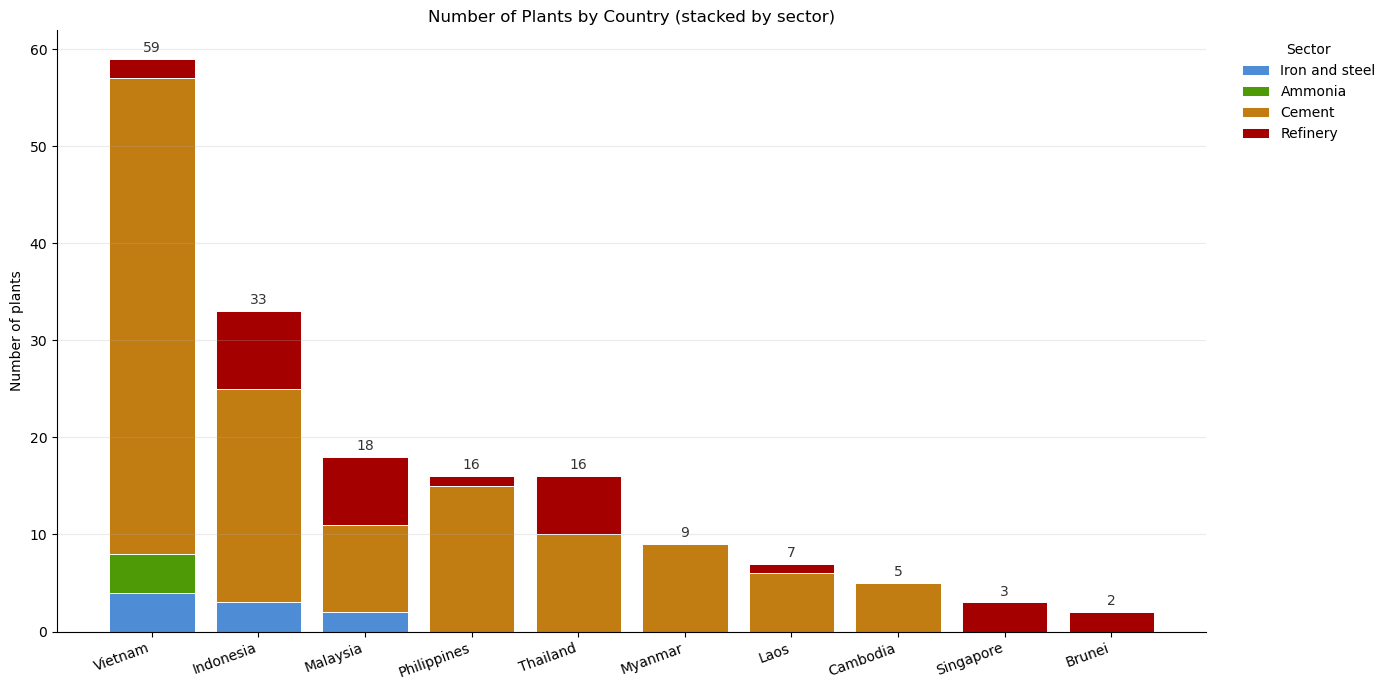

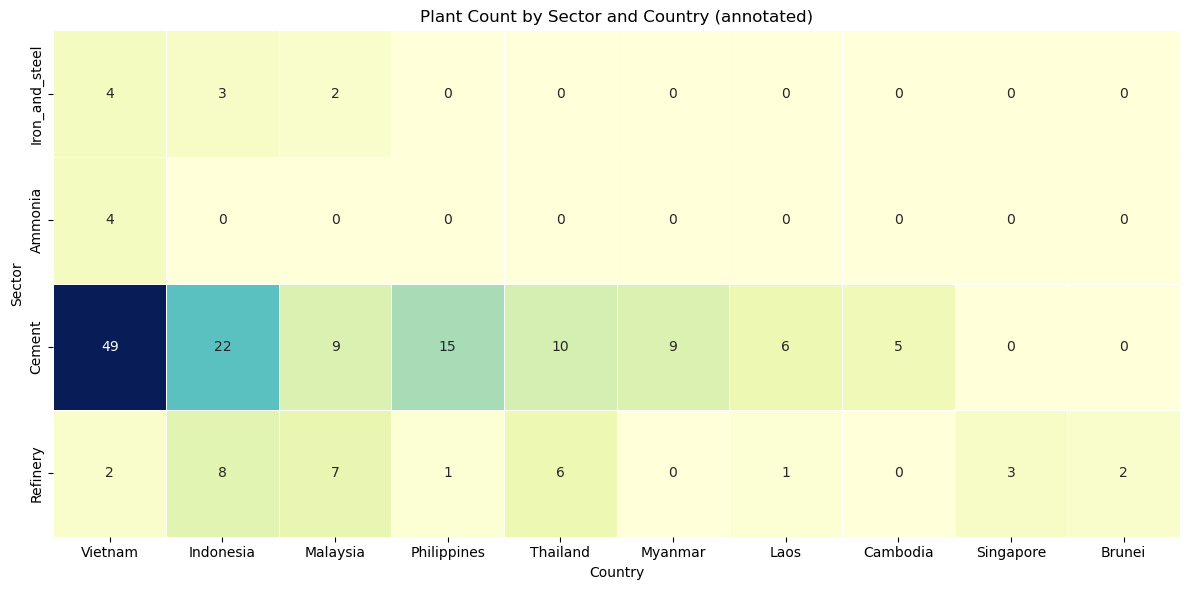

In [387]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1) Prepare plant counts per sector per country ---
# Make sure we have the short names column (already created in your cell)
# preview_df['Country_Display'] = preview_df['Country'].replace(display_names)

# Count distinct plants by Country x Sector
counts = (
    preview_df
    .groupby(['Country_Display', 'Sector'], observed=False)['Plant']
    .nunique()
    .unstack(fill_value=0)
)

# Ensure consistent ordering with your existing plot_countries and sector_names
# (falls back to whatever is present if a label is missing)
idx = [c for c in plot_countries if c in counts.index]
cols = [s for s in sector_names if s in counts.columns]
counts = counts.reindex(index=idx, columns=cols, fill_value=0)

# Add total column for sorting and annotation
counts['Total_Plants'] = counts.sum(axis=1)
counts_sorted = counts.sort_values('Total_Plants', ascending=False)
countries_sorted = counts_sorted.index.tolist()

# Sector color palette (consistent with your thesis visuals)
sector_colors = {
    "Iron_and_steel": (79/255, 140/255, 214/255),  # blue
    "Ammonia":        (78/255, 154/255, 6/255),    # green
    "Cement":         (193/255, 125/255, 17/255),  # orange-brown
    "Refinery":       (164/255, 0/255, 0/255),     # red
}

# --- 2) STACKED BAR: Plant count per country (sorted by total) ---
fig, ax = plt.subplots(figsize=(14, 7))

bottom = np.zeros(len(countries_sorted), dtype=float)
x = np.arange(len(countries_sorted))

for s in cols:
    vals = counts_sorted[s].values
    ax.bar(
        x, vals, bottom=bottom,
        color=sector_colors.get(s, '#888'),
        edgecolor='white', linewidth=0.7,
        label=s.replace('_', ' ')
    )
    bottom += vals

# Annotate totals on top of each country bar
for xi, total in zip(x, counts_sorted['Total_Plants'].values):
    if total > 0:
        ax.text(xi, total + 0.4, f"{int(total)}", ha='center', va='bottom', fontsize=10, color='#333')

ax.set_xticks(x)
ax.set_xticklabels(countries_sorted, rotation=20, ha='right')
ax.set_ylabel("Number of plants")
ax.set_title("Number of Plants by Country (stacked by sector)")
ax.grid(axis='y', alpha=0.25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(title="Sector", ncol=1, frameon=False, bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.show()

# --- 3) HEATMAP: Fast ranking by sector × country (counts annotated) ---
fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(
    counts_sorted[cols].T,  # sectors as rows, countries as columns
    annot=True, fmt='d',
    cmap='YlGnBu',
    cbar=False,
    linewidths=0.5, linecolor='white'
)
ax.set_xlabel("Country")
ax.set_ylabel("Sector")
ax.set_title("Plant Count by Sector and Country (annotated)")
plt.tight_layout()
plt.show()


### A. For each scenario in results_df, compute tax paid per country

In [388]:
import numpy as np

# --- Ensure short country names ---
display_names = {
    'Lao People\'s Democratic Republic': 'Laos',
    'Brunei Darussalam': 'Brunei'
}
preview_df['Country_Display'] = preview_df['Country'].replace(display_names)
plot_countries = [display_names.get(c, c) for c in preview_df['Country'].unique()]
sector_names = preview_df['Sector'].unique()

# --- Calculate per (country, sector) emissions ---
# Compute plant-level emissions first
preview_df['Plant_Emissions'] = preview_df['Carbon_Intensity'] * preview_df['Actual_Production']

# Now group and sum by country and sector
country_sector_emissions = (
    preview_df.groupby(['Country_Display', 'Sector'])['Plant_Emissions'].sum().to_dict()
)


# --- Create a copy of results_df for new calculations ---
results_country_tax = results_df.copy()

# --- For each scenario, each country: sum up all sector taxes with their own rate ---
for country in plot_countries:
    total_tax = np.zeros(len(results_country_tax))
    for sector in sector_names:
        emissions = country_sector_emissions.get((country, sector), 0)
        if emissions > 0:
            colname = f'Carbon Tax [{sector}]'
            total_tax += results_country_tax[colname].fillna(0) * emissions
    results_country_tax[f'TaxPaid_{country}'] = total_tax

# Now results_country_tax has your new country-level tax paid columns, 
# and original results_df is untouched.
results_country_tax[[f'TaxPaid_{country}' for country in plot_countries]].head(20)


TaxPaid_Indonesia  TaxPaid_Malaysia  TaxPaid_Vietnam  TaxPaid_Cambodia  \
0        0.000000e+00      0.000000e+00     0.000000e+00      0.000000e+00   
1        0.000000e+00      0.000000e+00     0.000000e+00      0.000000e+00   
2        0.000000e+00      0.000000e+00     0.000000e+00      0.000000e+00   
3        0.000000e+00      0.000000e+00     0.000000e+00      0.000000e+00   
4        0.000000e+00      0.000000e+00     0.000000e+00      0.000000e+00   
5        2.457106e+09      1.246960e+09     2.880346e+09      1.191440e+08   
6        2.438561e+09      1.379955e+09     2.817160e+09      8.756758e+07   
7        2.420016e+09      1.512951e+09     2.753973e+09      5.599115e+07   
8        2.401471e+09      1.645947e+09     2.690787e+09      2.441472e+07   
9        2.366045e+09      1.739587e+09     2.612196e+09      0.000000e+00   
10       2.273070e+09      1.699059e+09     2.481090e+09      0.000000e+00   
11       0.000000e+00      0.000000e+00     0.000000e+00      0.000000e+00   
12       0.000000e+00      0.000000e+00     0.000000e+00      0.000000e+00   
13       0.000000e+00      0.000000e+00     0.000000e+00      0.000000e+00   
14       0.000000e+00      0.000000e+00     0.000000e+00      0.000000e+00   
15       0.000000e+00      0.000000e+00     0.000000e+00      0.000000e+00   
16       2.457106e+09      1.246960e+09     2.880346e+09      1.191440e+08   
17       2.438561e+09      1.379955e+09     2.817160e+09      8.756758e+07   
18       2.420016e+09      1.512951e+09     2.753973e+09      5.599115e+07   
19       2.401471e+09      1.645947e+09     2.690787e+09      2.441472e+07   

    TaxPaid_Laos  TaxPaid_Myanmar  TaxPaid_Philippines  TaxPaid_Thailand  \
0   0.000000e+00     0.000000e+00         0.000000e+00      0.000000e+00   
1   0.000000e+00     0.000000e+00         0.000000e+00      0.000000e+00   
2   0.000000e+00     0.000000e+00         0.000000e+00      0.000000e+00   
3   0.000000e+00     0.000000e+00         0.000000e+00      0.000000e+00   
4   0.000000e+00     0.000000e+00         0.000000e+00      0.000000e+00   
5   9.779831e+07     1.954781e+08         4.299724e+08      1.053169e+09   
6   7.399431e+07     1.436711e+08         3.398377e+08      1.075360e+09   
7   5.019030e+07     9.186400e+07         2.497031e+08      1.097550e+09   
8   2.638630e+07     4.005693e+07         1.595684e+08      1.119740e+09   
9   8.187511e+06     0.000000e+00         9.220027e+07      1.166289e+09   
10  9.097235e+06     0.000000e+00         1.024447e+08      1.295877e+09   
11  0.000000e+00     0.000000e+00         0.000000e+00      0.000000e+00   
12  0.000000e+00     0.000000e+00         0.000000e+00      0.000000e+00   
13  0.000000e+00     0.000000e+00         0.000000e+00      0.000000e+00   
14  0.000000e+00     0.000000e+00         0.000000e+00      0.000000e+00   
15  0.000000e+00     0.000000e+00         0.000000e+00      0.000000e+00   
16  9.779831e+07     1.954781e+08         4.299724e+08      1.053169e+09   
17  7.399431e+07     1.436711e+08         3.398377e+08      1.075360e+09   
18  5.019030e+07     9.186400e+07         2.497031e+08      1.097550e+09   
19  2.638630e+07     4.005693e+07         1.595684e+08      1.119740e+09   

    TaxPaid_Brunei  TaxPaid_Singapore  
0     0.000000e+00       0.000000e+00  
1     0.000000e+00       0.000000e+00  
2     0.000000e+00       0.000000e+00  
3     0.000000e+00       0.000000e+00  
4     0.000000e+00       0.000000e+00  
5     9.827638e+07       5.210599e+08  
6     1.179317e+08       6.252718e+08  
7     1.375869e+08       7.294838e+08  
8     1.572422e+08       8.336958e+08  
9     1.768975e+08       9.379077e+08  
10    1.965528e+08       1.042120e+09  
11    0.000000e+00       0.000000e+00  
12    0.000000e+00       0.000000e+00  
13    0.000000e+00       0.000000e+00  
14    0.000000e+00       0.000000e+00  
15    0.000000e+00       0.000000e+00  
16    9.827638e+07       5.210599e+08  
17    1.179317e+08       6.252718e+08  
18    1.

In [389]:
# --- List of per-country tax paid columns (in same order as plot_countries) ---
country_tax_cols = [f'TaxPaid_{country}' for country in plot_countries]

# --- Melt to long format for easier plotting/analysis ---
tax_paid_long = results_country_tax.melt(
    id_vars=['ETS_Cap', 'Tax_Cap', 'Funding Gap'] if 'Funding Gap' in results_country_tax.columns else ['ETS_Cap', 'Tax_Cap'],
    value_vars=country_tax_cols,
    var_name='Country',
    value_name='TaxPaid'
)
# Extract clean country name
tax_paid_long['Country'] = tax_paid_long['Country'].str.replace('TaxPaid_', '')

# --- Compute summary statistics ---
summary_country = tax_paid_long.groupby('Country').agg(
    total_tax_paid=('TaxPaid', 'sum'),
    mean_tax_paid=('TaxPaid', 'mean'),
    median_tax_paid=('TaxPaid', 'median'),
    max_tax_paid=('TaxPaid', 'max'),
    min_tax_paid=('TaxPaid', 'min')
).reset_index()

print(summary_country)


       Country  total_tax_paid  mean_tax_paid  median_tax_paid  max_tax_paid  \
0       Brunei    7.980042e+09   6.595076e+07     3.931055e+07  1.965528e+08   
1     Cambodia    3.512832e+09   2.903167e+07     0.000000e+00  1.191440e+08   
2    Indonesia    1.385579e+11   1.145107e+09     1.030772e+09  2.457106e+09   
3         Laos    3.118714e+09   2.577449e+07     8.187511e+06  9.779831e+07   
4     Malaysia    8.551931e+10   7.067711e+08     5.097234e+08  1.739587e+09   
5      Myanmar    5.763460e+09   4.763190e+07     0.000000e+00  1.954781e+08   
6  Philippines    1.532629e+10   1.266636e+08     9.220027e+07  4.299724e+08   
7    Singapore    4.231006e+10   3.496699e+08     2.084239e+08  1.042120e+09   
8     Thailand    6.456039e+10   5.335569e+08     4.389785e+08  1.295877e+09   
9      Vietnam    1.577654e+11   1.303847e+09     1.212219e+09  2.880346e+09   

   min_tax_paid  
0           0.0  
1           0.0  
2           0.0  
3           0.0  
4           0.0  
5          

### Distribution of Country-level tax pay

C:\Users\Keerati\AppData\Local\Temp\ipykernel_30108\3474728.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


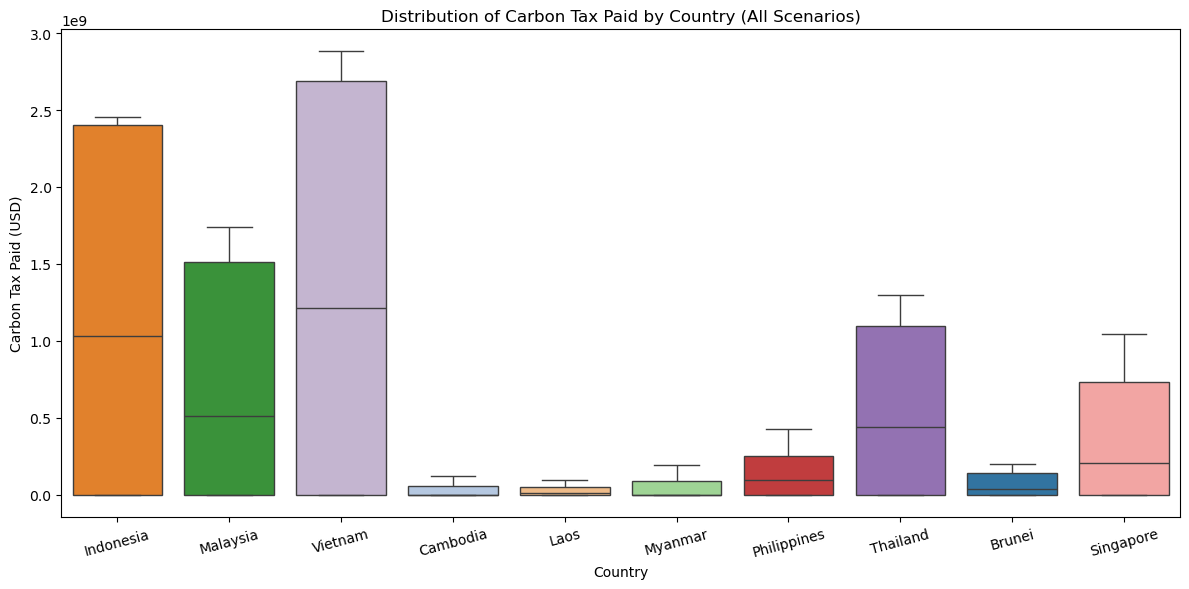

In [390]:
import seaborn as sns
import matplotlib.pyplot as plt

# Make sure tax_paid_long uses the short, display-friendly country names
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=tax_paid_long,
    x='Country',
    y='TaxPaid',
    order=plot_countries,  # ensure correct country order
    palette=[country_colors[c] for c in plot_countries]
)
plt.title('Distribution of Carbon Tax Paid by Country (All Scenarios)')
plt.ylabel('Carbon Tax Paid (USD)')
plt.xlabel('Country')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


## Identify 'The most affordable, feasible' Scenarios for country level

In [391]:
import numpy as np

# 1. Filter feasible scenarios (for your country-level DataFrame)
feasible_df = results_country_tax[results_country_tax['Status'] == 'optimal'].copy()
print("Scenarios considered feasible:", len(feasible_df))

# 2. Compute Total Policy Paid by Each Country in Each Scenario
def country_policy_paid(row, country, preview_df):
    # For each sector in this country, compute ETS and Tax paid using correct formula
    total_paid = 0
    for sector in sector_names:
        # Filter plants for this (country, sector) pair
        sector_plants = preview_df[(preview_df['Country_Display'] == country) & (preview_df['Sector'] == sector)]
        if sector_plants.empty:
            continue
        # Safely get values or set to 0 if NaN
        ets_price = row.get('ETS Price', 0) if not np.isnan(row.get('ETS Price', np.nan)) else 0
        tax = row.get(f'Carbon Tax [{sector}]', 0) if not np.isnan(row.get(f'Carbon Tax [{sector}]', np.nan)) else 0
        # ETS paid (exempt anything covered by the Emission Cap)
        ets_paid = ets_price * (sector_plants['Carbon_Intensity'] * sector_plants['Actual_Production'] * (1 - sector_plants['Emission_Cap'])).sum()
        # Tax paid (only for in-jurisdiction GHG emissions)
        tax_paid = tax * (sector_plants['Carbon_Intensity'] * sector_plants['Actual_Production'] * sector_plants['Jurisdiction_GHG']).sum()
        total_paid += ets_paid + tax_paid
    return total_paid

# Calculate for all countries and cache in feasible_df
for country in plot_countries:
    feasible_df[f'TotalPolicyPaid_{country}'] = feasible_df.apply(lambda row: country_policy_paid(row, country, preview_df), axis=1)

# 3. For Each Country, Find Scenario with Minimum Cost
print("\n--- Cheapest Feasible Scenario for Each Country ---")
min_country_scenarios = {}
for country in plot_countries:
    col = f'TotalPolicyPaid_{country}'
    country_valid = feasible_df[feasible_df[col].notnull() & (feasible_df[col] > 0)]
    if not country_valid.empty:
        idx = country_valid[col].idxmin()
        min_country_scenarios[country] = feasible_df.loc[idx]
        print(f"Country: {country}")
        print(min_country_scenarios[country][['ETS_Cap', 'Tax_Cap', 'ETS Price'] +
                                             [f'Carbon Tax [{sector}]' for sector in sector_names] +
                                             [col]])
        print("-" * 40)
    else:
        print(f"Country: {country} - No valid scenarios found.")
        print("-" * 40)

# Diagnostic check: number of scenarios per country
for col in [f'TotalPolicyPaid_{c}' for c in plot_countries]:
    print(f"{col}: not null = {feasible_df[col].notnull().sum()}, > 0 = {(feasible_df[col] >= 0).sum()}")

# 4. Minimum Cost for All Countries
country_cost_cols = [f'TotalPolicyPaid_{c}' for c in plot_countries]
feasible_df['TotalPolicyPaid_All'] = feasible_df[country_cost_cols].sum(axis=1)
# Only consider if at least one country pays something -> Just Changed to >=0
valid_all = feasible_df[feasible_df['TotalPolicyPaid_All'] >= 0]
if not valid_all.empty:
    idx_all = valid_all['TotalPolicyPaid_All'].idxmin()
    best_overall = feasible_df.loc[idx_all]
    print("\nBest Overall Scenario (min total policy paid by all countries):")
    print(best_overall[['ETS_Cap', 'Tax_Cap', 'ETS Price'] +
                       [f'Carbon Tax [{s}]' for s in sector_names] +
                       ['TotalPolicyPaid_All'] +
                       country_cost_cols])
else:
    print("\nNo valid overall scenario found (no total policy payment > 0).")


Scenarios considered feasible: 96

--- Cheapest Feasible Scenario for Each Country ---
Country: Indonesia
ETS_Cap                                        0
Tax_Cap                                      100
ETS Price                                    0.0
Carbon Tax [Iron_and_steel]            77.068499
Carbon Tax [Ammonia]                       100.0
Carbon Tax [Cement]                          0.0
Carbon Tax [Refinery]                      100.0
TotalPolicyPaid_Indonesia      2273070296.303637
Name: 10, dtype: object
----------------------------------------
Country: Malaysia
ETS_Cap                                       20
Tax_Cap                                       40
ETS Price                              12.926388
Carbon Tax [Iron_and_steel]                 40.0
Carbon Tax [Ammonia]                        40.0
Carbon Tax [Cement]                         40.0
Carbon Tax [Refinery]                       40.0
TotalPolicyPaid_Malaysia       1217113204.229559
Name: 26, dtype: object
---

# Result Visualisation  

### 1. Bar Chart: Minimum Total Policy Paid per Sector

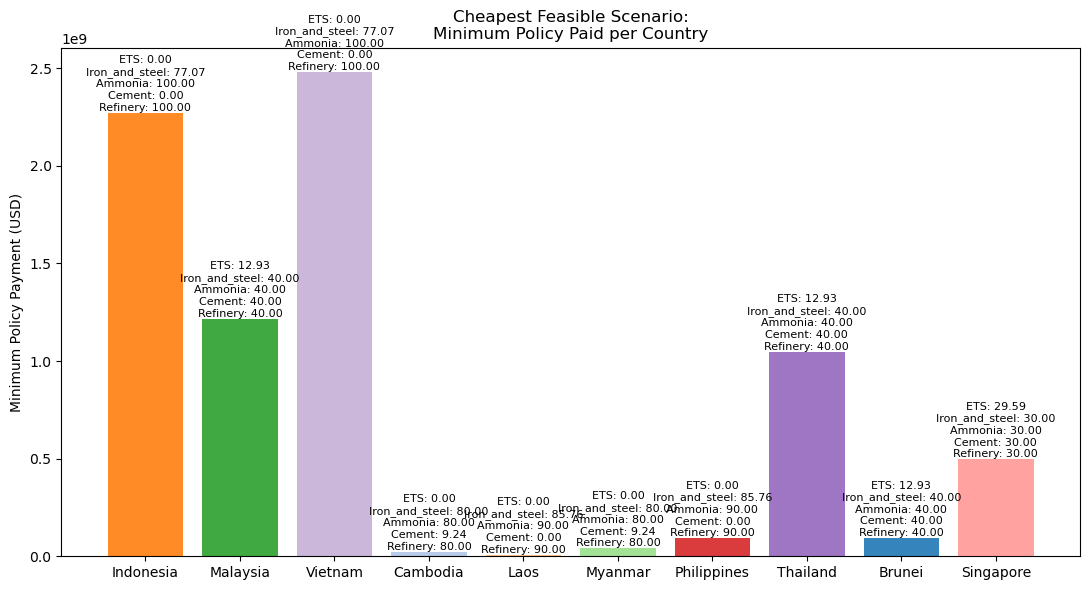

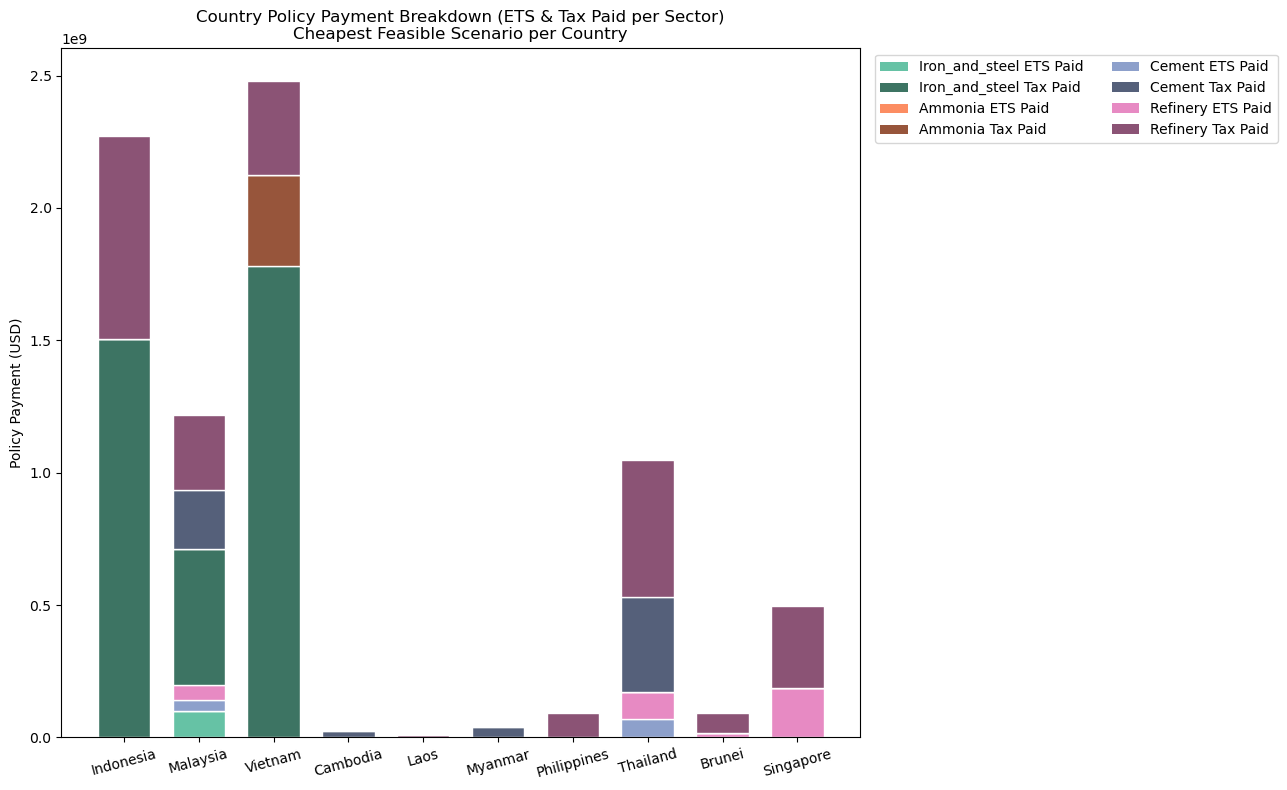

In [392]:
import matplotlib.pyplot as plt

country_labels = []
min_paid = []
ets_prices = []
tax_caps = []

for country, row in min_country_scenarios.items():
    country_labels.append(country)
    min_paid.append(row[f"TotalPolicyPaid_{country}"])
    ets_prices.append(row["ETS Price"])
    # We'll keep tax_caps as a list of lists (for potential summary stats)
    tax_caps.append([row.get(f"Carbon Tax [{sector}]", 0) for sector in sector_names])

bar_colors = [country_colors[c] for c in country_labels]

plt.figure(figsize=(11, 6))
bars = plt.bar(country_labels, min_paid, color=bar_colors, alpha=0.90)
plt.ylabel("Minimum Policy Payment (USD)")
plt.title("Cheapest Feasible Scenario:\nMinimum Policy Paid per Country")

# Annotate with ETS price and all sector taxes used
for i, bar in enumerate(bars):
    tax_values = tax_caps[i]
    tax_str = "\n".join([f"{sector}: {tax:.2f}" for sector, tax in zip(sector_names, tax_values)])
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f"ETS: {ets_prices[i]:.2f}\n{tax_str}",
             ha="center", va="bottom", fontsize=8, color="black")

plt.tight_layout()
plt.show()

# For Stacked Bar chart addressing Carbon Tax and ETS money 

# For color consistency
sector_colors = plt.get_cmap('Set2').colors
sector_color_map = {sector: sector_colors[i % len(sector_colors)] for i, sector in enumerate(sector_names)}

def darken(color, factor=0.6):
    # Linearly darken RGB tuple toward black
    return tuple(np.array(color) * factor)

country_labels = []
ets_stacks = {sector: [] for sector in sector_names}
tax_stacks = {sector: [] for sector in sector_names}

for country in plot_countries:
    row = min_country_scenarios[country]
    country_labels.append(country)
    for sector in sector_names:
        plants = preview_df[(preview_df['Country_Display'] == country) & (preview_df['Sector'] == sector)]
        if plants.empty:
            ets_paid = 0
            tax_paid = 0
        else:
            ets_price = row.get('ETS Price', 0) if not np.isnan(row.get('ETS Price', np.nan)) else 0
            tax = row.get(f'Carbon Tax [{sector}]', 0) if not np.isnan(row.get(f'Carbon Tax [{sector}]', np.nan)) else 0
            ets_paid = ets_price * (plants['Carbon_Intensity'] * plants['Actual_Production'] * (1 - plants['Emission_Cap'])).sum()
            tax_paid = tax * (plants['Carbon_Intensity'] * plants['Actual_Production'] * plants['Jurisdiction_GHG']).sum()
        ets_stacks[sector].append(ets_paid)
        tax_stacks[sector].append(tax_paid)

ind = np.arange(len(country_labels))
bar_width = 0.7

plt.figure(figsize=(13, 8))

bottom = np.zeros(len(country_labels))
# ETS paid stacks (lighter/original color)
for sector in sector_names:
    plt.bar(
        ind, ets_stacks[sector], bar_width,
        bottom=bottom,
        color=sector_color_map[sector],
        edgecolor='white',
        label=f"{sector} ETS Paid"  # Only label once
    )
    bottom += np.array(ets_stacks[sector])

# Tax paid stacks (darker color)
for sector in sector_names:
    plt.bar(
        ind, tax_stacks[sector], bar_width,
        bottom=bottom,
        color=darken(sector_color_map[sector], 0.6),
        edgecolor='white',
        label=f"{sector} Tax Paid"
    )
    bottom += np.array(tax_stacks[sector])

plt.xticks(ind, country_labels, rotation=15)
plt.ylabel("Policy Payment (USD)")
plt.title("Country Policy Payment Breakdown (ETS & Tax Paid per Sector)\nCheapest Feasible Scenario per Country")

# Custom legend: Only show each sector's ETS and Tax once
from matplotlib.patches import Patch
handles = []
for sector in sector_names:
    handles.append(Patch(facecolor=sector_color_map[sector], label=f"{sector} ETS Paid"))
    handles.append(Patch(facecolor=darken(sector_color_map[sector], 0.6), label=f"{sector} Tax Paid"))
plt.legend(handles=handles, bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=10, ncol=2)

plt.tight_layout()
plt.show()



### 2. Stacked Bar: All-Sector Cheapest Scenario

       Country  ETS_Cap  Tax_Cap  ETS_Price  Tax_Iron_and_steel  Tax_Ammonia  \
0    Indonesia        0       50          0                  50           50   
1     Malaysia        0       50          0                  50           50   
2      Vietnam        0       50          0                  50           50   
3     Cambodia        0       50          0                  50           50   
4         Laos        0       50          0                  50           50   
5      Myanmar        0       50          0                  50           50   
6  Philippines        0       50          0                  50           50   
7     Thailand        0       50          0                  50           50   
8       Brunei        0       50          0                  50           50   
9    Singapore        0       50          0                  50           50   

   Tax_Cement  Tax_Refinery  ETS_Paid_Iron_and_steel  ETS_Paid_Ammonia  \
0          45            50                  

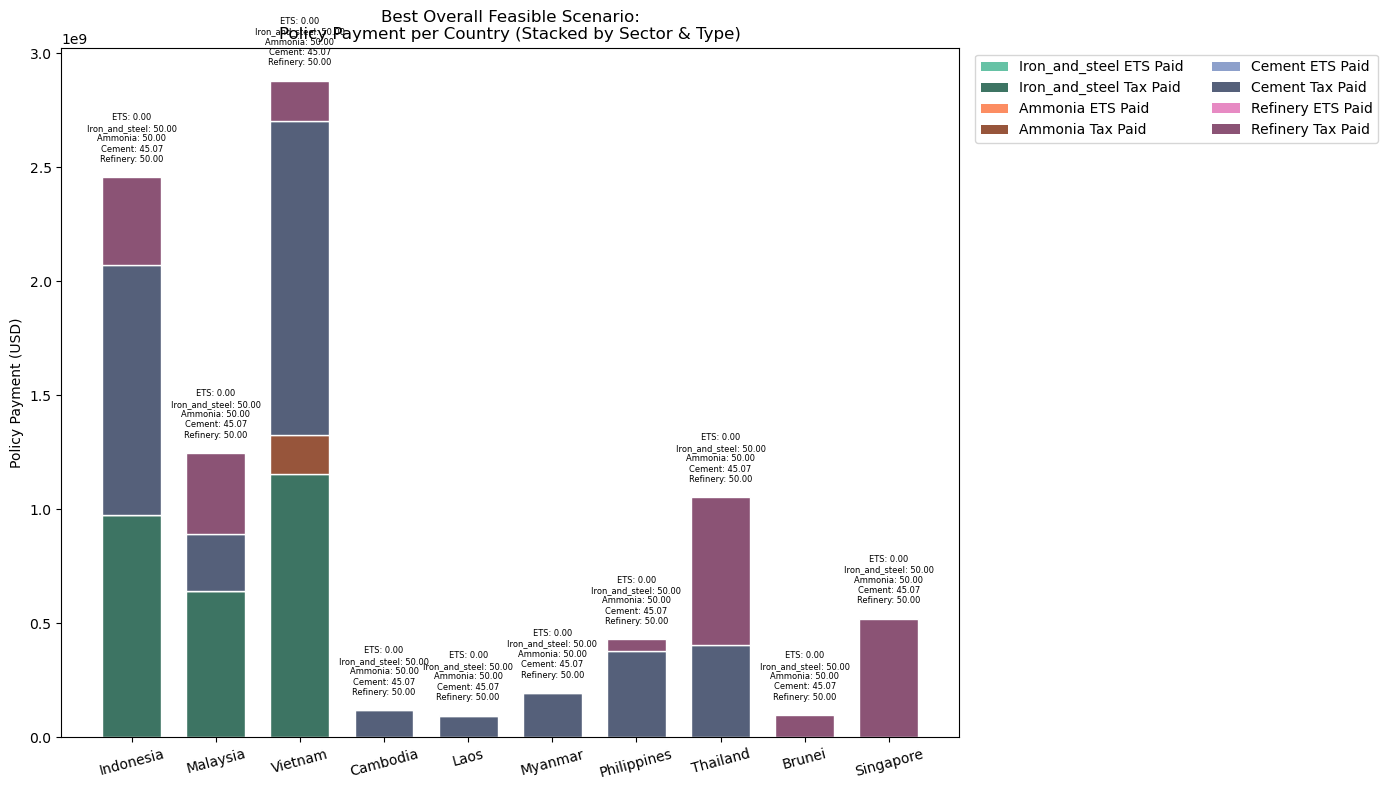

In [393]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Show the best overall scenario in table format

# Prepare lists for the table
table_rows = []
for i, country in enumerate(plot_countries):
    ets_paid = 0
    tax_paid = 0
    sector_ets_paid = {}
    sector_tax_paid = {}
    for sector in sector_names:
        plants = preview_df[(preview_df['Country_Display'] == country) & (preview_df['Sector'] == sector)]
        ets_price = best_overall.get('ETS Price', 0) if not np.isnan(best_overall.get('ETS Price', np.nan)) else 0
        tax = best_overall.get(f'Carbon Tax [{sector}]', 0) if not np.isnan(best_overall.get(f'Carbon Tax [{sector}]', np.nan)) else 0
        ets_val = ets_price * (plants['Carbon_Intensity'] * plants['Actual_Production'] * (1 - plants['Emission_Cap'])).sum() if not plants.empty else 0
        tax_val = tax * (plants['Carbon_Intensity'] * plants['Actual_Production'] * plants['Jurisdiction_GHG']).sum() if not plants.empty else 0
        sector_ets_paid[sector] = ets_val
        sector_tax_paid[sector] = tax_val
        ets_paid += ets_val
        tax_paid += tax_val
    total_paid = ets_paid + tax_paid
    table_rows.append({
        'Country': country,
        'ETS_Cap': best_overall['ETS_Cap'],
        'Tax_Cap': best_overall['Tax_Cap'],
        'ETS_Price': best_overall['ETS Price'],
        **{f"Tax_{sector}": best_overall.get(f'Carbon Tax [{sector}]', 0) for sector in sector_names},
        **{f"ETS_Paid_{sector}": sector_ets_paid[sector] for sector in sector_names},
        **{f"Tax_Paid_{sector}": sector_tax_paid[sector] for sector in sector_names},
        'Total_ETS_Paid': ets_paid,
        'Total_Tax_Paid': tax_paid,
        'Total_Paid': total_paid,
    })

best_scenario_country_df = pd.DataFrame(table_rows)

# Print the full table (or slice/format as needed)
with pd.option_context('display.float_format', '{:,.0f}'.format):
    print(best_scenario_country_df)

# Optionally, to show only a summary:
summary_cols = ['Country', 'ETS_Cap', 'Tax_Cap', 'ETS_Price', 'Total_ETS_Paid', 'Total_Tax_Paid', 'Total_Paid']
with pd.option_context('display.float_format', '{:,.0f}'.format):
    print(best_scenario_country_df[summary_cols])


# Build the data for best_overall
ets_paid_data = {sector: [] for sector in sector_names}
tax_paid_data = {sector: [] for sector in sector_names}

# For each country, calculate by sector ETS and Tax paid (using the best_overall scenario)
for country in plot_countries:
    for sector in sector_names:
        plants = preview_df[(preview_df['Country_Display'] == country) & (preview_df['Sector'] == sector)]
        if plants.empty:
            ets_paid = 0
            tax_paid = 0
        else:
            ets_price = best_overall.get('ETS Price', 0) if not np.isnan(best_overall.get('ETS Price', np.nan)) else 0
            tax = best_overall.get(f'Carbon Tax [{sector}]', 0) if not np.isnan(best_overall.get(f'Carbon Tax [{sector}]', np.nan)) else 0
            ets_paid = ets_price * (plants['Carbon_Intensity'] * plants['Actual_Production'] * (1 - plants['Emission_Cap'])).sum()
            tax_paid = tax * (plants['Carbon_Intensity'] * plants['Actual_Production'] * plants['Jurisdiction_GHG']).sum()
        ets_paid_data[sector].append(ets_paid)
        tax_paid_data[sector].append(tax_paid)

ind = np.arange(len(plot_countries))
bar_width = 0.7

plt.figure(figsize=(14, 8))
bottom = np.zeros(len(plot_countries))
sector_colors = plt.get_cmap('Set2').colors
sector_color_map = {sector: sector_colors[i % len(sector_colors)] for i, sector in enumerate(sector_names)}

# Stacked ETS
for sector in sector_names:
    plt.bar(
        ind, ets_paid_data[sector], bar_width,
        bottom=bottom,
        color=sector_color_map[sector],
        edgecolor='white',
        label=f"{sector} ETS Paid"
    )
    bottom += np.array(ets_paid_data[sector])

# Stacked Tax (darker color)
for sector in sector_names:
    plt.bar(
        ind, tax_paid_data[sector], bar_width,
        bottom=bottom,
        color=tuple(np.array(sector_color_map[sector]) * 0.6),
        edgecolor='white',
        label=f"{sector} Tax Paid"
    )
    bottom += np.array(tax_paid_data[sector])

plt.xticks(ind, plot_countries, rotation=15)
plt.ylabel("Policy Payment (USD)")
plt.title("Best Overall Feasible Scenario:\nPolicy Payment per Country (Stacked by Sector & Type)")

# Custom legend
handles = []
for sector in sector_names:
    handles.append(Patch(facecolor=sector_color_map[sector], label=f"{sector} ETS Paid"))
    handles.append(Patch(facecolor=tuple(np.array(sector_color_map[sector]) * 0.6), label=f"{sector} Tax Paid"))
plt.legend(handles=handles, bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=10, ncol=2)

# Annotate each bar with ETS price and all sector taxes
for i, country in enumerate(plot_countries):
    # Get values
    ets_price = best_overall.get('ETS Price', 0)
    tax_values = [best_overall.get(f'Carbon Tax [{sector}]', 0) for sector in sector_names]
    tax_str = "\n".join([f"{sector}: {tax:.2f}" for sector, tax in zip(sector_names, tax_values)])
    text = f"ETS: {ets_price:.2f}\n{tax_str}"
    # Place annotation just above the bar
    plt.text(
        i, bottom[i] + 0.02 * max(bottom),  # position: above bar
        text,
        ha='center', va='bottom', fontsize=6, color='black'
    )

plt.tight_layout()
plt.show()


## Country-level Analysis - with Sensitivity Analysis Result

### compute All Policy Paid Columns for Feasible Scenarios

In [394]:
import numpy as np

# --- Only use feasible scenarios ---
feasible_country = results_csv[results_csv['Feasible'].isin([1, True, "True"]) & (results_csv['Funding_Gap'] <= 0)].copy()

# --- Prepare names and emissions ---
display_names = {
    'Lao People\'s Democratic Republic': 'Laos',
    'Brunei Darussalam': 'Brunei'
}
preview_df['Country_Display'] = preview_df['Country'].replace(display_names)
country_names = [display_names.get(c, c) for c in preview_df['Country'].unique()]
sector_names = ['Iron_and_steel', 'Ammonia', 'Cement', 'Refinery']

# --- Calculate total emissions per (country, sector) ---
if "Plant_Emissions" not in preview_df.columns:
    preview_df["Plant_Emissions"] = preview_df["Carbon_Intensity"] * preview_df["Actual_Production"]

country_sector_emissions = (
    preview_df.groupby(['Country_Display', 'Sector'])['Plant_Emissions'].sum().to_dict()
)

# --- Calculate total policy paid columns for each country ---
for country in country_names:
    total_policy_paid = np.zeros(len(feasible_country))
    for sector in sector_names:
        emissions = country_sector_emissions.get((country, sector), 0)
        if emissions > 0:
            ets_price = feasible_country['ETS_Price'].fillna(0)
            tax = feasible_country[f'CarbonTax_{sector}'].fillna(0)
            total_policy_paid += (ets_price + tax) * emissions
    feasible_country[f'TotalPolicyPaid_{country}'] = total_policy_paid

# The original results_csv is untouched!
feasible_country[[f'TotalPolicyPaid_{c}' for c in country_names]].head(20)


TotalPolicyPaid_Indonesia  TotalPolicyPaid_Malaysia  \
0                0.000000e+00              0.000000e+00   
1                0.000000e+00              0.000000e+00   
2                0.000000e+00              0.000000e+00   
3                0.000000e+00              0.000000e+00   
4                0.000000e+00              0.000000e+00   
5                0.000000e+00              0.000000e+00   
6                0.000000e+00              0.000000e+00   
7                0.000000e+00              0.000000e+00   
8                0.000000e+00              0.000000e+00   
9                0.000000e+00              0.000000e+00   
10               0.000000e+00              0.000000e+00   
11               0.000000e+00              0.000000e+00   
12               0.000000e+00              0.000000e+00   
13               0.000000e+00              0.000000e+00   
14               5.153858e+07              2.548617e+07   
15               1.030772e+08              5.097234e+07   
16               1.546157e+08              7.645851e+07   
17               2.061543e+08              1.019447e+08   
18               2.576929e+08              1.274308e+08   
19               3.092315e+08              1.529170e+08   

    TotalPolicyPaid_Vietnam  TotalPolicyPaid_Cambodia  TotalPolicyPaid_Laos  \
0              0.000000e+00              0.000000e+00          0.000000e+00   
1              0.000000e+00              0.000000e+00          0.000000e+00   
2              0.000000e+00              0.000000e+00          0.000000e+00   
3              0.000000e+00              0.000000e+00          0.000000e+00   
4              0.000000e+00              0.000000e+00          0.000000e+00   
5              0.000000e+00              0.000000e+00          0.000000e+00   
6              0.000000e+00              0.000000e+00          0.000000e+00   
7              0.000000e+00              0.000000e+00          0.000000e+00   
8              0.000000e+00              0.000000e+00          0.000000e+00   
9              0.000000e+00              0.000000e+00          0.000000e+00   
10             0.000000e+00              0.000000e+00          0.000000e+00   
11             0.000000e+00              0.000000e+00          0.000000e+00   
12             0.000000e+00              0.000000e+00          0.000000e+00   
13             0.000000e+00              0.000000e+00          0.000000e+00   
14             6.061094e+07              2.643243e+06          2.159743e+06   
15             1.212219e+08              5.286487e+06          4.319486e+06   
16             1.818328e+08              7.929730e+06          6.479229e+06   
17             2.424438e+08              1.057297e+07          8.638972e+06   
18             3.030547e+08              1.321622e+07          1.079872e+07   
19             3.636657e+08              1.585946e+07          1.295846e+07   

    TotalPolicyPaid_Myanmar  TotalPolicyPaid_Philippines  \
0              0.000000e+00                 0.000000e+00   
1              0.000000e+00                 0.000000e+00   
2              0.000000e+00                 0.000000e+00   
3              0.000000e+00                 0.000000e+00   
4              0.000000e+00                 0.000000e+00   
5              0.000000e+00                 0.000000e+00   
6              0.000000e+00                 0.000000e+00   
7              0.000000e+00                 0.000000e+00   
8              0.000000e+00                 0.000000e+00   
9              0.000000e+00                 0.000000e+00   
10             0.000000e+00                 0.000000e+00   
11             0.000000e+00                 0.000000e+00   
12             0.000000e+00                 0.000000e+00   
13             0.000000e+00                 0.000000e+00   
14             4.336737e+06                 9.427124e+06   
15             8.673475e+06                 1.885425e+07   
16             1.301021e+07                 2.828137e+07   
17             1.734695e

### Create min_scenarios AFTER columns are created

In [395]:
results_csv.head(20)

EmissionCap  CaptureRate  AbatementCost  Feasible  ETS_Price  \
0           0.0          0.0              0         1        0.0   
1           0.0          0.0             10         1        0.0   
2           0.0          0.0             20         1        0.0   
3           0.0          0.0             30         1        0.0   
4           0.0          0.0             40         1        0.0   
5           0.0          0.0             50         1        0.0   
6           0.0          0.0             60         1        0.0   
7           0.0          0.0             70         1        0.0   
8           0.0          0.0             80         1        0.0   
9           0.0          0.0             90         1        0.0   
10          0.0          0.0            100         1        0.0   
11          0.0          0.0            110         1        0.0   
12          0.0          0.0            120         1        0.0   
13          0.0          0.1              0         1        0.0   
14          0.0          0.1             10         1        1.0   
15          0.0          0.1             20         1        2.0   
16          0.0          0.1             30         1        3.0   
17          0.0          0.1             40         1        4.0   
18          0.0          0.1             50         1        5.0   
19          0.0          0.1             60         1        6.0   

      ETS_Income  Tax_Income  Total_Abate_Cost   Funding_Gap  \
0   0.000000e+00         0.0      0.000000e+00  0.000000e+00   
1   0.000000e+00         0.0      1.011034e+09 -1.011034e+09   
2   0.000000e+00         0.0      2.022069e+09 -2.022069e+09   
3   0.000000e+00         0.0      3.033103e+09 -3.033103e+09   
4   0.000000e+00         0.0      4.044138e+09 -4.044138e+09   
5   0.000000e+00         0.0      5.055172e+09 -5.055172e+09   
6   0.000000e+00         0.0      6.066207e+09 -6.066207e+09   
7   0.000000e+00         0.0      7.077241e+09 -7.077241e+09   
8   0.000000e+00         0.0      8.088276e+09 -8.088276e+09   
9   0.000000e+00         0.0      9.099310e+09 -9.099310e+09   
10  0.000000e+00         0.0      1.011034e+10 -1.011034e+10   
11  0.000000e+00         0.0      1.112138e+10 -1.112138e+10   
12  0.000000e+00         0.0      1.213241e+10 -1.213241e+10   
13  0.000000e+00         0.0      0.000000e+00  0.000000e+00   
14  1.143229e+08         0.0      1.011034e+09 -8.967115e+08   
15  2.286458e+08         0.0      2.022069e+09 -1.793423e+09   
16  3.429687e+08         0.0      3.033103e+09 -2.690135e+09   
17  4.572917e+08         0.0      4.044138e+09 -3.586846e+09   
18  5.716146e+08         0.0      5.055172e+09 -4.483558e+09   
19  6.859375e+08         0.0      6.066207e+09 -5.380269e+09   

    CarbonTax_Iron_and_steel  CarbonTax_Ammonia  CarbonTax_Cement  \
0                        0.0                0.0               0.0   
1                        0.0                0.0               0.0   
2                        0.0                0.0               0.0   
3                        0.0                0.0               0.0   
4                        0.0                0.0               0.0   
5                        0.0                0.0               0.0   
6                        0.0                0.0               0.0   
7                        0.0                0.0               0.0   
8                        0.0                0.0               0.0   
9                        0.0                0.0               0.0   
10                       0.0                0.0               0.0   
11                       0.0                0.0               0.0   
12                       0.0                0.0               0.0   
13                       0.0                0.0               0.0   
14                       0.0                0.0               0.0   
15                       0.0                0.0               0.0   
16                       0.0                0.0          

In [396]:
import numpy as np
import pandas as pd

# --- Find minimum payment scenario per country (cheapest nonzero policy) ---
min_country_scenarios = {}
for country in country_names:
    col = f'TotalPolicyPaid_{country}'
    filtered = feasible_country[feasible_country[col] > 0]
    if not filtered.empty:
        idx = filtered[col].idxmin()
        min_country_scenarios[country] = feasible_country.loc[idx]

# --- Best overall scenario: minimum sum across all countries (all > 0) ---
country_paid_cols = [f'TotalPolicyPaid_{c}' for c in country_names]
feasible_country['TotalPolicyPaid_SUM'] = feasible_country[country_paid_cols].sum(axis=1)
all_positive = feasible_country[(feasible_country[country_paid_cols] > 0).all(axis=1)]
if not all_positive.empty:
    idx_best = all_positive['TotalPolicyPaid_SUM'].idxmin()
    best_country_scenario = all_positive.loc[idx_best]
else:
    best_country_scenario = None

print(f"Scenarios considered feasible: {len(feasible_country)}\n")

print('--- Cheapest Feasible Scenario for Each Country ---')
for country in country_names:
    print(f"Country: {country}")
    if country in min_country_scenarios:
        row = min_country_scenarios[country]
        # Always print these three parameters (now required in every scenario)
        print(f"EmissionCap\t\t{row['EmissionCap']}")
        print(f"AbatementCost\t\t{row['AbatementCost']}")
        print(f"CaptureRate\t\t{row['CaptureRate']}")
        if 'ETS_Cap' in row:
            print(f"ETS_Cap\t\t\t{row['ETS_Cap']}")
        if 'Tax_Cap' in row:
            print(f"Tax_Cap\t\t\t{row['Tax_Cap']}")
        if 'ETS_Price' in row:
            print(f"ETS_Price\t\t{row['ETS_Price']:.6f}")
        # Print all sector taxes for reference
        for sector in sector_names:
            key = f'CarbonTax_{sector}'
            if key in row:
                print(f"{key}\t{row[key]}")
        print(f"TotalPolicyPaid_{country}\t{row[f'TotalPolicyPaid_{country}']}")
        print(f"Scenario Index: {row.name}")
    else:
        print("No feasible scenario found for this country.")
    print('-' * 40)

# Count nulls and > 0 for each country policy payment column
for country in country_names:
    col = f'TotalPolicyPaid_{country}'
    notnull_count = feasible_country[col].notnull().sum()
    gt_zero_count = (feasible_country[col] > 0).sum()
    print(f"{col}: not null = {notnull_count}, > 0 = {gt_zero_count}")

print("\nBest Overall Scenario (min total policy paid by all countries):")
if best_country_scenario is not None:
    print(f"EmissionCap: {best_country_scenario['EmissionCap']}")
    print(f"AbatementCost: {best_country_scenario['AbatementCost']}")
    print(f"CaptureRate: {best_country_scenario['CaptureRate']}")
    if 'ETS_Cap' in best_country_scenario:
        print(f"ETS_Cap: {best_country_scenario['ETS_Cap']}")
    if 'Tax_Cap' in best_country_scenario:
        print(f"Tax_Cap: {best_country_scenario['Tax_Cap']}")
    if 'ETS_Price' in best_country_scenario:
        print(f"ETS_Price: {best_country_scenario['ETS_Price']:.6f}")
    for sector in sector_names:
        key = f'CarbonTax_{sector}'
        if key in best_country_scenario:
            print(f"{key}: {best_country_scenario[key]}")
    for country in country_names:
        col = f'TotalPolicyPaid_{country}'
        print(f"{col}: {best_country_scenario[col]}")
    print(f"TotalPolicyPaid_SUM: {best_country_scenario['TotalPolicyPaid_SUM']}")
    print(f"Scenario Index: {best_country_scenario.name}")
else:
    print("No scenario with all country policy payments > 0.")

# --- Build comparison DataFrame as in your sample ---
comp_df = pd.DataFrame({
    'Country': country_names,
    'Country Cheapest (USD)': [
        min_country_scenarios[country][f"TotalPolicyPaid_{country}"] if country in min_country_scenarios else None
        for country in country_names
    ],
    'Best Overall Scenario (USD)': [
        best_country_scenario[f"TotalPolicyPaid_{country}"] if best_country_scenario is not None else None
        for country in country_names
    ]
})
comp_df['Difference'] = comp_df['Best Overall Scenario (USD)'] - comp_df['Country Cheapest (USD)']
print("\n", comp_df)


Scenarios considered feasible: 797

--- Cheapest Feasible Scenario for Each Country ---
Country: Indonesia
EmissionCap		0.0
AbatementCost		10.0
CaptureRate		0.1
ETS_Price		1.000000
CarbonTax_Iron_and_steel	0.0
CarbonTax_Ammonia	0.0
CarbonTax_Cement	0.0
CarbonTax_Refinery	0.0
TotalPolicyPaid_Indonesia	51538578.34303028
Scenario Index: 14
----------------------------------------
Country: Malaysia
EmissionCap		0.6
AbatementCost		10.0
CaptureRate		0.1
ETS_Price		0.000000
CarbonTax_Iron_and_steel	0.0
CarbonTax_Ammonia	0.0
CarbonTax_Cement	2.194609318579183
CarbonTax_Refinery	0.0
TotalPolicyPaid_Malaysia	12186588.776485289
Scenario Index: 872
----------------------------------------
Country: Vietnam
EmissionCap		0.0
AbatementCost		10.0
CaptureRate		0.1
ETS_Price		1.000000
CarbonTax_Iron_and_steel	0.0
CarbonTax_Ammonia	0.0
CarbonTax_Cement	0.0
CarbonTax_Refinery	0.0
TotalPolicyPaid_Vietnam	60610944.11512059
Scenario Index: 14
----------------------------------------
Country: Cambodia
Emission

### Plot A. Bar Chart: Minimum Policy Payment per Country (Cheapest Feasible Scenario) and B. Bar Chart: Policy Payment per Sector (Best Overall Feasible Scenario)

Bar Chart with Scenario Parameter Annotations

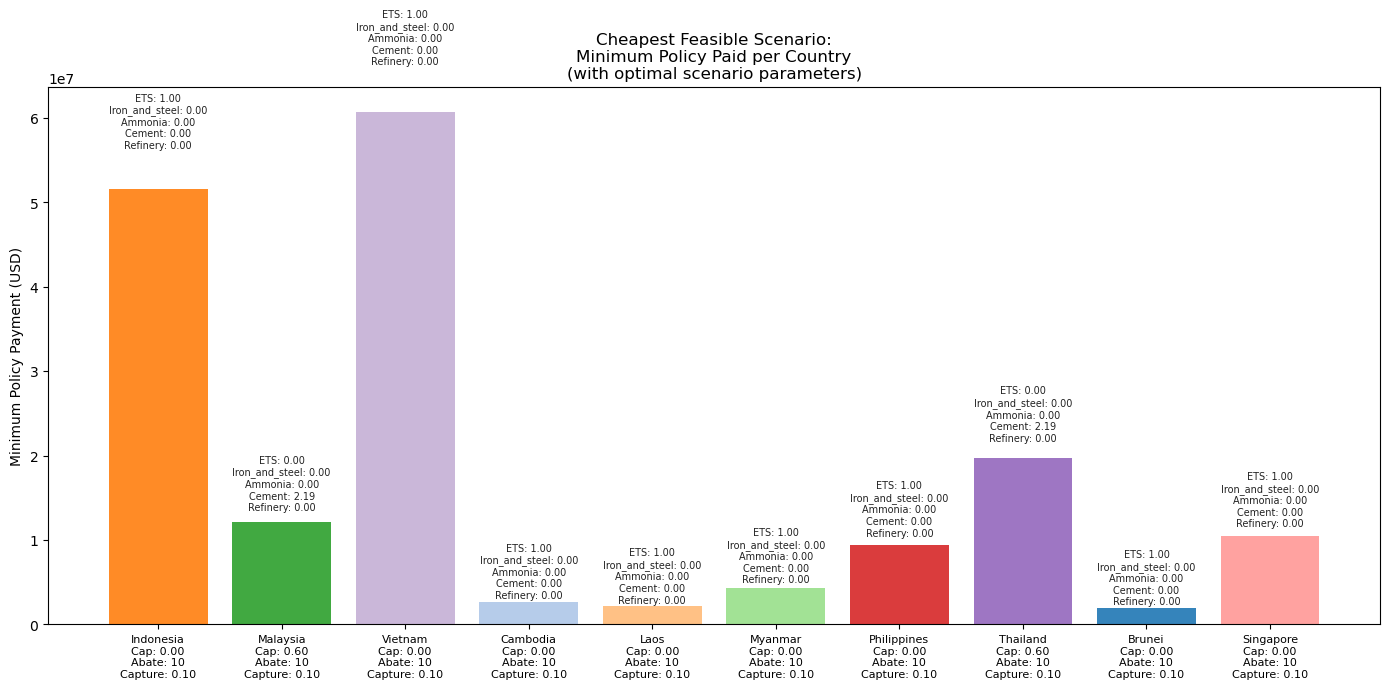

In [397]:
import matplotlib.pyplot as plt

country_labels = []
min_paid = []
ets_prices = []
emission_caps = []
abatement_costs = []
capture_rates = []
tax_caps = []

for country, row in min_country_scenarios.items():
    country_labels.append(country)
    min_paid.append(row[f"TotalPolicyPaid_{country}"])
    ets_prices.append(row["ETS_Price"])
    emission_caps.append(row["EmissionCap"])
    abatement_costs.append(row["AbatementCost"])
    capture_rates.append(row["CaptureRate"])
    tax_caps.append([row.get(f"CarbonTax_{sector}", 0) for sector in sector_names])

# Stack scenario params vertically below country name
xtick_labels = [
    f"{country}\nCap: {cap:.2f}\nAbate: {abate:.0f}\nCapture: {capt:.2f}"
    for country, cap, abate, capt in zip(country_labels, emission_caps, abatement_costs, capture_rates)
]

bar_colors = [country_colors[c] for c in country_labels]

plt.figure(figsize=(14, 7))
bars = plt.bar(country_labels, min_paid, color=bar_colors, alpha=0.90)
plt.ylabel("Minimum Policy Payment (USD)")
plt.title("Cheapest Feasible Scenario:\nMinimum Policy Paid per Country\n(with optimal scenario parameters)")

plt.xticks(
    ticks=range(len(country_labels)),
    labels=xtick_labels,
    fontsize=8,
    rotation=0,
    ha='center'
)

# (Optional) If you want to remove all on-bar annotations for max clarity, comment out the next loop:
for i, bar in enumerate(bars):
    tax_str = "\n".join([f"{sector}: {tax:.2f}" for sector, tax in zip(sector_names, tax_caps[i])])
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() * 1.09,
        f"ETS: {ets_prices[i]:.2f}\n{tax_str}",
        ha="center", va="bottom",
        fontsize=7, color="#222", fontweight='normal'
    )

plt.tight_layout()
plt.show()


Stacked Bar Chart

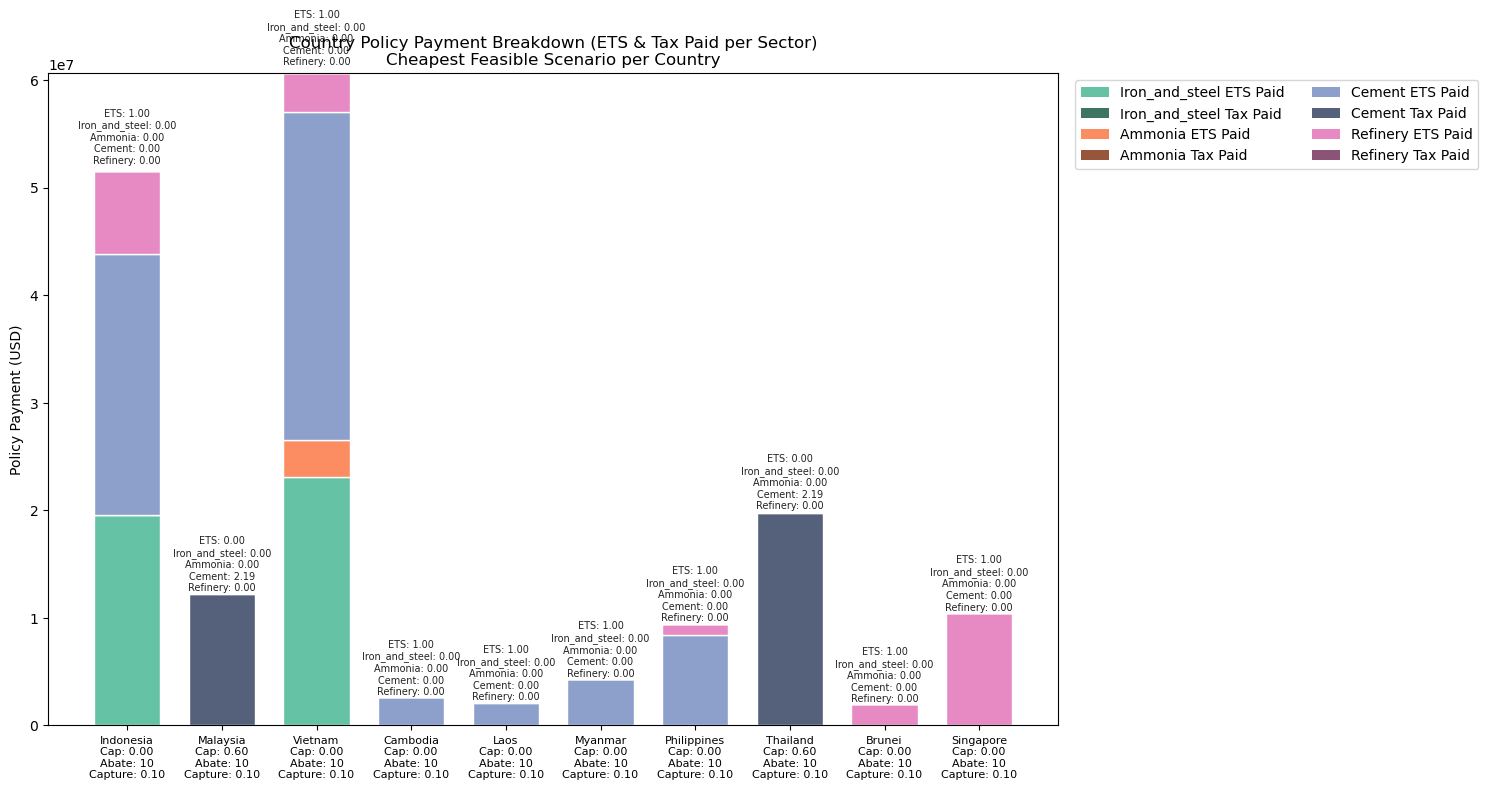

In [398]:
import numpy as np
import matplotlib.pyplot as plt

# --- Data sources ---
# sector_names = ['Iron_and_steel', 'Ammonia', 'Cement', 'Refinery']
# country_names = [ ... ]   # as in your analysis
# min_country_scenarios = { country: row (pd.Series) }

# 1. Ensure all stacks are in order of country_labels!
country_labels = []
emission_caps = []
abatement_costs = []
capture_rates = []

for country in country_names:
    if country in min_country_scenarios:
        country_labels.append(country)
        row = min_country_scenarios[country]
        emission_caps.append(row["EmissionCap"])
        abatement_costs.append(row["AbatementCost"])
        capture_rates.append(row["CaptureRate"])

# 2. Build per-sector stacks (ETS paid and Tax paid) for each country from its minimum scenario
ets_stacks = {sector: [] for sector in sector_names}
tax_stacks = {sector: [] for sector in sector_names}

for country in country_labels:
    row = min_country_scenarios[country]
    for sector in sector_names:
        # Calculate each sector's policy payment
        emissions = country_sector_emissions.get((country, sector), 0)
        ets_price = row.get('ETS_Price', 0)
        tax = row.get(f'CarbonTax_{sector}', 0)
        ets_stacks[sector].append(ets_price * emissions)
        tax_stacks[sector].append(tax * emissions)

# 3. Set up the coloring as you did before
sector_colors = plt.get_cmap('Set2').colors
sector_color_map = {sector: sector_colors[i % len(sector_colors)] for i, sector in enumerate(sector_names)}
def darken(color, factor=0.6):
    return tuple(np.array(color) * factor)

# 4. Build vertical stacked xtick labels for annotation
xtick_labels = [
    f"{country}\nCap: {cap:.2f}\nAbate: {abate:.0f}\nCapture: {capt:.2f}"
    for country, cap, abate, capt in zip(country_labels, emission_caps, abatement_costs, capture_rates)
]

ind = np.arange(len(country_labels))
bar_width = 0.7

plt.figure(figsize=(15, 8))
bottom = np.zeros(len(country_labels))

# --- Plot stacks: ETS first, then Tax ---
for sector in sector_names:
    plt.bar(
        ind, ets_stacks[sector], bar_width,
        bottom=bottom,
        color=sector_color_map[sector],
        edgecolor='white',
        label=f"{sector} ETS Paid"
    )
    bottom += np.array(ets_stacks[sector])

for sector in sector_names:
    plt.bar(
        ind, tax_stacks[sector], bar_width,
        bottom=bottom,
        color=darken(sector_color_map[sector], 0.6),
        edgecolor='white',
        label=f"{sector} Tax Paid"
    )
    bottom += np.array(tax_stacks[sector])

plt.xticks(ind, xtick_labels, rotation=0, fontsize=8, ha="center")
plt.ylabel("Policy Payment (USD)")
plt.title("Country Policy Payment Breakdown (ETS & Tax Paid per Sector)\nCheapest Feasible Scenario per Country")

# --- Custom legend, once per sector ---
from matplotlib.patches import Patch
handles = []
for sector in sector_names:
    handles.append(Patch(facecolor=sector_color_map[sector], label=f"{sector} ETS Paid"))
    handles.append(Patch(facecolor=darken(sector_color_map[sector], 0.6), label=f"{sector} Tax Paid"))
plt.legend(handles=handles, bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=10, ncol=2)

# --- Annotate optimal ETS price and carbon taxes on top of each stack ---
for i, country in enumerate(country_labels):
    row = min_country_scenarios[country]
    top = sum([ets_stacks[s][i] + tax_stacks[s][i] for s in sector_names])
    # Format tax rates and ETS price annotation
    annotation = f"ETS: {row.get('ETS_Price', 0):.2f}\n"
    for sector in sector_names:
        annotation += f"{sector}: {row.get(f'CarbonTax_{sector}', 0):.2f}\n"
    plt.text(
        i,                       # x position (bar center)
        top * 1.01,              # slightly above the stack
        annotation.strip(),      # remove last newline
        ha='center', va='bottom',
        fontsize=7, color='#222', fontweight='normal'
    )

plt.tight_layout()
plt.show()


### Verifying the result

In [399]:
# Check for exact consistency (should always be zero)
for i, country in enumerate(country_labels):
    stacked_sum = sum([ets_stacks[s][i] + tax_stacks[s][i] for s in sector_names])
    total_policy = min_country_scenarios[country][f'TotalPolicyPaid_{country}']
    print(f"{country}: stacked sum = {stacked_sum:.2f}, total policy = {total_policy:.2f}, diff = {stacked_sum - total_policy:.2e}")


# --- ASEAN TOTAL SUM ---
asean_total_stacked = sum(
    sum([ets_stacks[s][i] + tax_stacks[s][i] for s in sector_names])
    for i in range(len(country_labels))
)
asean_total_policy = sum(
    min_country_scenarios[country][f'TotalPolicyPaid_{country}']
    for country in country_labels
)
print(f"\nASEAN Total: stacked sum = {asean_total_stacked:.2f}, total policy = {asean_total_policy:.2f}, diff = {asean_total_stacked - asean_total_policy:.2e}")


Indonesia: stacked sum = 51538578.34, total policy = 51538578.34, diff = 0.00e+00
Malaysia: stacked sum = 12186588.78, total policy = 12186588.78, diff = 0.00e+00
Vietnam: stacked sum = 60610944.12, total policy = 60610944.12, diff = 0.00e+00
Cambodia: stacked sum = 2643243.39, total policy = 2643243.39, diff = 0.00e+00
Laos: stacked sum = 2159743.04, total policy = 2159743.04, diff = 0.00e+00
Myanmar: stacked sum = 4336737.30, total policy = 4336737.30, diff = 0.00e+00
Philippines: stacked sum = 9427123.64, total policy = 9427123.64, diff = 0.00e+00
Thailand: stacked sum = 19729882.29, total policy = 19729882.29, diff = 0.00e+00
Brunei: stacked sum = 1965527.63, total policy = 1965527.63, diff = 0.00e+00
Singapore: stacked sum = 10421197.07, total policy = 10421197.07, diff = 0.00e+00

ASEAN Total: stacked sum = 175019565.59, total policy = 175019565.59, diff = 0.00e+00


### Bar Chart: Policy Payment per Sector (Best Overall Feasible Scenario)

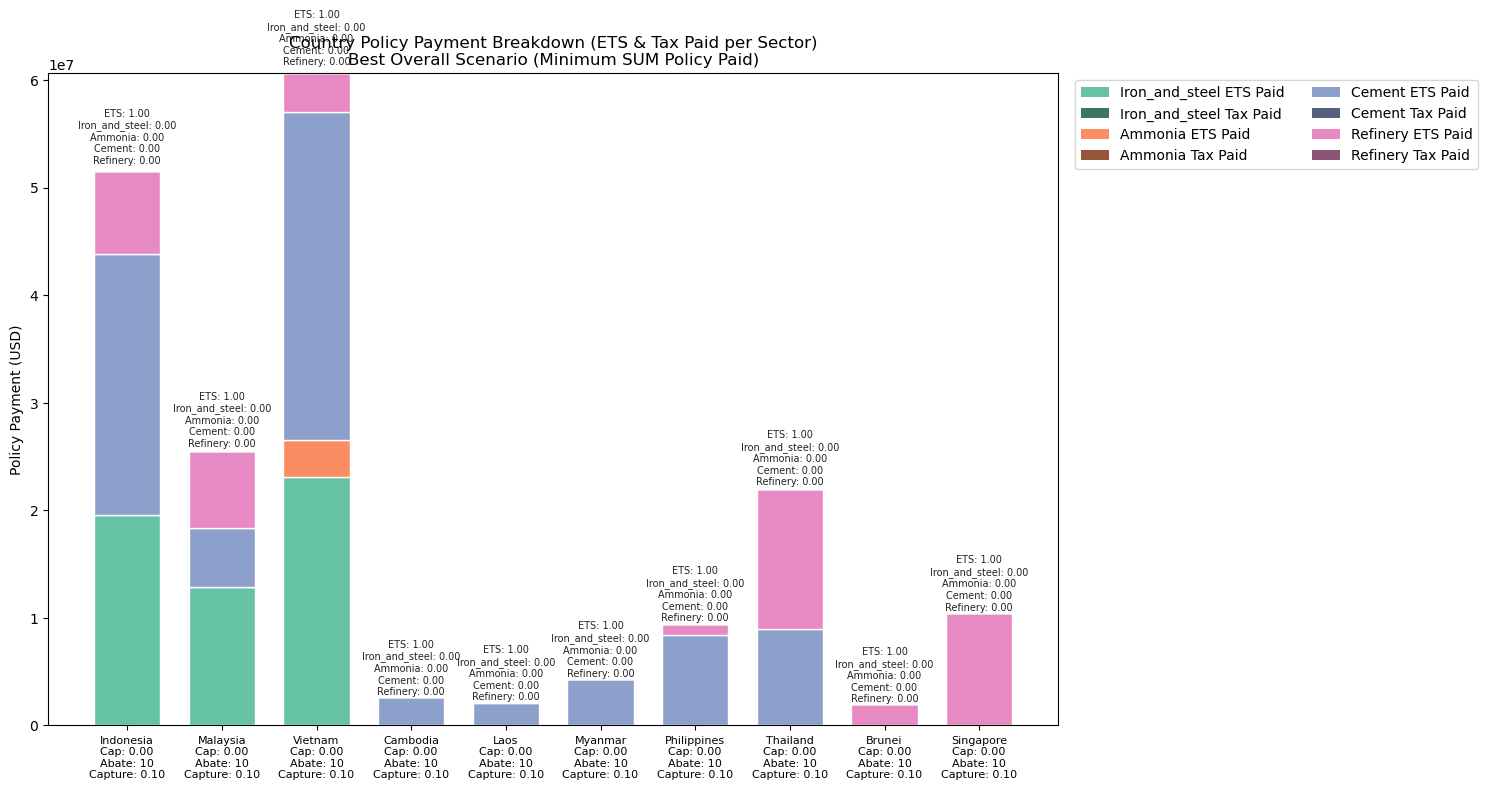

In [400]:
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Build sector stacks for each country, using best_country_scenario for all ---

ets_stacks_best = {sector: [] for sector in sector_names}
tax_stacks_best = {sector: [] for sector in sector_names}

for country in country_names:
    row = best_country_scenario
    for sector in sector_names:
        emissions = country_sector_emissions.get((country, sector), 0)
        ets_price = row.get('ETS_Price', 0)
        tax = row.get(f'CarbonTax_{sector}', 0)
        ets_stacks_best[sector].append(ets_price * emissions)
        tax_stacks_best[sector].append(tax * emissions)

# --- 2. Prepare xtick labels and scenario annotation (same for all countries) ---
emission_cap = best_country_scenario['EmissionCap']
abatement_cost = best_country_scenario['AbatementCost']
capture_rate = best_country_scenario['CaptureRate']

xtick_labels_best = [
    f"{country}\nCap: {emission_cap:.2f}\nAbate: {abatement_cost:.0f}\nCapture: {capture_rate:.2f}"
    for country in country_names
]

ind = np.arange(len(country_names))
bar_width = 0.7

plt.figure(figsize=(15, 8))
bottom = np.zeros(len(country_names))

# --- 3. Plot ETS paid and Tax paid stacks for each sector ---
for sector in sector_names:
    plt.bar(
        ind, ets_stacks_best[sector], bar_width,
        bottom=bottom,
        color=sector_color_map[sector],
        edgecolor='white',
        label=f"{sector} ETS Paid"
    )
    bottom += np.array(ets_stacks_best[sector])

for sector in sector_names:
    plt.bar(
        ind, tax_stacks_best[sector], bar_width,
        bottom=bottom,
        color=darken(sector_color_map[sector], 0.6),
        edgecolor='white',
        label=f"{sector} Tax Paid"
    )
    bottom += np.array(tax_stacks_best[sector])

plt.xticks(ind, xtick_labels_best, rotation=0, fontsize=8, ha="center")
plt.ylabel("Policy Payment (USD)")
plt.title("Country Policy Payment Breakdown (ETS & Tax Paid per Sector)\nBest Overall Scenario (Minimum SUM Policy Paid)")

# --- 4. Annotate ETS price and taxes for each sector (same for all bars) ---
annotation = f"ETS: {best_country_scenario.get('ETS_Price', 0):.2f}\n"
for sector in sector_names:
    annotation += f"{sector}: {best_country_scenario.get(f'CarbonTax_{sector}', 0):.2f}\n"

for i, country in enumerate(country_names):
    top = sum([ets_stacks_best[s][i] + tax_stacks_best[s][i] for s in sector_names])
    plt.text(
        i,
        top * 1.01,
        annotation.strip(),
        ha='center', va='bottom',
        fontsize=7, color='#222'
    )

# --- 5. Legend ---
from matplotlib.patches import Patch
handles = []
for sector in sector_names:
    handles.append(Patch(facecolor=sector_color_map[sector], label=f"{sector} ETS Paid"))
    handles.append(Patch(facecolor=darken(sector_color_map[sector], 0.6), label=f"{sector} Tax Paid"))
plt.legend(handles=handles, bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=10, ncol=2)

plt.tight_layout()
plt.show()


## ASEAN Trade Data: Country-Level Trade Balance Visualisation

### Exports vs Imports by Country for Each Sector

=== Original table preview (first 12 rows) ===
            Sector   Trade      Country  Year  Total Exports (USD)  \
0   Iron and steel  Export       Brunei  2023         1.094645e+10   
1   Iron and steel  Export        Burma  2023         2.207092e+10   
2   Iron and steel  Export     Cambodia  2023         3.425972e+10   
3   Iron and steel  Export    Indonesia  2023         2.986728e+11   
4   Iron and steel  Export         Laos  2023         8.703940e+09   
5   Iron and steel  Export     Malaysia  2023         3.834563e+11   
6   Iron and steel  Export  Philippines  2023         1.008386e+11   
7   Iron and steel  Export    Singapore  2023         3.326225e+11   
8   Iron and steel  Export     Thailand  2023         3.318143e+11   
9   Iron and steel  Export      Vietnam  2023         4.239240e+11   
10  Iron and steel  Import       Brunei  2023         8.426461e+09   
11  Iron and steel  Import        Burma  2023         2.411177e+10   

    Product Exports (USD)  Product share i

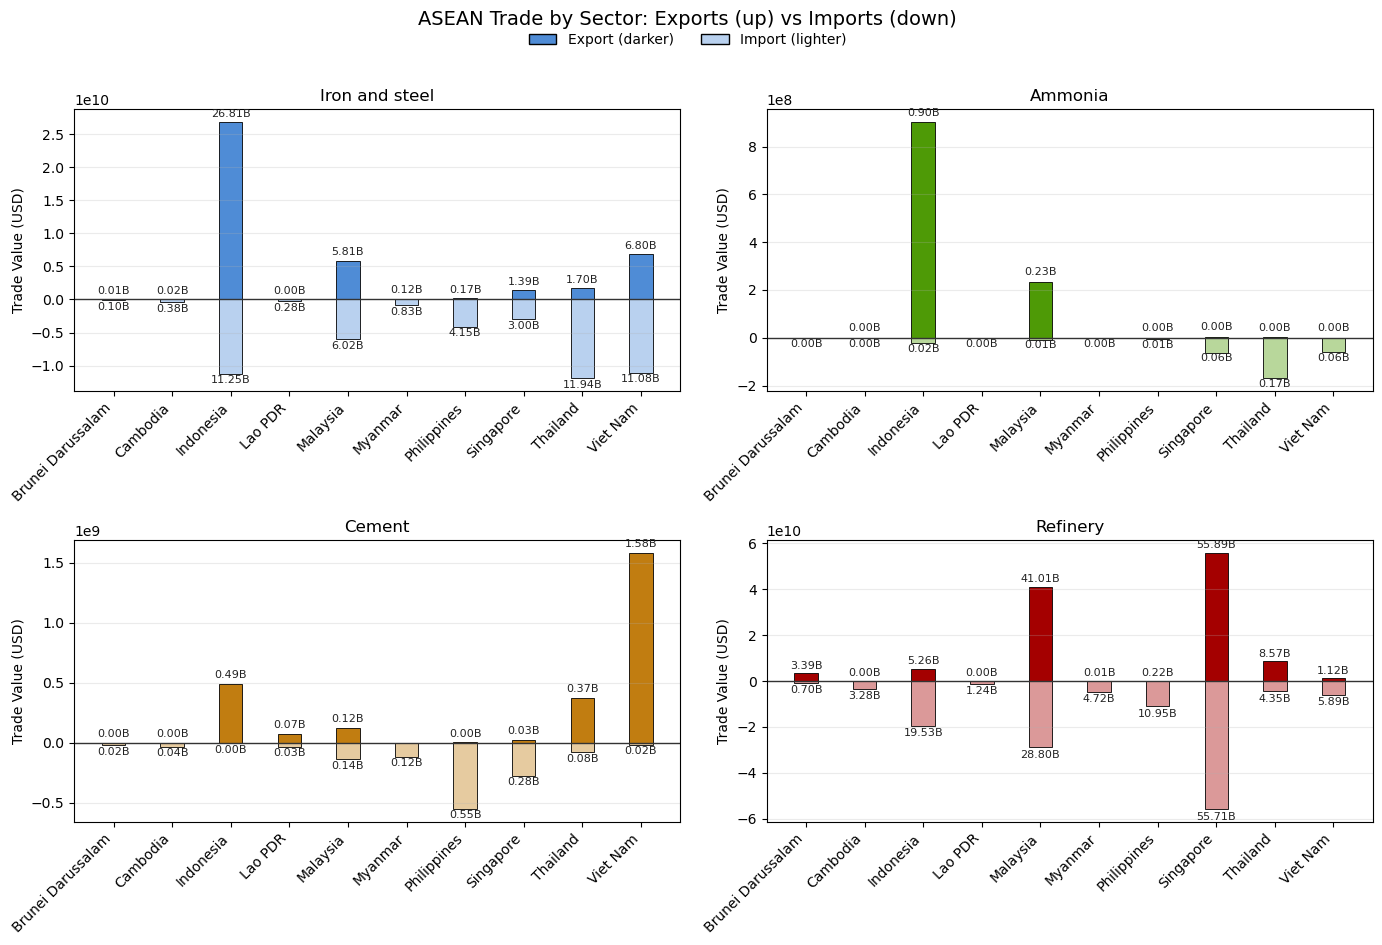

In [401]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# =========================
# 1) Load data
# =========================
excel_path = "OEC_ASEAN_Trade Data.xlsx"
df_raw = pd.read_excel(excel_path, sheet_name=0).copy()

# --- (Task 2) Preview the ORIGINAL table before any cleaning ---
print("=== Original table preview (first 12 rows) ===")
print(df_raw.head(12))
print("\nColumns:", list(df_raw.columns))
print(f"Shape: {df_raw.shape}\n")

# =========================
# 2) Normalize column names & basic cleaning
# =========================
df = df_raw.copy()
df.columns = (
    df.columns
      .str.strip()
      .str.lower()
      .str.replace(r"[\s\-/()]+", "_", regex=True)
      .str.replace(r"[^a-z0-9_]+", "", regex=True)
)

required = ["country", "sector", "trade"]
missing = [c for c in required if c not in df.columns]
if missing:
    raise KeyError(f"Missing required columns {missing}. Found: {list(df.columns)}")

# Choose a numeric USD value column (typical OEC names)
candidate_value_cols = [
    "product_exports_usd_", "product_imports_usd_",
    "trade_value_usd", "value_usd", "total_exports_usd_"
]
value_col = next((c for c in candidate_value_cols if c in df.columns), None)
if value_col is None:
    raise KeyError(
        "Could not find a numeric USD column. "
        f"Tried {candidate_value_cols}. Found columns: {list(df.columns)}"
    )

# Trim strings; standardize 'trade'
for c in ["country", "sector", "trade"]:
    df[c] = df[c].astype(str).str.strip()
df["trade"] = df["trade"].str.lower().replace({
    "exports": "export", "export": "export",
    "imports": "import", "import": "import"
})

# Coerce numeric
df[value_col] = pd.to_numeric(df[value_col], errors="coerce").fillna(0.0)

# =========================
# 3) Country fixes (Burma -> Myanmar) & ASEAN filter
# =========================
asean_order = [
    "Brunei Darussalam", "Cambodia", "Indonesia", "Lao PDR", "Malaysia",
    "Myanmar", "Philippines", "Singapore", "Thailand", "Viet Nam"
]
country_fix = {
    "Laos": "Lao PDR",
    "Lao People's Democratic Republic": "Lao PDR",
    "Vietnam": "Viet Nam",
    "Brunei": "Brunei Darussalam",
    # key fix:
    "Burma": "Myanmar",
    "Myanmar (Burma)": "Myanmar",
    "Union of Burma": "Myanmar",
}
df["country"] = df["country"].replace(country_fix)

# Filter to ASEAN-10 and set display order
df = df[df["country"].isin(asean_order)].copy()
df["country"] = pd.Categorical(df["country"], categories=asean_order, ordered=True)

# =========================
# 4) Map to the 4 focused sectors
# =========================
focused_sectors = ["Iron_and_steel", "Ammonia", "Cement", "Refinery"]

df["_sector_norm"] = (
    df["sector"].str.lower()
    .str.replace(r"[\s\-/()]+", "_", regex=True)
    .str.replace(r"[^a-z0-9_]+", "", regex=True)
)
sector_aliases = {
    "iron_and_steel": "Iron_and_steel",
    "ironsteel": "Iron_and_steel",
    "steel": "Iron_and_steel",
    "ammonia": "Ammonia",
    "cement": "Cement",
    "refinery": "Refinery",
    "oil_refining": "Refinery",
    "refining": "Refinery",
}
df["_sector"] = df["_sector_norm"].map(sector_aliases).fillna(df["sector"])
df = df[df["_sector"].isin(focused_sectors)].copy()

# --- Quick cleaned preview (optional, helpful) ---
print("=== Cleaned/filtered preview (first 12 rows) ===")
print(df[["country", "sector", "_sector", "trade", value_col]].head(12), "\n")

# =========================
# 5) Ensure both export/import rows exist
# =========================
has_import_rows = (df["trade"] == "import").any()
has_export_rows = (df["trade"] == "export").any()

if not has_import_rows:
    base = df[df["trade"] == "export"][["country", "_sector"]].drop_duplicates()
    imp_zeros = base.copy()
    imp_zeros["trade"] = "import"
    imp_zeros[value_col] = 0.0
    df = pd.concat([df, imp_zeros], ignore_index=True)
    print("Note: No explicit import rows found. Imports will plot as zero.")

if not has_export_rows:
    base = df[df["trade"] == "import"][["country", "_sector"]].drop_duplicates()
    exp_zeros = base.copy()
    exp_zeros["trade"] = "export"
    exp_zeros[value_col] = 0.0
    df = pd.concat([df, exp_zeros], ignore_index=True)
    print("Note: No explicit export rows found. Exports will plot as zero.")

# =========================
# 6) Aggregate & pivot (Task 1: pass observed=False to silence FutureWarning)
# =========================
agg = (
    df.groupby(["country", "_sector", "trade"], as_index=False, observed=False)[value_col]  # observed=False fixes the warning
      .sum()
)

exp_piv = (agg[agg["trade"] == "export"]
           .pivot(index="country", columns="_sector", values=value_col)
           .reindex(asean_order)
           .reindex(columns=focused_sectors, fill_value=0.0)
           .fillna(0.0))

imp_piv = (agg[agg["trade"] == "import"]
           .pivot(index="country", columns="_sector", values=value_col)
           .reindex(asean_order)
           .reindex(columns=focused_sectors, fill_value=0.0)
           .fillna(0.0))

# =========================
# 7) Colors & helpers
# =========================
def lighten(rgb, factor=0.6):
    return tuple(1 - (1 - c) * (1 - factor) for c in rgb)

base_colors = {
    "Iron_and_steel": (79/255, 140/255, 214/255),  # blue
    "Ammonia":       (78/255, 154/255, 6/255),     # green
    "Cement":        (193/255, 125/255, 17/255),   # orange-brown
    "Refinery":      (164/255, 0/255, 0/255),      # red
}
export_colors = {s: base_colors[s] for s in focused_sectors}
import_colors = {s: lighten(base_colors[s], 0.60) for s in focused_sectors}

# =========================
# 8) Plot 2×2 (one subplot per sector)
# =========================
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=False)
axes = axes.flatten()

for idx, sector in enumerate(focused_sectors):
    ax = axes[idx]
    countries = asean_order
    x_pos = np.arange(len(countries))
    
    # Data for this sector
    exp_vals = exp_piv[sector].values
    imp_vals = -imp_piv[sector].values  # negative for downward

    # Plot exports (up)
    ax.bar(
        x_pos, exp_vals, width=0.4,
        color=export_colors[sector], edgecolor="black", linewidth=0.6,
        label="Export"
    )
    # Plot imports (down)
    ax.bar(
        x_pos, imp_vals, width=0.4,
        color=import_colors[sector], edgecolor="black", linewidth=0.6,
        label="Import"
    )

    # Annotate bars in $B
    pad_up = max(1e-9, 0.02 * exp_vals.max()) if exp_vals.max() > 0 else 0
    pad_dn = max(1e-9, 0.02 * abs(imp_vals.min())) if imp_vals.min() < 0 else 0
    for xi, ev in zip(x_pos, exp_vals):
        if ev > 0:
            ax.text(xi, ev + pad_up, f"{ev/1e9:.2f}B", ha="center", va="bottom", fontsize=8, color="#222")
    for xi, iv in zip(x_pos, imp_vals):
        if iv < 0:
            ax.text(xi, iv - pad_dn, f"{(-iv)/1e9:.2f}B", ha="center", va="top", fontsize=8, color="#222")

    # Formatting
    ax.axhline(0, color="#333", linewidth=1)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(countries, rotation=45, ha="right")
    ax.set_ylabel("Trade Value (USD)")
    ax.set_title(sector.replace("_", " "))

    ax.grid(axis="y", alpha=0.25)

# Legend once for all subplots
handles = [
    Patch(facecolor=export_colors[focused_sectors[0]], edgecolor="black", label="Export (darker)"),
    Patch(facecolor=import_colors[focused_sectors[0]], edgecolor="black", label="Import (lighter)")
]
fig.legend(handles=handles, loc="upper center", ncol=2, frameon=False, fontsize=10, bbox_to_anchor=(0.5, 0.93))

fig.suptitle("ASEAN Trade by Sector: Exports (up) vs Imports (down)", fontsize=14, y=0.94)
fig.tight_layout(rect=[0, 0, 1, 0.91])
plt.show()


### Exports vs Imports by Sector for Each Country

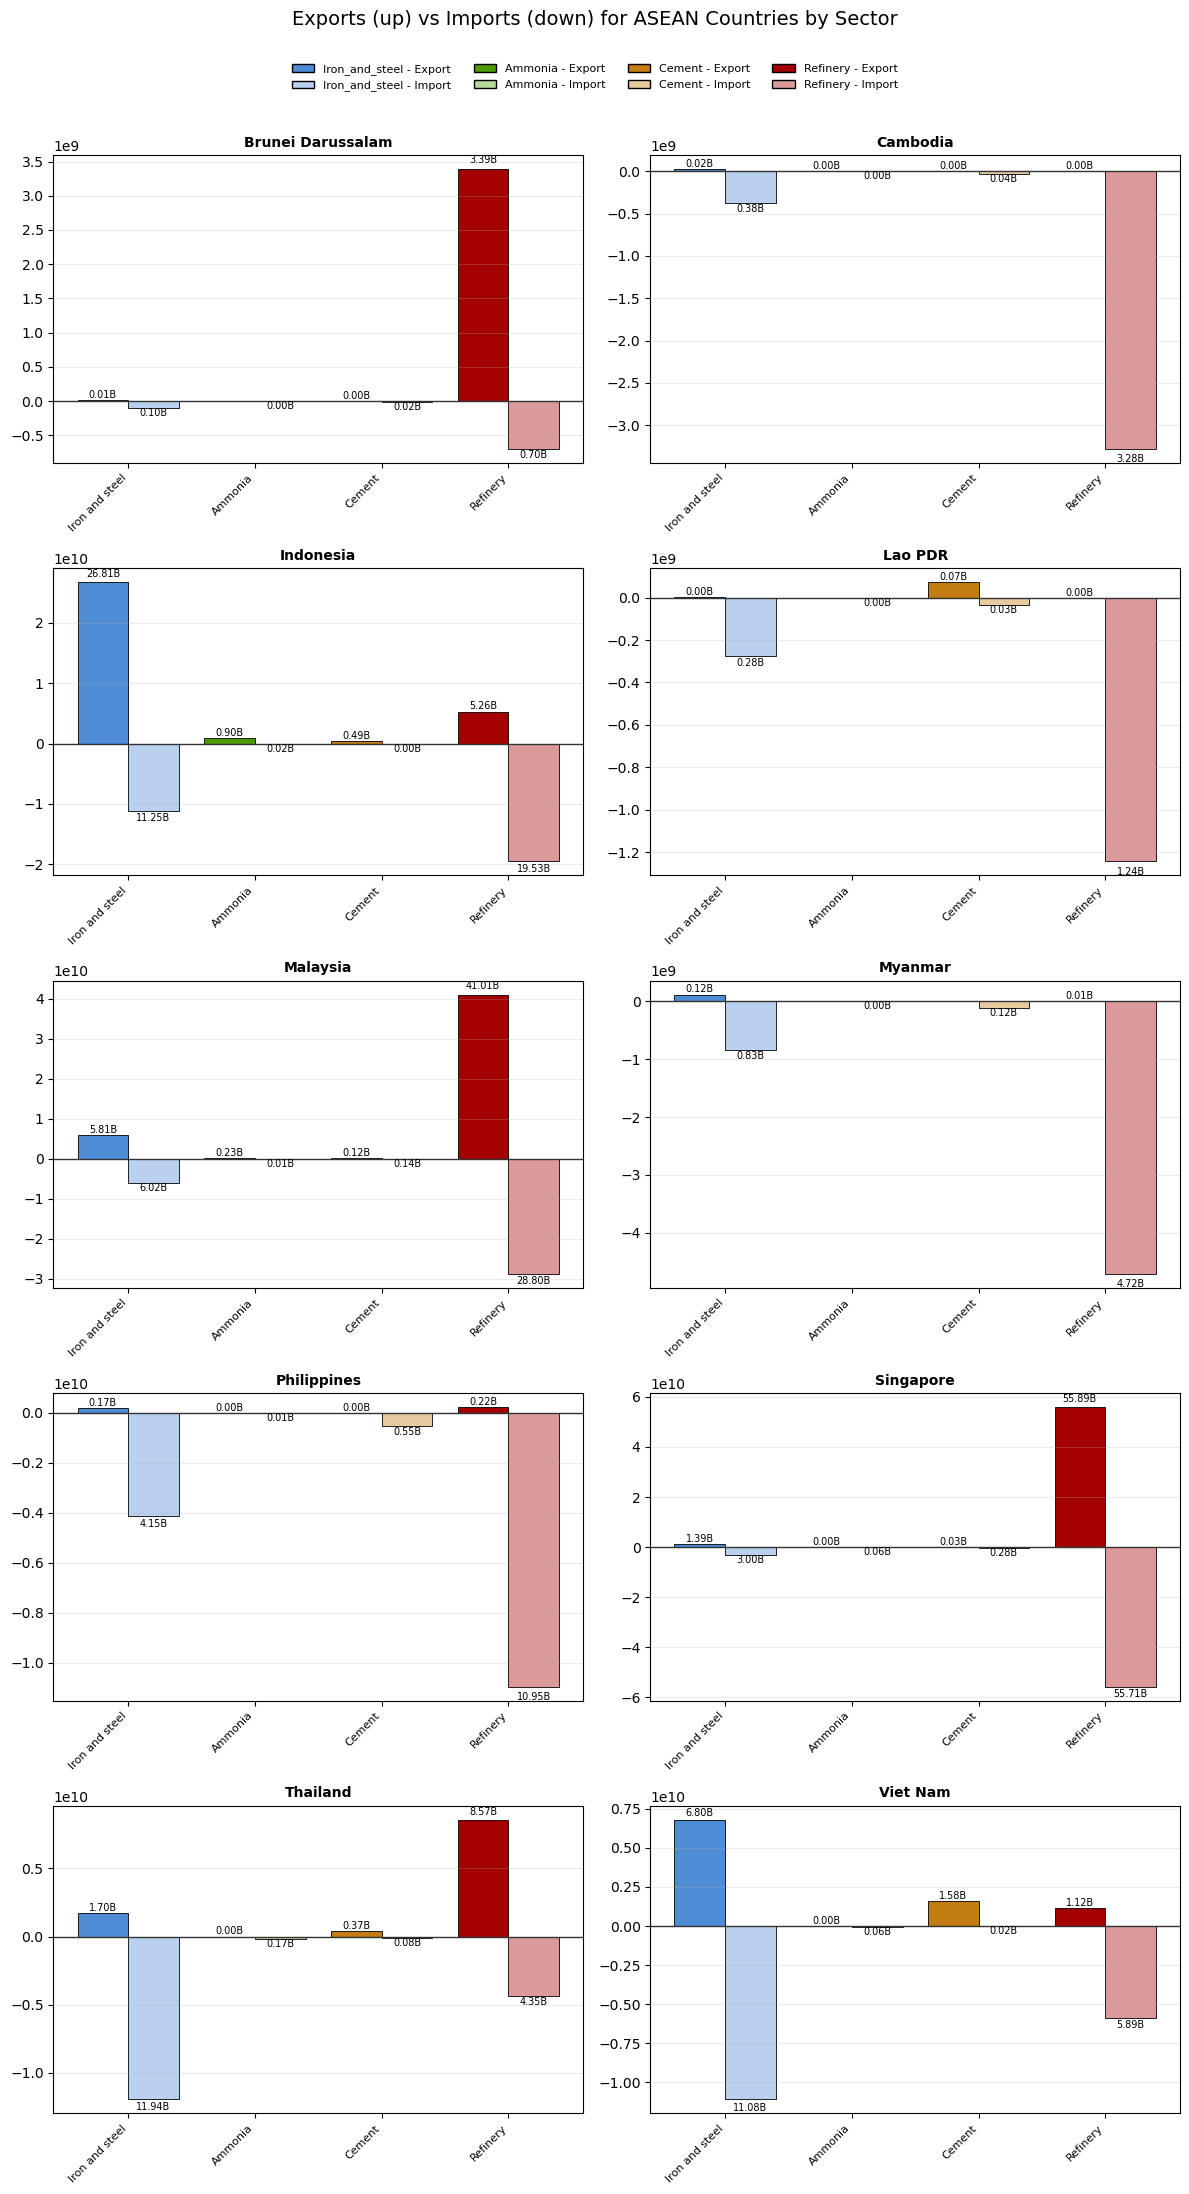

In [402]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np

# --- Create subplot grid for countries (5 x 2 layout) ---
fig, axes = plt.subplots(5, 2, figsize=(12, 22), sharey=False)  # taller figure
axes = axes.flatten()

for idx, country in enumerate(asean_order):
    ax = axes[idx]
    
    # Positions for sectors
    x_pos = np.arange(len(focused_sectors))
    
    exp_vals = []
    imp_vals = []
    for sector in focused_sectors:
        exp_vals.append(exp_piv.loc[country, sector])
        imp_vals.append(-imp_piv.loc[country, sector])  # negative for imports down
    
    exp_vals = np.array(exp_vals)
    imp_vals = np.array(imp_vals)
    
    # Plot exports
    ax.bar(
        x_pos - 0.2, exp_vals, width=0.4,
        color=[export_colors[s] for s in focused_sectors],
        edgecolor="black", linewidth=0.6, label="Export"
    )
    
    # Plot imports
    ax.bar(
        x_pos + 0.2, imp_vals, width=0.4,
        color=[import_colors[s] for s in focused_sectors],
        edgecolor="black", linewidth=0.6, label="Import"
    )
    
    # Annotate bars
    for xi, ev in zip(x_pos, exp_vals):
        if ev > 0:
            ax.text(xi - 0.2, ev + ev * 0.02, f"{ev/1e9:.2f}B", ha="center", va="bottom", fontsize=7)
    for xi, iv in zip(x_pos, imp_vals):
        if iv < 0:
            ax.text(xi + 0.2, iv - abs(iv) * 0.02, f"{(-iv)/1e9:.2f}B", ha="center", va="top", fontsize=7)
    
    # Formatting
    ax.axhline(0, color="#333", linewidth=1)
    ax.set_xticks(x_pos)
    ax.set_xticklabels([s.replace("_", " ") for s in focused_sectors], rotation=45, ha="right", fontsize=8)
    ax.set_title(country, fontsize=10, fontweight="bold")
    ax.grid(axis="y", alpha=0.25)

# Shared legend for all
legend_handles = []
for sector in focused_sectors:
    legend_handles.append(Patch(facecolor=export_colors[sector], edgecolor="black", label=f"{sector} - Export"))
    legend_handles.append(Patch(facecolor=import_colors[sector], edgecolor="black", label=f"{sector} - Import"))

fig.legend(
    handles=legend_handles,
    loc="upper center",
    ncol=4,
    frameon=False,
    fontsize=8,
    bbox_to_anchor=(0.5, 0.975)
)

# Main title
fig.suptitle("Exports (up) vs Imports (down) for ASEAN Countries by Sector", fontsize=14, y=0.995)

# Adjust layout
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Rows without coordinates after merge: 0 / 168
Saved GeoJSON  → C:\Users\Keerati\Documents\Imperial College London\Environmental Technology\Thesis\Gbemi's Material\Cleaned\For Python\GLPK vs Gurobi\Gurobi\Scenarios\plants_with_coords.geojson
Saved GeoPackage → C:\Users\Keerati\Documents\Imperial College London\Environmental Technology\Thesis\Gbemi's Material\Cleaned\For Python\GLPK vs Gurobi\Gurobi\Scenarios\plants_with_coords.gpkg (layer='plants')


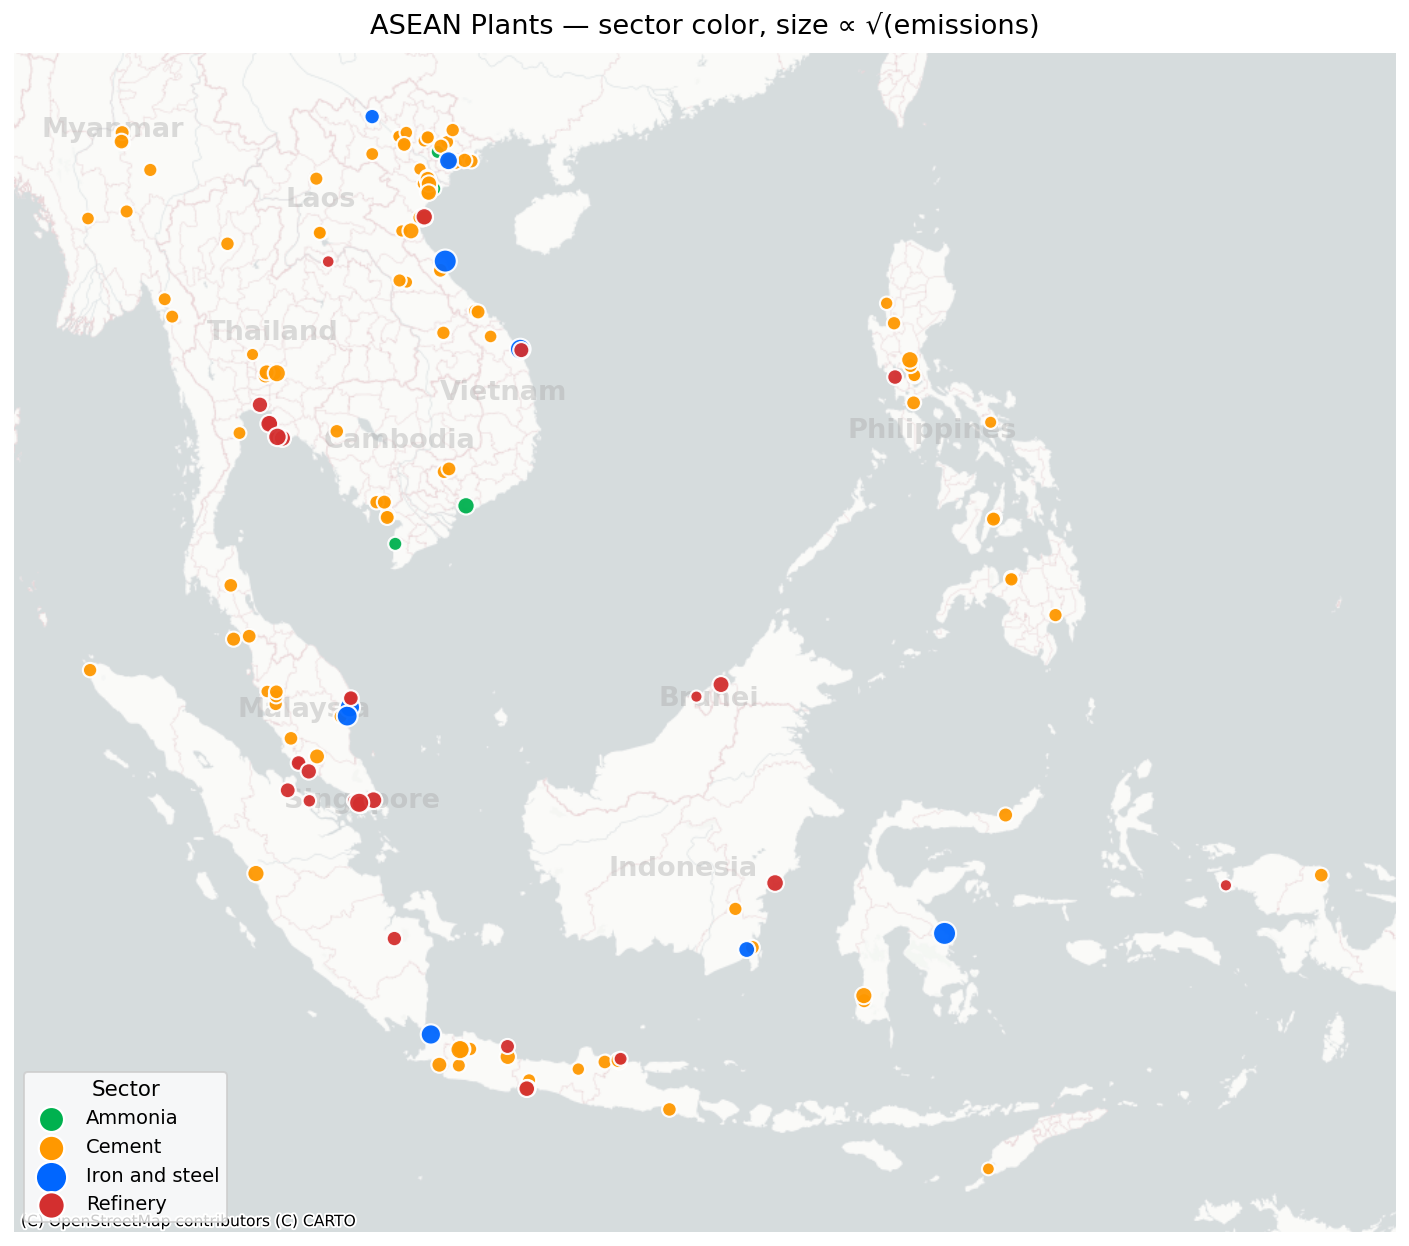

In [403]:
# === Append Latitude/Longitude to preview_df, build GeoPandas layers, and draw a high-visibility map with ASEAN country labels ===
# Requires: pip install geopandas shapely pyproj contextily

import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path
import re
import matplotlib.patheffects as pe

# -----------------------------------------------------------
# 0) Utilities
# -----------------------------------------------------------
def clean_name(name: str) -> str:
    name = str(name)
    name = name.encode('ascii', 'ignore').decode('ascii')
    name = re.sub(r'[&\'\"]', '', name)                 # remove &, ', "
    name = re.sub(r'\s+', '_', name)                    # spaces -> underscore
    name = re.sub(r'[^A-Za-z0-9_]', '', name)           # keep [A-Za-z0-9_]
    return name

def first_existing(candidates, columns):
    for c in candidates:
        if c in columns:
            return c
    return None

# -----------------------------------------------------------
# 1) Read ClimateTrace workbook and harvest coordinates
# -----------------------------------------------------------
climatetrace_path = "ClimateTrace_Original Data.xlsx"
sheets = pd.read_excel(climatetrace_path, sheet_name=None)

coords_frames = []
for sheet_name, df_ct in sheets.items():
    cols = df_ct.columns
    plant_col   = first_existing(["Plant", "Facility", "Asset", "Site", "PLANT", "facility", "plant"], cols)
    sector_col  = first_existing(["Sector", "SECTOR", "sector", "Industry"], cols)
    country_col = first_existing(["Country", "COUNTRY", "country", "Nation"], cols)
    lat_col     = first_existing(["Latitude", "LAT", "lat", "Plant_Latitude", "Facility Latitude", "Lat"], cols)
    lon_col     = first_existing(["Longitude", "LON", "lon", "Plant_Longitude", "Facility Longitude", "Lng", "Long"], cols)

    if lat_col and lon_col and (plant_col or (sector_col and country_col)):
        work = df_ct[[c for c in [plant_col, sector_col, country_col, lat_col, lon_col] if c]].copy()
        if plant_col:
            work["Plant_key"] = work[plant_col].astype(str).apply(clean_name)
        else:
            work["Plant_key"] = (
                work.get(sector_col, "").astype(str).str.strip().str.replace(" ", "_", regex=False).fillna("NA")
                + "_" + work.get(country_col, "").astype(str).fillna("NA")
                + "_" + work.index.astype(str)
            ).apply(clean_name)

        work["Sector_norm"]  = work.get(sector_col, "").astype(str).str.strip().str.replace(" ", "_", regex=False)
        work["Country_norm"] = work.get(country_col, "").astype(str).str.strip()
        work["Latitude"]  = pd.to_numeric(work[lat_col], errors="coerce")
        work["Longitude"] = pd.to_numeric(work[lon_col], errors="coerce")
        work = work.dropna(subset=["Latitude", "Longitude"])
        coords_frames.append(work[["Plant_key", "Sector_norm", "Country_norm", "Latitude", "Longitude"]])

if not coords_frames:
    raise KeyError("No latitude/longitude columns found in ClimateTrace file.")

coords_all = pd.concat(coords_frames, ignore_index=True).drop_duplicates(subset=["Plant_key"])

# -----------------------------------------------------------
# 2) Prepare preview_df & merge coordinates
# -----------------------------------------------------------
preview_df = preview_df.copy()
preview_df["Plant_key"]   = preview_df["Plant"].astype(str)
preview_df["Sector_norm"] = preview_df["Sector"].astype(str)

display_names = {
    "Lao People's Democratic Republic": "Laos",
    "Brunei Darussalam": "Brunei",
}
if "Country" in preview_df.columns:
    preview_df["Country_Display"] = preview_df["Country"].astype(str).replace(display_names)
elif "COUNTRY" in preview_df.columns:
    preview_df["Country_Display"] = preview_df["COUNTRY"].astype(str).replace(display_names)

preview_geo = preview_df.merge(coords_all[["Plant_key", "Latitude", "Longitude"]],
                               on="Plant_key", how="left")
print(f"Rows without coordinates after merge: {preview_geo['Latitude'].isna().sum()} / {len(preview_geo)}")

# -----------------------------------------------------------
# 3) Ensure numeric fields + compute emissions & abatement
# -----------------------------------------------------------
for col in ["Carbon_Intensity", "Actual_Production", "CO2_Capture", "Abatement_Cost"]:
    preview_geo[col] = pd.to_numeric(preview_geo.get(col, 0), errors="coerce").fillna(0.0)

if "Plant_Emissions" not in preview_geo.columns:
    preview_geo["Plant_Emissions"] = preview_geo["Carbon_Intensity"] * preview_geo["Actual_Production"]

if "Abate_Cost" not in preview_geo.columns:
    preview_geo["Abate_Cost"] = (
        preview_geo["Abatement_Cost"] * preview_geo["Carbon_Intensity"] *
        preview_geo["Actual_Production"] * preview_geo["CO2_Capture"].clip(upper=1.0)
    )

preview_geo_map = preview_geo.dropna(subset=["Latitude", "Longitude"]).copy()

# -----------------------------------------------------------
# 4) Build GeoDataFrames
# -----------------------------------------------------------
gdf = gpd.GeoDataFrame(
    preview_geo_map,
    geometry=gpd.points_from_xy(preview_geo_map["Longitude"], preview_geo_map["Latitude"]),
    crs="EPSG:4326"
)
gdf_3857 = gdf.to_crs(epsg=3857)

# -----------------------------------------------------------
# 5) Save outputs
# -----------------------------------------------------------
out_geojson = Path("plants_with_coords.geojson")
out_gpkg    = Path("plants_with_coords.gpkg")
keep_cols = [
    "Plant", "Plant_key", "Sector", "Country", "Country_Display",
    "Carbon_Intensity", "Actual_Production", "CO2_Capture", "Abatement_Cost",
    "Plant_Emissions", "Abate_Cost"
]
keep_cols = [c for c in keep_cols if c in gdf.columns]
gdf[keep_cols + ["geometry"]].to_file(out_geojson, driver="GeoJSON")
gdf[keep_cols + ["geometry"]].to_file(out_gpkg, layer="plants", driver="GPKG")
print(f"Saved GeoJSON  → {out_geojson.resolve()}")
print(f"Saved GeoPackage → {out_gpkg.resolve()} (layer='plants')")

# -----------------------------------------------------------
# 6) HIGH-VISIBILITY MAP
# -----------------------------------------------------------
sector_colors = {
    "Iron_and_steel": "#0066FF",
    "Ammonia":        "#00B14F",
    "Cement":         "#FF9800",
    "Refinery":       "#D32F2F",
}
def color_by_sector(s): return sector_colors.get(s, "#444444")

ems = gdf_3857["Plant_Emissions"].fillna(0).clip(lower=0)
ems_sqrt = np.sqrt(ems)
ems_norm = (ems_sqrt - ems_sqrt.min()) / (ems_sqrt.max() - ems_sqrt.min()) if ems_sqrt.max() > ems_sqrt.min() else ems_sqrt*0
size = 24 + 64 * ems_norm

fig, ax = plt.subplots(figsize=(11, 9), dpi=140)
minx, miny, maxx, maxy = gdf_3857.total_bounds
padx = (maxx - minx) * 0.06
pady = (maxy - miny) * 0.06
ax.set_xlim(minx - padx, maxx + padx)
ax.set_ylim(miny - pady, maxy + pady)

try:
    import contextily as cx
    cx.add_basemap(ax, source=cx.providers.CartoDB.PositronNoLabels, crs=gdf_3857.crs, alpha=0.95)
except Exception as e:
    print(f"(Basemap skipped: {e})")

order = size.sort_values().index
gdf_ord = gdf_3857.loc[order]

for sector, sub in gdf_ord.groupby("Sector"):
    sub.plot(
        ax=ax,
        markersize=size.loc[sub.index] * 1.6,
        facecolor=color_by_sector(sector),
        edgecolor="white", linewidth=1.1,
        alpha=0.95, zorder=3,
        label=sector.replace("_", " ")
    )

# -----------------------------------------------------------
# 7) ASEAN country labels — pale & behind datapoints
# -----------------------------------------------------------
asean_centroids_wgs84 = {
    "Brunei":      (114.7277, 4.5353),
    "Cambodia":    (104.9909, 12.5657),
    "Indonesia":   (113.9213, -0.7893),
    "Laos":        (102.4955, 19.8563),
    "Malaysia":    (101.9758, 4.2105),
    "Myanmar":     (95.9560, 21.9162),
    "Philippines": (121.7740, 12.8797),
    "Singapore":   (103.8198, 1.3521),
    "Thailand":    (100.9925, 15.8700),
    "Vietnam":     (108.2772, 14.0583)
}

label_gdf = gpd.GeoDataFrame(
    {"Country": list(asean_centroids_wgs84.keys())},
    geometry=gpd.points_from_xy(
        [lon for lon, lat in asean_centroids_wgs84.values()],
        [lat for lon, lat in asean_centroids_wgs84.values()]
    ),
    crs="EPSG:4326"
).to_crs(epsg=3857)

# Plot labels first (low zorder so datapoints sit above)
for idx, row in label_gdf.iterrows():
    ax.text(
        row.geometry.x, row.geometry.y, row["Country"],
        fontsize=14, fontweight="bold",
        ha='center', va='center',
        color='darkgrey', alpha=0.4,  # pale look
        zorder=1                        # beneath datapoints
    )

# Legend
leg = ax.legend(
    title="Sector", loc="lower left", frameon=True,
    markerscale=1.6, fontsize=10, title_fontsize=11
)
handles = getattr(leg, "legendHandles", getattr(leg, "legend_handles", []))
for h in handles:
    try:
        h.set_alpha(1)
        h.set_linewidth(1.2)
    except Exception:
        pass

ax.set_title("ASEAN Plants — sector color, size ∝ √(emissions)", fontsize=14, pad=10)
ax.set_axis_off()
plt.tight_layout()
plt.show()


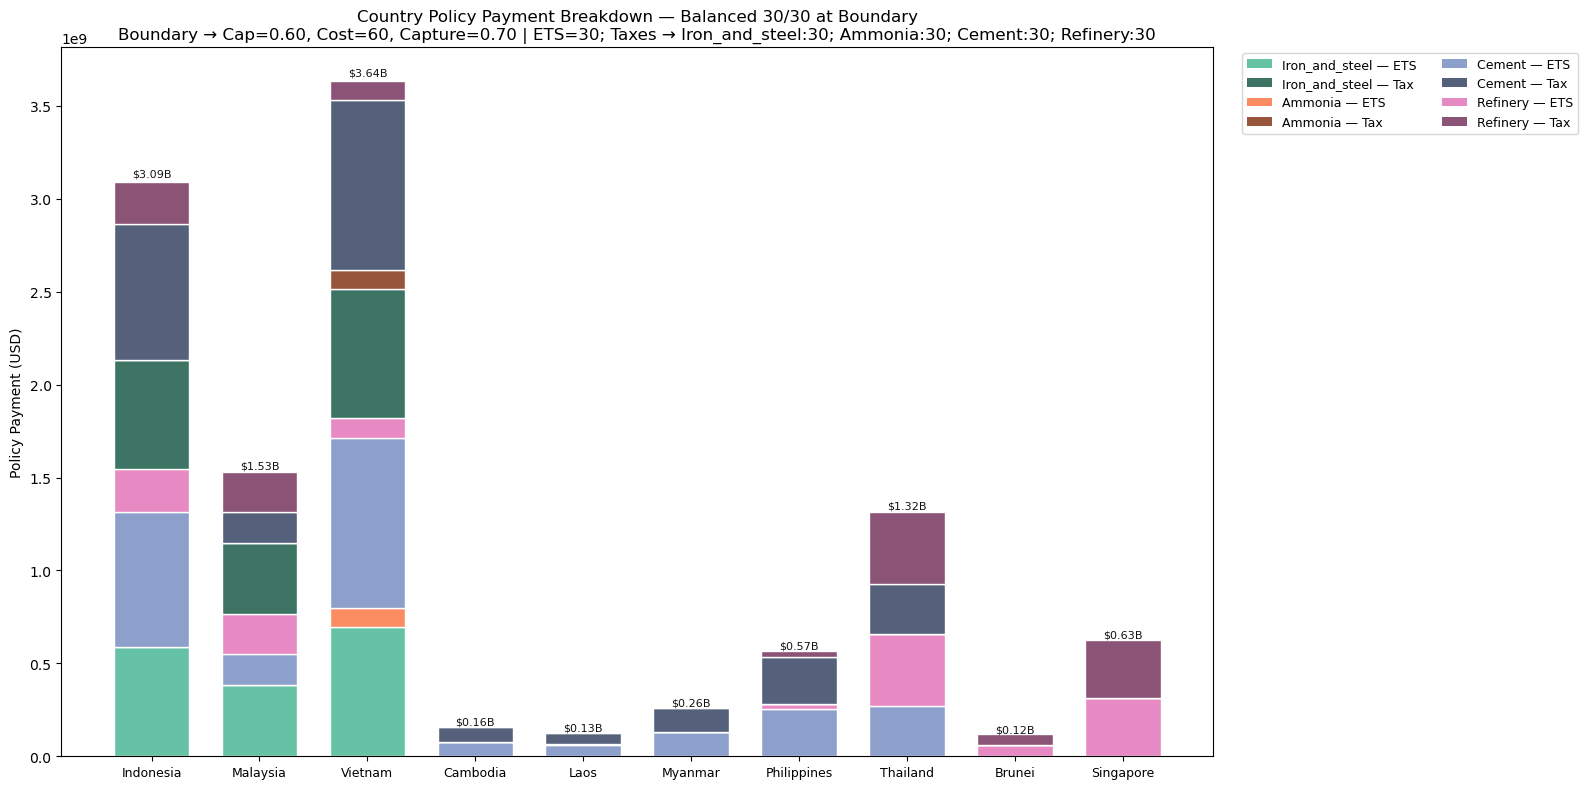

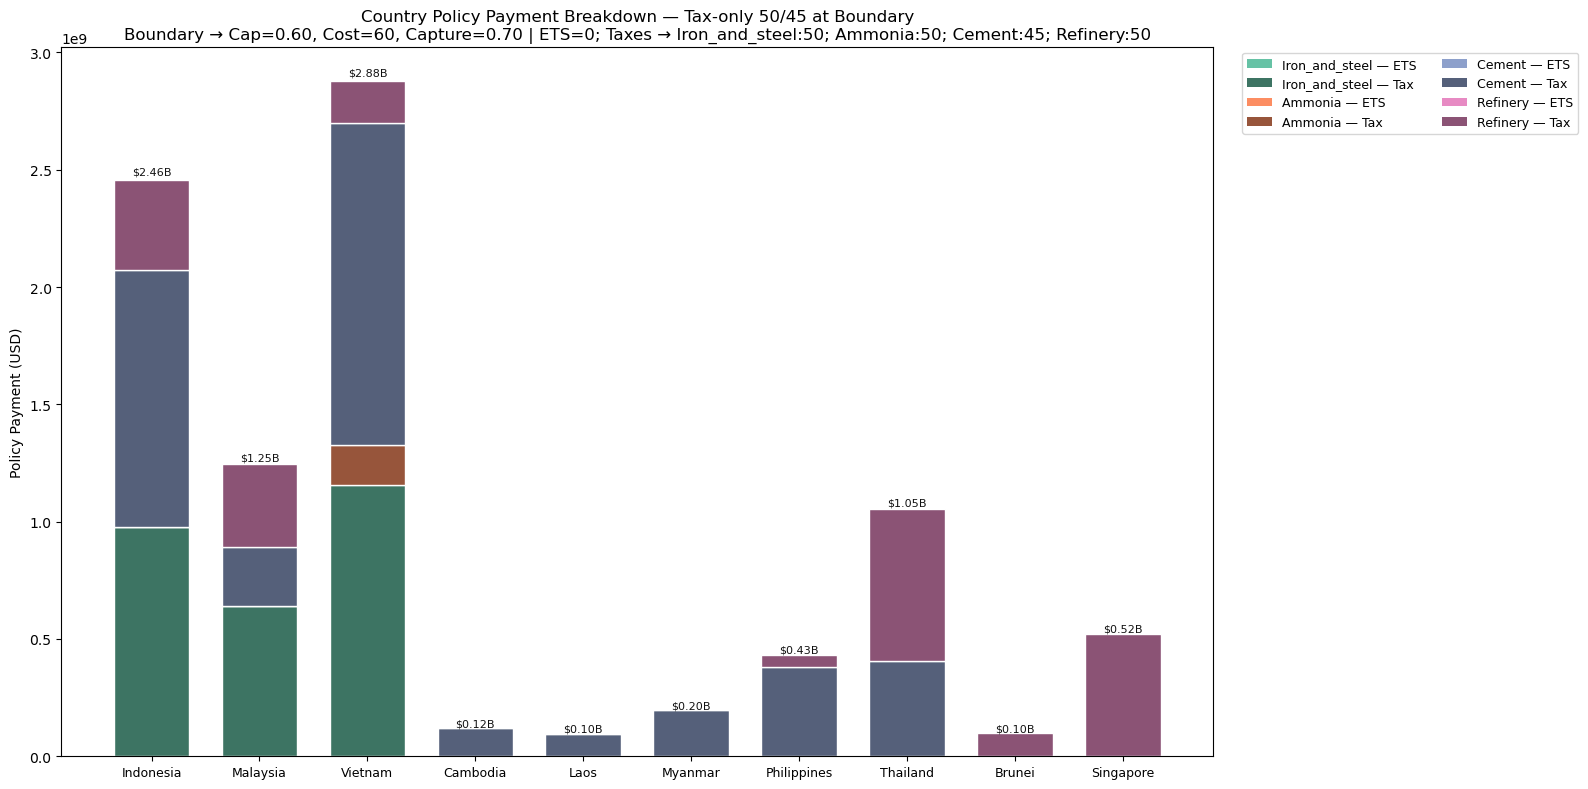

In [404]:
# === COUNTRY-WIDE POLICY PAYMENT STACKS AT A CHOSEN BOUNDARY =================
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Fallback darken() if you don't already have one
def _darken_hex(c, factor=0.6):
    import matplotlib.colors as mcolors
    rgb = np.array(mcolors.to_rgb(c))
    return np.clip(rgb * factor, 0, 1)

if 'darken' not in globals():
    def darken(c, factor=0.6):
        return _darken_hex(c, factor)

def plot_country_policy_payments_at_boundary(
    scenario,
    title_prefix="Country Policy Payment Breakdown (ETS & Tax Paid per Sector)",
    figsize=(16, 8),
    annotate_prices=False,   # set True to print the ETS/tax block above each bar
    annotate_totals=True     # prints the total on top of each bar
):
    """
    scenario: dict with keys
      - 'EmissionCap', 'AbatementCost', 'CaptureRate'
      - 'ETS_Price'
      - 'CarbonTax_<sector>' for each sector in sector_names
    Uses globals: country_names, sector_names, country_sector_emissions, sector_color_map.
    """

    # --- Build stacks ---
    ets_stacks = {s: [] for s in sector_names}
    tax_stacks = {s: [] for s in sector_names}
    ets_price  = float(scenario.get('ETS_Price', 0.0))

    for country in country_names:
        for sector in sector_names:
            emissions = float(country_sector_emissions.get((country, sector), 0.0))
            tax = float(scenario.get(f"CarbonTax_{sector}", 0.0))
            ets_stacks[sector].append(ets_price * emissions)
            tax_stacks[sector].append(tax * emissions)

    # Shared boundary parameters (now shown in title, not on x-axis)
    cap     = float(scenario.get('EmissionCap', np.nan))
    cost    = float(scenario.get('AbatementCost', np.nan))
    capture = float(scenario.get('CaptureRate', np.nan))

    # X labels: country names only
    ind = np.arange(len(country_names))
    bar_width = 0.7

    plt.figure(figsize=figsize)
    bottom = np.zeros(len(country_names), dtype=float)

    # ETS (lighter)
    for sector in sector_names:
        vals = np.array(ets_stacks[sector], dtype=float)
        plt.bar(
            ind, vals, bar_width, bottom=bottom,
            color=sector_color_map[sector],
            edgecolor='white',
            label=f"{sector} — ETS"
        )
        bottom += vals

    # Tax (darker)
    for sector in sector_names:
        vals = np.array(tax_stacks[sector], dtype=float)
        plt.bar(
            ind, vals, bar_width, bottom=bottom,
            color=darken(sector_color_map[sector], 0.6),
            edgecolor='white',
            label=f"{sector} — Tax"
        )
        bottom += vals

    # Optional annotations
    if annotate_prices:
        summary_lines = [f"ETS: {ets_price:.2f}"]
        for s in sector_names:
            summary_lines.append(f"{s}: {scenario.get(f'CarbonTax_{s}', 0):.2f}")
        price_block = "\n".join(summary_lines)
        for i in range(len(country_names)):
            total_i = sum(ets_stacks[s][i] + tax_stacks[s][i] for s in sector_names)
            plt.text(ind[i], total_i * 1.01, price_block,
                     ha='center', va='bottom', fontsize=7, color='#222')

    if annotate_totals:
        for i in range(len(country_names)):
            total_i = sum(ets_stacks[s][i] + tax_stacks[s][i] for s in sector_names)
            plt.text(ind[i], total_i * 1.005, f"${total_i/1e9:.2f}B",
                     ha='center', va='bottom', fontsize=8, color='#111')

    plt.xticks(ind, country_names, rotation=0, fontsize=9, ha='center')
    plt.ylabel("Policy Payment (USD)")

    # Title with boundary parameters & price summary on a new line
    taxes_summary = "; ".join(
        [f"{s}:{scenario.get(f'CarbonTax_{s}', 0):.0f}" for s in sector_names]
    )
    plt.title(
        f"{title_prefix}\n"
        f"Boundary → Cap={cap:.2f}, Cost={cost:.0f}, Capture={capture:.2f} | "
        f"ETS={ets_price:.0f}; Taxes → {taxes_summary}"
    )

    # Legend
    handles = []
    for s in sector_names:
        handles.append(Patch(facecolor=sector_color_map[s],              label=f"{s} — ETS"))
        handles.append(Patch(facecolor=darken(sector_color_map[s], 0.6), label=f"{s} — Tax"))
    plt.legend(handles=handles, bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9, ncol=2)

    plt.tight_layout()
    plt.show()

# ----------------------- Example scenarios (edit as needed) -------------------
scenario_balanced_30_30 = {
    'EmissionCap': 0.60, 'AbatementCost': 60, 'CaptureRate': 0.70, 'ETS_Price': 30.0,
}
for _s in sector_names:
    scenario_balanced_30_30[f'CarbonTax_{_s}'] = 30.0

scenario_tax_only_50_45 = {
    'EmissionCap': 0.60, 'AbatementCost': 60, 'CaptureRate': 0.70, 'ETS_Price': 0.0,
    'CarbonTax_Iron_and_steel': 50.0, 'CarbonTax_Ammonia': 50.0,
    'CarbonTax_Cement': 45.07, 'CarbonTax_Refinery': 50.0,
}

# ----------------------------- Draw the figure --------------------------------
plot_country_policy_payments_at_boundary(
    scenario_balanced_30_30,
    title_prefix="Country Policy Payment Breakdown — Balanced 30/30 at Boundary",
    annotate_prices=False,   # keep clean
    annotate_totals=True
)

# Alternative:
plot_country_policy_payments_at_boundary(
     scenario_tax_only_50_45,
     title_prefix="Country Policy Payment Breakdown — Tax-only 50/45 at Boundary",
     annotate_prices=False, annotate_totals=True
 )


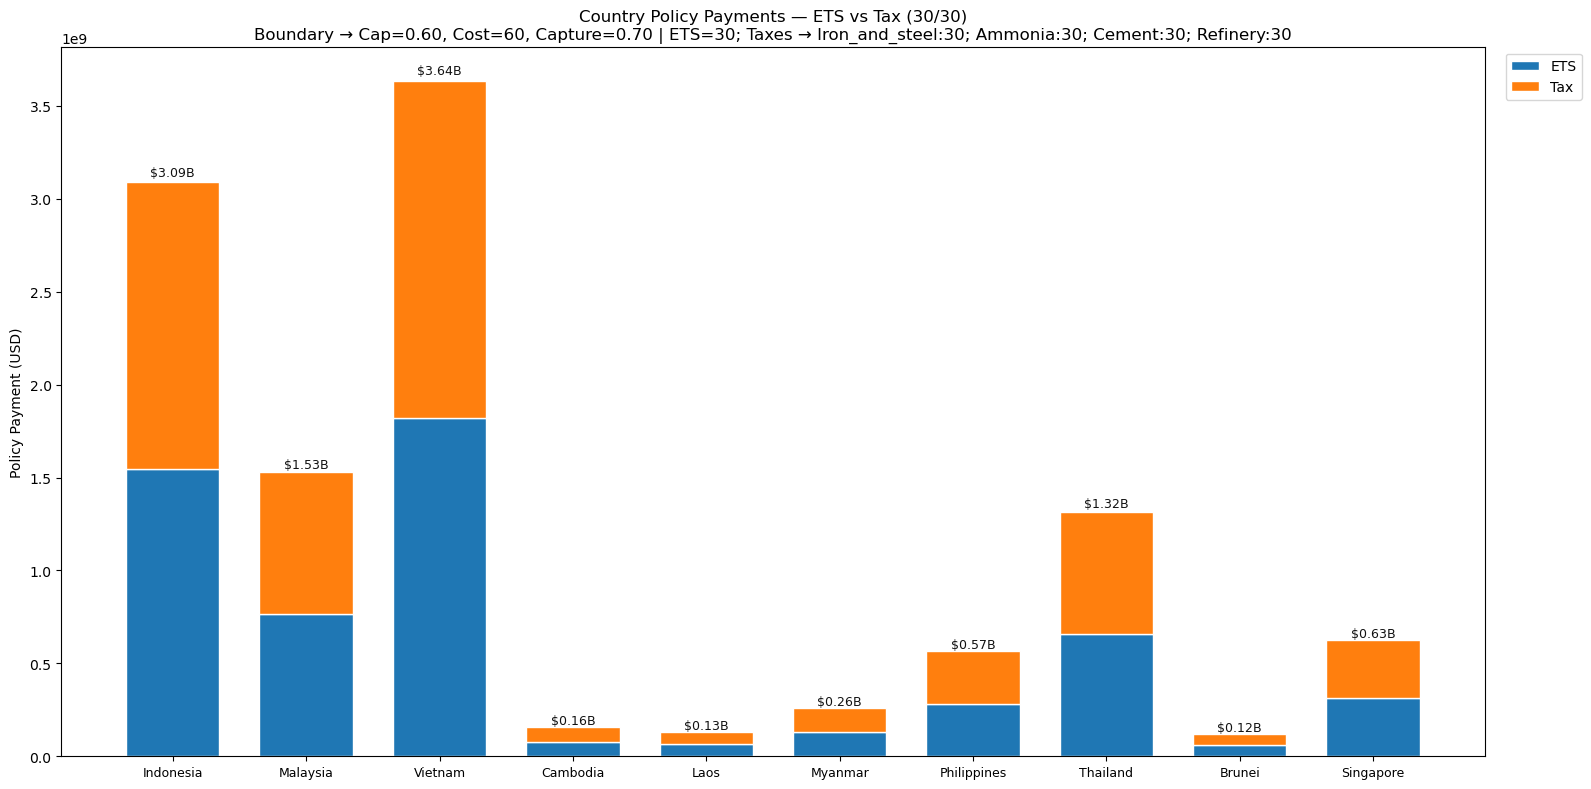

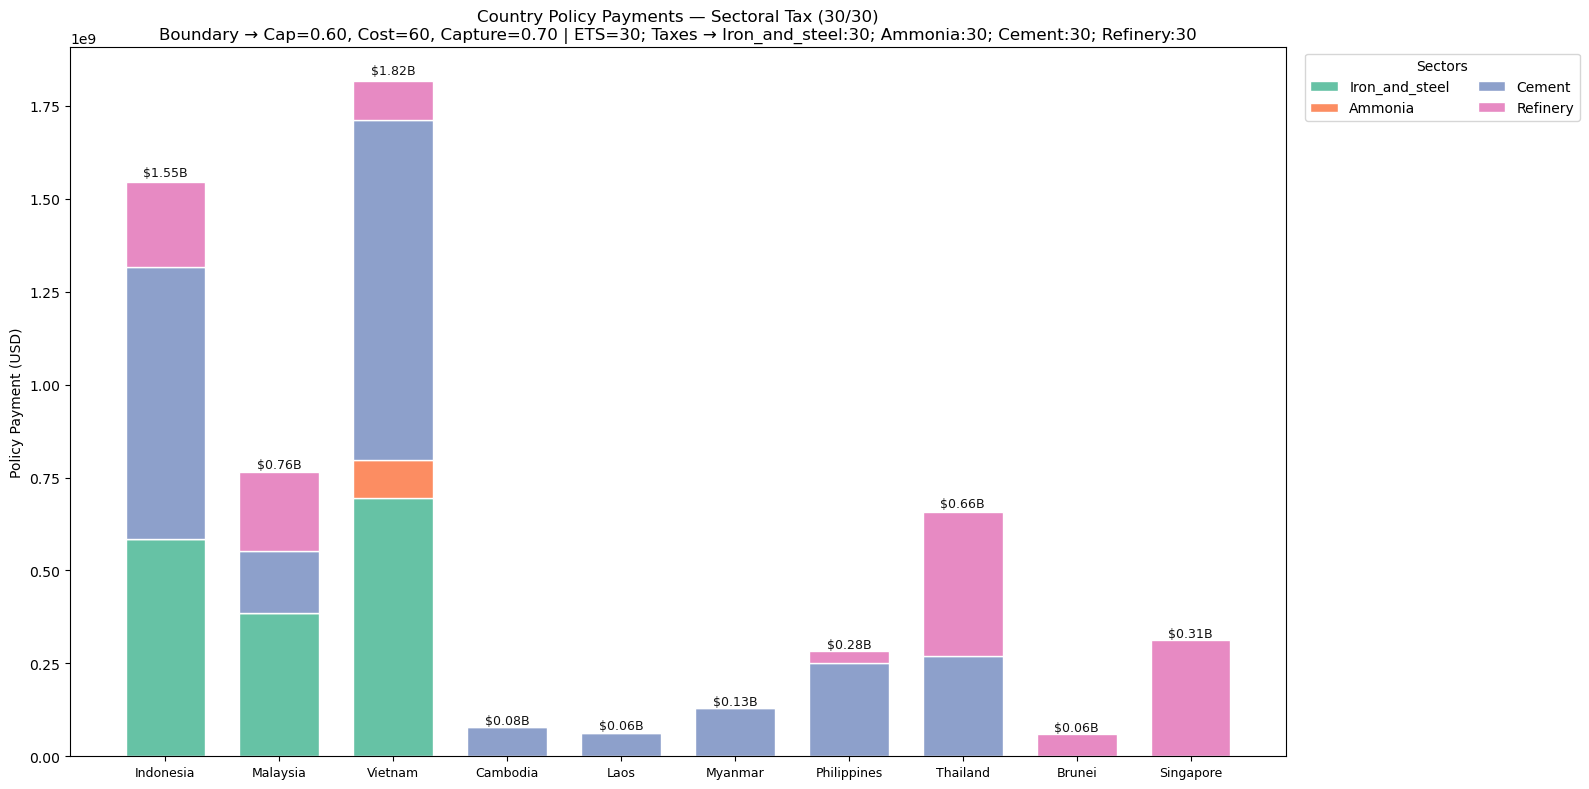

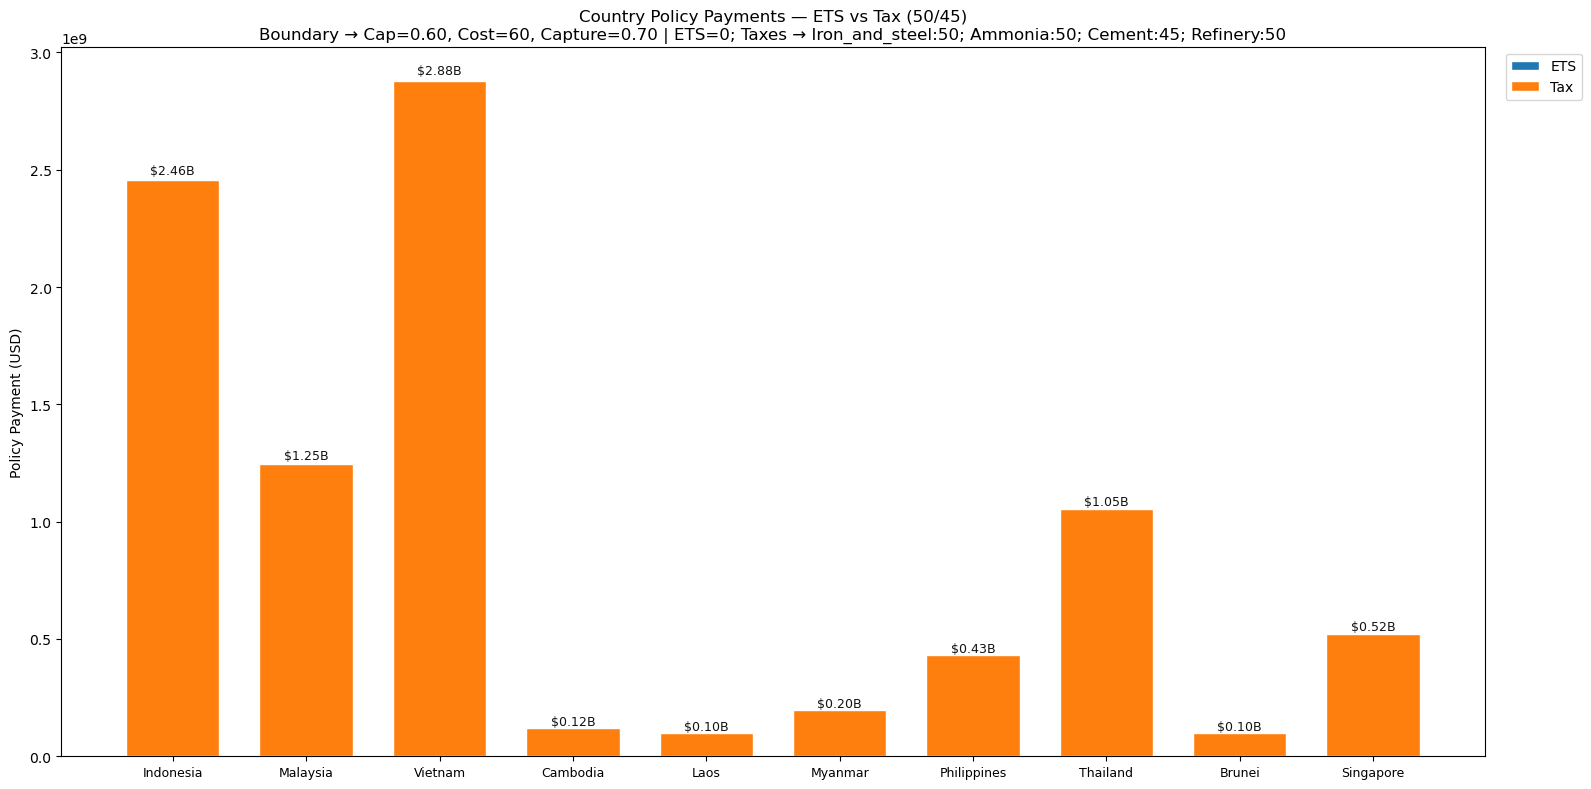

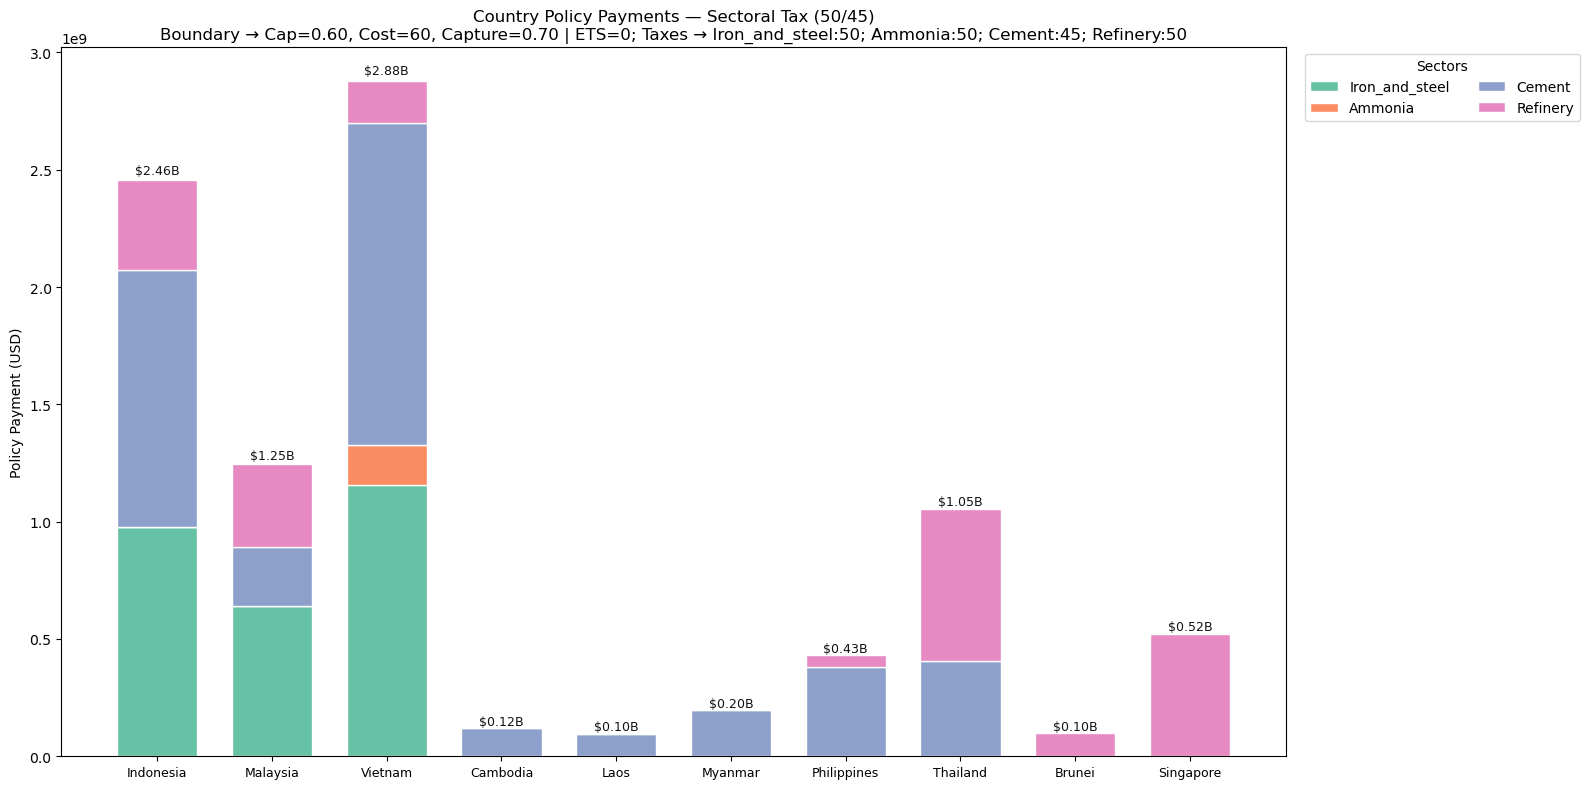

In [405]:
# === FOUR COUNTRY-WIDE PLOTS: 30/30 & 50/45 (ETS-vs-Tax and Sectoral Tax) ===
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# --- Fallbacks / sanity checks -------------------------------------------------
_missing = []
for _g in ["country_names", "sector_names", "country_sector_emissions"]:
    if _g not in globals():
        _missing.append(_g)
if _missing:
    raise NameError(f"Missing globals: {', '.join(_missing)}. "
                    "Please define them before running this cell.")

def _darken_hex(c, factor=0.6):
    import matplotlib.colors as mcolors
    rgb = np.array(mcolors.to_rgb(c))
    return np.clip(rgb * factor, 0, 1)

if 'darken' not in globals():
    def darken(c, factor=0.6):
        return _darken_hex(c, factor)

# If sector_color_map isn't provided, make a clean default
if 'sector_color_map' not in globals():
    palette = list(plt.cm.tab20.colors)
    sector_color_map = {s: palette[i % len(palette)] for i, s in enumerate(sector_names)}

# --- Shared helpers ------------------------------------------------------------
def _fmt_billions(x):
    return f"${x/1e9:.2f}B"

def _boundary_title_suffix(scenario):
    cap     = float(scenario.get('EmissionCap', np.nan))
    cost    = float(scenario.get('AbatementCost', np.nan))
    capture = float(scenario.get('CaptureRate', np.nan))
    ets     = float(scenario.get('ETS_Price', 0.0))
    taxes_summary = "; ".join([f"{s}:{float(scenario.get(f'CarbonTax_{s}', 0)):.0f}" for s in sector_names])
    return (f"Boundary → Cap={cap:.2f}, Cost={cost:.0f}, Capture={capture:.2f} | "
            f"ETS={ets:.0f}; Taxes → {taxes_summary}")

# --- Plots you asked for -------------------------------------------------------
def plot_country_policy_payments_type_only_at_boundary(
    scenario,
    title_prefix="Country Policy Payments — ETS vs Tax (Type-only)",
    figsize=(16, 8),
    annotate_totals=True,
    bar_mode="stacked"  # or "grouped"
):
    """Aggregates across sectors; shows only ETS vs Tax per country."""
    ets_price = float(scenario.get('ETS_Price', 0.0))

    ets_totals = []
    tax_totals = []
    for country in country_names:
        emis_sum = 0.0
        tax_pay  = 0.0
        for sector in sector_names:
            emis = float(country_sector_emissions.get((country, sector), 0.0))
            tax  = float(scenario.get(f'CarbonTax_{sector}', 0.0))
            emis_sum += emis
            tax_pay  += tax * emis
        ets_totals.append(ets_price * emis_sum)
        tax_totals.append(tax_pay)

    ets_totals = np.array(ets_totals, dtype=float)
    tax_totals = np.array(tax_totals, dtype=float)
    totals = ets_totals + tax_totals

    ETS_COLOR = 'tab:blue'
    TAX_COLOR = 'tab:orange'

    ind = np.arange(len(country_names))
    width = 0.7 if bar_mode == "stacked" else 0.38

    plt.figure(figsize=figsize)
    if bar_mode == "stacked":
        plt.bar(ind, ets_totals, width, label="ETS", color=ETS_COLOR, edgecolor='white')
        plt.bar(ind, tax_totals, width, bottom=ets_totals, label="Tax", color=TAX_COLOR, edgecolor='white')
        if annotate_totals:
            for i, t in enumerate(totals):
                if t > 0:
                    plt.text(ind[i], t * 1.005, _fmt_billions(t), ha='center', va='bottom', fontsize=9, color='#111')
    else:
        plt.bar(ind - width/2, ets_totals, width, label="ETS", color=ETS_COLOR, edgecolor='white')
        plt.bar(ind + width/2, tax_totals, width, label="Tax", color=TAX_COLOR, edgecolor='white')
        if annotate_totals:
            for i in range(len(country_names)):
                y = max(ets_totals[i], tax_totals[i]) * 1.05
                if y > 0:
                    plt.text(ind[i], y, f"Total { _fmt_billions(totals[i]) }", ha='center', va='bottom', fontsize=9, color='#111')

    plt.xticks(ind, country_names, rotation=0, fontsize=9, ha='center')
    plt.ylabel("Policy Payment (USD)")
    plt.title(f"{title_prefix}\n{_boundary_title_suffix(scenario)}")
    plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1))
    plt.tight_layout()
    plt.show()

def plot_country_sectoral_tax_only_at_boundary(
    scenario,
    title_prefix="Country Policy Payments — Sectoral Tax (Stacked)",
    figsize=(16, 8),
    annotate_totals=True
):
    """Stacks only the Tax component by sector (no ETS)."""
    ind = np.arange(len(country_names))
    width = 0.7

    # Build tax stacks per sector
    stacks = {s: [] for s in sector_names}
    for country in country_names:
        for sector in sector_names:
            emis = float(country_sector_emissions.get((country, sector), 0.0))
            tax  = float(scenario.get(f'CarbonTax_{sector}', 0.0))
            stacks[sector].append(tax * emis)

    plt.figure(figsize=figsize)
    bottom = np.zeros(len(country_names), dtype=float)
    for sector in sector_names:
        vals = np.array(stacks[sector], dtype=float)
        plt.bar(
            ind, vals, width, bottom=bottom,
            color=sector_color_map[sector],
            edgecolor='white',
            label=sector
        )
        bottom += vals

    if annotate_totals:
        for i, t in enumerate(bottom):
            if t > 0:
                plt.text(ind[i], t * 1.005, _fmt_billions(t), ha='center', va='bottom', fontsize=9, color='#111')

    plt.xticks(ind, country_names, rotation=0, fontsize=9, ha='center')
    plt.ylabel("Policy Payment (USD)")
    plt.title(f"{title_prefix}\n{_boundary_title_suffix(scenario)}")
    plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1), ncol=2, title="Sectors")
    plt.tight_layout()
    plt.show()

# --- Scenarios (match your earlier examples) ----------------------------------
scenario_balanced_30_30 = {
    'EmissionCap': 0.60, 'AbatementCost': 60, 'CaptureRate': 0.70, 'ETS_Price': 30.0,
}
for _s in sector_names:
    scenario_balanced_30_30[f'CarbonTax_{_s}'] = 30.0

scenario_tax_only_50_45 = {
    'EmissionCap': 0.60, 'AbatementCost': 60, 'CaptureRate': 0.70, 'ETS_Price': 0.0,
    'CarbonTax_Iron_and_steel': 50.0, 'CarbonTax_Ammonia': 50.0,
    'CarbonTax_Cement': 45.07, 'CarbonTax_Refinery': 50.0,
}

# --- Make the 4 plots ----------------------------------------------------------
# 1) 30/30 — ETS vs Tax (type-only)
plot_country_policy_payments_type_only_at_boundary(
    scenario_balanced_30_30,
    title_prefix="Country Policy Payments — ETS vs Tax (30/30)",
    annotate_totals=True,
    bar_mode="stacked"   # change to "grouped" if you prefer side-by-side
)

# 2) 30/30 — Sectoral Tax (stacked by sector)
plot_country_sectoral_tax_only_at_boundary(
    scenario_balanced_30_30,
    title_prefix="Country Policy Payments — Sectoral Tax (30/30)",
    annotate_totals=True
)

# 3) 50/45 — ETS vs Tax (type-only)
plot_country_policy_payments_type_only_at_boundary(
    scenario_tax_only_50_45,
    title_prefix="Country Policy Payments — ETS vs Tax (50/45)",
    annotate_totals=True,
    bar_mode="stacked"
)

# 4) 50/45 — Sectoral Tax (stacked by sector)
plot_country_sectoral_tax_only_at_boundary(
    scenario_tax_only_50_45,
    title_prefix="Country Policy Payments — Sectoral Tax (50/45)",
    annotate_totals=True
)


In [406]:
# === CAPTURED-SHARE THRESHOLDS (non-trivial, cost-fixed) =====================
import numpy as np
import pandas as pd

# ---- Helpers (same idea as before, with two key upgrades) -------------------
def _col(df, *names, default=None, as_num=False):
    for n in names:
        if n in df.columns:
            s = df[n]
            if as_num:
                s = pd.to_numeric(s, errors='coerce')
            return s
    if default is None:
        default = 0.0
    return pd.Series(np.full(len(df), default), index=df.index)

def _is_feasible(df):
    if 'Feasible' in df.columns:
        return (_col(df, 'Feasible', as_num=True).fillna(0) > 0).astype(bool)
    if 'Status' in df.columns:
        return df['Status'].astype(str).str.lower().eq('optimal')
    return pd.Series(False, index=df.index)

def _get_ets_price(row):
    if 'ETS_Price' in row: return float(row['ETS_Price'])
    if 'ETS Price' in row: return float(row['ETS Price'])
    return 0.0

def _get_tax_for_sector(row, sector):
    k1 = f'CarbonTax_{sector}'
    k2 = f'Carbon Tax [{sector}]'
    if k1 in row: return float(row[k1])
    if k2 in row: return float(row[k2])
    return 0.0

def _get_captured_share(row):
    for k in ['CapturedShare','Captured_Share','TotalCapturedShare','Captured_Share_Fraction','CaptureShare']:
        if k in row: return float(row[k])
    # Fallback: treat scenario 'CaptureRate' as captured share if no explicit column exists
    return float(row.get('CaptureRate', np.nan))

def _nearest_value(existing, target):
    existing = np.asarray(sorted(pd.unique(existing.dropna())))
    if len(existing) == 0: return None
    return float(existing[(np.abs(existing - target)).argmin()])

def _format_money(x):
    try:
        return f"${x:,.0f}"
    except Exception:
        return x

# ---- Bases from preview_df (same as your stacking code) ---------------------
CI = _col(preview_df, 'Carbon_Intensity','Carbon Intensity','carbon_intensity', as_num=True).fillna(0)
AP = _col(preview_df, 'Actual_Production','Actual Production','Production','Output','actual_production', as_num=True).fillna(0)
EC = _col(preview_df, 'Emission_Cap','Emission Cap','Cap','cap', as_num=True).fillna(0).clip(0,1)
JG = _col(preview_df, 'Jurisdiction_GHG','Jurisdiction GHG','Coverage','coverage','jurisdiction_ghg', as_num=True).fillna(1).clip(0,1)

ETS_BASE = float((CI * AP * (1 - EC)).sum())
_tax_bases = {}
for s in sector_names:
    mask = preview_df['Sector'].astype(str) == s
    _tax_bases[s] = float((CI[mask] * AP[mask] * JG[mask]).sum())

# ---- Pick results frame ------------------------------------------------------
_res = results_3d.copy() if 'results_3d' in globals() else results_csv.copy()
for col in ['EmissionCap','AbatementCost','CaptureRate']:
    if col in _res.columns:
        _res[col] = pd.to_numeric(_res[col], errors='coerce')
_res['__Feasible__'] = _is_feasible(_res)

# ---- Core: build table with (a) fixed cost and (b) non-zero price filter ----
def captured_share_threshold_table(
    res_df,
    sector_list,
    caps=(0.4, 0.6, 0.8),
    targets=(0.30, 0.50, 0.70),
    # set a policy-relevant cost regime (use '==', 60 or '==', 90 etc.)
    abatement_cost_filter=('==', 60),
    require_positive_price=True,
    price_tol=1e-9,
    round_prices=2
):
    rows = []
    feas = res_df['__Feasible__'].fillna(False)

    # cost filter
    if abatement_cost_filter is not None and 'AbatementCost' in res_df.columns:
        op, val = abatement_cost_filter
        cost = pd.to_numeric(res_df['AbatementCost'], errors='coerce')
        if op == '<=': feas &= (cost <= val)
        elif op == '<': feas &= (cost < val)
        elif op == '>=': feas &= (cost >= val)
        elif op == '>': feas &= (cost > val)
        elif op == '==': feas &= np.isclose(cost, val, atol=1e-9)

    caps_existing = res_df['EmissionCap'].dropna() if 'EmissionCap' in res_df.columns else pd.Series(dtype=float)
    captured_all = res_df.apply(_get_captured_share, axis=1)

    for cap_target in caps:
        cap_near = _nearest_value(caps_existing, cap_target) if 'EmissionCap' in res_df.columns else None
        cap_mask = feas if cap_near is None else (feas & np.isclose(res_df['EmissionCap'], cap_near, atol=1e-9))

        for tgt in targets:
            # candidates: feasible at this cap and reaching the target share
            cand_mask = cap_mask & (captured_all >= tgt)
            if not cand_mask.any():
                rows.append({
                    'Cap': cap_target,
                    'MatchedCapInData': cap_near,
                    'TargetCapture': tgt,
                    'ETS_Price': np.nan,
                    **{f'Tax_{s}': np.nan for s in sector_list},
                    'ChosenAbatementCost': np.nan,
                    'TotalPolicyPayment': np.nan,
                    'ScenarioIndex': np.nan
                })
                continue

            cands = res_df[cand_mask].copy()
            ets_p = cands.apply(_get_ets_price, axis=1)
            # sum of sector taxes for the positivity test
            tax_sum = pd.Series(0.0, index=cands.index)
            for s in sector_list:
                tax_s = cands.apply(lambda r: _get_tax_for_sector(r, s), axis=1)
                tax_sum = tax_sum.add(tax_s, fill_value=0.0)

            # (b) optionally drop trivial zero-price candidates
            if require_positive_price:
                nonzero = (np.abs(ets_p) > price_tol) | (np.abs(tax_sum) > price_tol)
                cands = cands[nonzero]
                ets_p = ets_p[nonzero]
                if cands.empty:
                    rows.append({
                        'Cap': cap_target,
                        'MatchedCapInData': cap_near,
                        'TargetCapture': tgt,
                        'ETS_Price': 0.0,
                        **{f'Tax_{s}': 0.0 for s in sector_list},
                        'ChosenAbatementCost': float(res_df.loc[cand_mask, 'AbatementCost'].min()) if 'AbatementCost' in res_df.columns else np.nan,
                        'TotalPolicyPayment': 0.0,
                        'ScenarioIndex': np.nan
                    })
                    continue

            # total payment
            total_payments = ets_p * ETS_BASE
            price_cols = {}
            for s in sector_list:
                taxes_s = cands.apply(lambda r: _get_tax_for_sector(r, s), axis=1)
                total_payments = total_payments + taxes_s * _tax_bases[s]
                price_cols[s] = taxes_s

            idx_min = total_payments.idxmin()
            row = res_df.loc[idx_min]
            out = {
                'Cap': cap_target,
                'MatchedCapInData': cap_near,
                'TargetCapture': tgt,
                'ETS_Price': round(_get_ets_price(row), round_prices),
                **{f'Tax_{s}': round(_get_tax_for_sector(row, s), round_prices) for s in sector_list},
                'ChosenAbatementCost': float(row['AbatementCost']) if 'AbatementCost' in row else np.nan,
                'TotalPolicyPayment': float(total_payments.loc[idx_min]),
                'ScenarioIndex': idx_min
            }
            rows.append(out)

    tbl = pd.DataFrame(rows)
    tbl_display = tbl.copy()
    if 'TotalPolicyPayment' in tbl_display.columns:
        tbl_display['TotalPolicyPayment'] = tbl_display['TotalPolicyPayment'].apply(_format_money)

    cols = ['Cap','MatchedCapInData','TargetCapture','ChosenAbatementCost','ETS_Price'] \
           + [f'Tax_{s}' for s in sector_list] + ['TotalPolicyPayment','ScenarioIndex']
    tbl_display = tbl_display[cols]
    return tbl, tbl_display

# ---- Run it (set the cost you want to report; 60 is consistent with your text) ----
thresholds_raw, thresholds_table = captured_share_threshold_table(
    _res,
    sector_list=sector_names,
    caps=(0.4, 0.6, 0.8),
    targets=(0.30, 0.50, 0.70),
    abatement_cost_filter=('==', 60),     # Fix the cost regime to avoid trivial zero-price cases
    require_positive_price=True           # Drop ETS=0 & all taxes=0
)

from IPython.display import display
display(thresholds_table)

# Optional: sanity-check the bases used in the payment calculation
print("ETS_BASE (tCO2):", f"{ETS_BASE:,.0f}")
for s, b in _tax_bases.items():
    print(f"Tax base {s} (tCO2): {b:,.0f}")


Cap  MatchedCapInData  TargetCapture  ChosenAbatementCost  ETS_Price  \
0  0.4               0.4            0.3                 60.0       30.0   
1  0.4               0.4            0.5                 60.0       50.0   
2  0.4               0.4            0.7                 60.0       70.0   
3  0.6               0.6            0.3                 60.0        0.0   
4  0.6               0.6            0.5                 60.0        0.0   
5  0.6               0.6            0.7                  NaN        NaN   
6  0.8               0.8            0.3                 60.0       71.0   
7  0.8               0.8            0.5                 60.0       71.0   
8  0.8               0.8            0.7                 60.0       71.0   

   Tax_Iron_and_steel  Tax_Ammonia  Tax_Cement  Tax_Refinery  \
0                0.00          0.0        0.00          0.00   
1                0.00          0.0        0.00          0.00   
2                0.00          0.0        0.00          0.00   
3                0.00          0.0       65.84          0.00   
4                0.00          0.0       65.84          0.00   
5                 NaN          NaN         NaN           NaN   
6                0.00         71.0        0.00         36.26   
7                0.00         71.0        0.00         61.77   
8               33.75         71.0        0.00         71.00   

  TotalPolicyPayment  ScenarioIndex  
0     $3,429,687,404          617.0  
1     $5,716,145,673          643.0  
2     $8,002,603,942          669.0  
3     $5,716,145,673          929.0  
4     $5,716,145,673          929.0  
5               $nan            NaN  
6     $9,984,201,109         1202.0  
7    $11,127,430,243         1215.0  
8    $13,413,888,512         1241.0

ETS_BASE (tCO2): 114,322,913
Tax base Iron_and_steel (tCO2): 55,487,356
Tax base Ammonia (tCO2): 3,408,147
Tax base Cement (tCO2): 86,821,006
Tax base Refinery (tCO2): 44,821,679
